Поляризация. Проверка нейтральности. Авдеев Роман

**Версия обновлена 27.10.2023**

# Imports

In [1]:
import pandas as pd
import numpy as np
import pymorphy2
import openpyxl
import shutil
import random
import io, codecs, re, os, sys, json, string, csv, datetime

from collections import Counter
from collections import defaultdict

# from pymystem3 import Mystem
from string import punctuation
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from scipy.spatial.distance import cdist
from statistics import mean, mode

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

import dataframe_image as dfi

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df_sovpad = pd.read_excel(r"C:\laba\duplicate_colab_data\df_sovpad.xlsx")

In [3]:
df_sovpad.head(2)

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,kommersant.ru,"Президент США Джо Байден снова заявил, что Ваш...","{'neg': {}, 'pos': {'США': 1, 'Москвы': 1}}",2021-05-06 07:29:00,байден сша искать конфликт россия президент сш...,"['Байден: США не ищут конфликта с Россией.', '...","{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,4908,77085a14-c648-4207-a555-d7d3987400fd,tsargrad.tv,Генсек НАТО испугался дружбы России и Белорусс...,"{'neg': {'НАТО': 2, 'России': 3, 'Белоруссии':...",2021-05-06 11:19:00,генсек нато испугаться дружба россия белорусси...,['Генсек НАТО испугался дружбы России и Белору...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [4]:
toloka = pd.read_csv(r"C:\laba\duplicate_colab_data\toloka.tsv", delimiter='\t').dropna(how='all').reset_index()

In [5]:
toloka.head(2)

,index,INPUT:id,INPUT:text,OUTPUT:pole,OUTPUT:doc_id,OUTPUT:pole_name,GOLDEN:pole,GOLDEN:doc_id,GOLDEN:pole_name,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:accepted
0,0,1020.0,В Иркутске в начале мая росгвардеец застрелил ...,other_topic,1020.0,Не относится к теме,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,13dd6852-68fc-4856-af0b-dd5fe61a4a75,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963
1,1,1019.0,В Иркутске росгвардеец застрелил местного жите...,pole_1,1019.0,Поляризация1,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,22f230cd-d003-489f-b9fe-e3224d55ee9b,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963


#### Spacy

In [6]:
! pip install pydantic==1.10.2

You should consider upgrading via the 'C:\Users\Авдеев\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [7]:
import spacy

In [8]:
! python -m spacy download ru_core_news_sm

     --------------------------------------- 15.3/15.3 MB 24.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


You should consider upgrading via the 'C:\Users\Авдеев\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [9]:
! python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.5.0                         
Location         C:\Users\Авдеев\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\spacy
Platform         Windows-10-10.0.22621-SP0     
Python version   3.9.13                        
Pipelines        ru_core_news_sm (3.5.0)       



# Data prepare

In [10]:
print('Всего документов:', df_sovpad.shape[0])

Всего документов: 452


In [11]:
print('Список разметчиков и сколько документов каждый из них разметил:')
toloka['ASSIGNMENT:worker_id'].value_counts()

Список разметчиков и сколько документов каждый из них разметил:


be6dd5ed06926c811c121ff0b99d0459    443
57ff7fa2bd80df2ebe1d954b6fef520e    443
3ed0bce4b4375e5b9962640f69fabca2    259
4bfc93d2d535ccc0fe2eebc2d33e6740    131
027b00cba0c5d7791dada81921a1ad70     32
930bb16c0e629e039a95d5bb1f560df2     29
b390c2edc497a8d11e3b709067e8a006     10
07947fa51c6a1d996956f30fef7efa68      9
Name: ASSIGNMENT:worker_id, dtype: int64

## Methods

In [12]:
# маркируем полюсы в толоке лейблами (-1) - нерелевантный(other_topic); (0) - нейтральный(without_polarization); (k) - номер указанного полюса(pole_k)

def marking_toloka_poles(toloka):
    toloka.insert(4, 'pole_mark', np.nan)
    for i in range(toloka.shape[0]):
        if toloka.at[i, 'OUTPUT:pole'] == 'other_topic':
            toloka.at[i, 'pole_mark'] = -1
        elif toloka.at[i, 'OUTPUT:pole'] == 'without_polarization':
            toloka.at[i, 'pole_mark'] = 0
        elif 'pole_' in str(toloka.at[i, 'OUTPUT:pole']):
            mark = int(toloka.at[i, 'OUTPUT:pole'][5])
            if mark == 0:
                mark = 9
            toloka.at[i, 'pole_mark'] = mark

In [13]:
# рассмотрим метки каждого документа: для каждого документа выпишем три метки (тк три асессора) для последующего анализа. Разметку каждого из экспертов считает верной

def check_docs_labels(toloka):
    
    '''def most_common(List):
        return(mode(List))'''
    
    data_doc_labels = pd.DataFrame(columns=['doc_id', 'label_1', 'label_2', 'label_3'])
    data_doc_labels['doc_id'] = list((toloka['OUTPUT:doc_id'].value_counts().index).astype(int)) #лист всех документов из толоки - 452 шт
    
    data_doc_labels = data_doc_labels[['doc_id', 'label_1', 'label_2', 'label_3']]
    
    # добавим столбец, куда будем записывать id разметчиков (пусть будет + контроль, что взяли метки у РАЗНЫХ асессоров)
    # ВАЖНО: workers - id экспертов из толоки, corpus_id - номер корпуса из df_sovpad (т.е. из исходного датасета)
    data_doc_labels.insert(4, 'workers', 'a')
    data_doc_labels.insert(1, 'corpus_id', 'a')
    
    for i in range(toloka.shape[0]):
        curr_doc_id = toloka.at[i, 'OUTPUT:doc_id']
        doc_index_in_df = data_doc_labels[data_doc_labels['doc_id'] == curr_doc_id].index[0] #находим строку в data_doc_labels с doc_id равным curr_doc_id
                
        if np.isnan(data_doc_labels.at[doc_index_in_df, 'label_1']):
            data_doc_labels.at[doc_index_in_df, 'label_1'] = toloka.at[i, 'pole_mark']
            worker_list = [toloka.at[i, 'ASSIGNMENT:worker_id']]
            data_doc_labels.at[doc_index_in_df, 'workers'] = worker_list
        elif np.isnan(data_doc_labels.at[doc_index_in_df, 'label_2']):
            data_doc_labels.at[doc_index_in_df, 'label_2'] = toloka.at[i, 'pole_mark']
            data_doc_labels.at[doc_index_in_df, 'workers'].append(toloka.at[i, 'ASSIGNMENT:worker_id'])
        else:
            np.isnan(data_doc_labels.at[doc_index_in_df, 'label_3'])
            data_doc_labels.at[doc_index_in_df, 'label_3'] = toloka.at[i, 'pole_mark']
            data_doc_labels.at[doc_index_in_df, 'workers'].append(toloka.at[i, 'ASSIGNMENT:worker_id'])
             
#    data_doc_labels.insert(4, 'final_label', np.nan)
    
#    for i in range(data_doc_labels.shape[0]):
#        if (data_doc_labels.at[i, 'label_1'] == data_doc_labels.at[i, 'label_2']) or (data_doc_labels.at[i, 'label_1'] == data_doc_labels.at[i, 'label_3']) or (data_doc_labels.at[i, 'label_2'] == data_doc_labels.at[i, 'label_3']):
#            data_doc_labels.at[i, 'final_label'] = int(most_common(list(data_doc_labels.iloc[i].values[:3])))

    return data_doc_labels

In [14]:
# записать номера корпусов из df_sovpad в data_doc_labels

def mark_corpus_id(data_doc_labels, df_sovpad):
    for i in range(data_doc_labels.shape[0]):
        curr_doc_id = data_doc_labels.at[i, 'doc_id']
        line_index_where_doc_id = df_sovpad[df_sovpad['doc_id'] == curr_doc_id].index[0]
        data_doc_labels.at[i, 'corpus_id'] = df_sovpad.at[line_index_where_doc_id, 'text_group_id']
        
    return data_doc_labels

In [15]:
# преобразовали столбец 'sentiment' из столбца строк в столбец словарей

def transform_to_dict(data):
    import ast
    data['sentiment'] = data['sentiment'].apply(lambda row: ast.literal_eval(row))

In [16]:
# выписать все слова из 'sentiment' для каждого документа в список

def extract_sent_words(data):
    data.insert(4, 'sent_words', '')
    all_sent_words = []
    for i in range(data.shape[0]):
        doc_sent_words = []
        for key in data.at[i, 'sentiment']['pos'].keys():
            doc_sent_words.append(key)
        for key in data.at[i, 'sentiment']['neg'].keys():
            doc_sent_words.append(key)
        data.at[i, 'sent_words'] = doc_sent_words
        all_sent_words += doc_sent_words
    return all_sent_words

In [17]:
#  выписать все слова из 'sentiment' для каждого документа в словарь БЕЗ разделения на neg и pos

def extract_sent_doc_to_dict(data):
    data.insert(4, 'sent_words_dict', '')
    for i in range(data.shape[0]):
        doc_sent = {}
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in doc_sent.keys():
                doc_sent[key] += value
            else:
                doc_sent[key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in doc_sent.keys():
                doc_sent[key] += value
            else:
                doc_sent[key] = value
        data.at[i, 'sent_words_dict'] = doc_sent

In [18]:
#  получаем большой общий словарь по всем документам (разделенный на neg и pos)

def create_all_sent_dict(data):
    all_sent_dict = {'neg':{}, 'pos':{}}
    for i in range(data.shape[0]):
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in all_sent_dict['neg'].keys():
                all_sent_dict['neg'][key] += value
            else:
                all_sent_dict['neg'][key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in all_sent_dict['pos'].keys():
                all_sent_dict['pos'][key] += value
            else:
                all_sent_dict['pos'][key] = value
    return all_sent_dict

In [19]:
#  получаем большой общий словарь по всем документам (БЕЗ разделения на neg и pos)

def create_joined_all_sent_dict(data):
    all_sent_dict = {}
    for i in range(data.shape[0]):
        for key, value in data.at[i, 'sentiment']['neg'].items():
            if key in all_sent_dict.keys():
                all_sent_dict[key] += value
            else:
                all_sent_dict[key] = value
        for key, value in data.at[i, 'sentiment']['pos'].items():
            if key in all_sent_dict.keys():
                all_sent_dict[key] += value
            else:
                all_sent_dict[key] = value
    return all_sent_dict

In [20]:
!pip install kneed -q

You should consider upgrading via the 'C:\Users\Авдеев\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [21]:
from kneed import KneeLocator

In [22]:
# tf-idf для каждого документа на основе сентиментов

def sent_tf_idf(data):
    # размерность вектора tf-idf - кол-во всех уникальных слов в нашем датасете
    # размерность матрицы = (кол-во документов, размерность вектора tf-df)
    # вектор tf-df для документа - соответствующая строка матрицы
    
    #transform_to_dict(data) # прменяем только один раз, когда в первый раз перевели столбец к типу словарь
    extract_sent_doc_to_dict(data)
    
    all_sent = create_joined_all_sent_dict(data)
    
    tf_idf_matrix = np.zeros((data.shape[0], len(all_sent.keys())))
    
    for i in range(data.shape[0]):
        
        tfidf_df = pd.DataFrame({'word': [], 'tfidf': []}) 
        tfidf_df['word'] = all_sent.keys()
        tfidf_df['tfidf'] = 0
        
        all_doc_sent_amount = sum(data.at[i, 'sent_words_dict'].values())   # кол-во уникальных слов в соответствующей колонке для данного документа
    
        for key, value in data.at[i, 'sent_words_dict'].items():
            
            tf = value/all_doc_sent_amount    
            
            doc_key_count = 0
            for j in range(data.shape[0]):
                if key in data.at[j, 'sent_words_dict'].keys():
                    doc_key_count += 1    
                
            idf = np.log(data.shape[0]/doc_key_count)
            
            tfidf = tf*idf
            word_index = tfidf_df[tfidf_df['word'] == key].index[0]
            tfidf_df.at[word_index, 'tfidf'] = tfidf
        
        tf_idf_matrix[i] = tfidf_df['tfidf'].to_numpy()
    
    return tf_idf_matrix

In [23]:
# выбор лучшего числа кластеров для kmeans

def inertia_comparing(inertia):
  '''y_axis = inertia
  k_coeffs = []
  
  for i in range(2, len(inertia)):
    M1 = np.array([[float(i-1), 1.], [float(i), 1.]])
    v1 = np.array([float(inertia[i-2]), float(inertia[i-1])])
    k, b = np.linalg.solve(M1, v1)
    k_coeffs.append(k)
  
  max_delta = 0
  n_clust = 0
  for i in range(1, len(k_coeffs)):
    if abs(k_coeffs[i-1] - k_coeffs[i]) > max_delta:
      max_delta = abs(k_coeffs[i-1] - k_coeffs[i])
      n_clust = i
  # АХТУНГ в оригинале снизу нет прибавления единицы'''
  
  elbow = KneeLocator(np.arange(1, 10), inertia, curve='convex', direction='decreasing').knee
  return elbow

In [24]:
# извлекаем соответствующий корпус из толоки

def extract_corpus_from_toloka(toloka, docs_ids):
  toloka_corpus_data = pd.DataFrame(columns = toloka.columns.values)
  for i in range(toloka.shape[0]):
    if toloka.at[i, 'INPUT:id'] in docs_ids:
      toloka_corpus_data = toloka_corpus_data.append(toloka.iloc[i], ignore_index=True)
  return toloka_corpus_data

In [25]:
# проверяем соответствие id корпуса из данных и из толоки(они в толоке и дате разные, а id документов одинаковые)

def equal_toloka_data_group_ids(toloka_gr_id, data_gr_id, toloka_data_corpuses_ids):
  flag = False
  for i in range(toloka_data_corpuses_ids.shape[0]):
    if toloka_data_corpuses_ids.at[i, 'toloka'] == toloka_gr_id and toloka_data_corpuses_ids.at[i, 'data'] == data_gr_id:
      flag = True
      break
  return flag

In [26]:
def corpus_to_tf_idf(corpus):
  text = corpus['lemm_sentences']
  #text = join_strs(corpus['text'])
  #text = preprocessing(text)
  tfidfconverter = TfidfVectorizer(stop_words=nltk_stopwords.words('russian'))
  tfidf = tfidfconverter.fit_transform(text)
  return tfidf

In [27]:
def train_kmeans(X, klasters):
    kmeans = KMeans(n_clusters=klasters, algorithm='full', init='k-means++', max_iter=300)
    y=kmeans.fit_predict(X.reshape(-1, 1))
    return kmeans

In [992]:
inertias_plot = []

In [993]:
n_cls = []

In [28]:
def modeling_for_curr_corpus(tfidf):
  inertias = []
  K = range(1, 10)

  for k in K:
      # Building and fitting the model
      if k > tfidf.shape[0]:
        k = tfidf.shape[0]
      kmeansModel = train_kmeans(tfidf, k)
      inertias.append(kmeansModel.inertia_)
      
  inertias_plot.append(inertias)
  n_cls.append( inertia_comparing(inertias))
  
  kmeansModel = train_kmeans(tfidf, inertia_comparing(inertias))
  return kmeansModel

## Metrics

In [29]:
# измерение качества, метрика M1 (точность и полнота кластеризации мнений)

# полагаем, что на вход дается X с мнениями-кластерами и Y - экспертна разметка

def M1(X, Y):
    X = list(X)
    Y = list(np.array(Y).astype(int))
    P_list = []
    R_list = []
    
    for i in range(len(X)):
        x_i = X[i]
        y_i = Y[i]
        sum_labels_i = 0
        sum_x = 0
        sum_y = 0
        for k in range(len(X)):
            if  X[k] == x_i and Y[k] == y_i:
                sum_labels_i += 1
                sum_x += 1
                sum_y += 1
            elif X[k] == x_i:
                sum_x += 1
            elif Y[k] == y_i:
                sum_y += 1
        
        if sum_x == 0:
            P_i = 0
        else:
            P_i = sum_labels_i/sum_x
            
        if sum_y == 0:
            R_i = 0
        else:
            R_i = sum_labels_i/sum_y
        
        P_list.append(P_i)
        R_list.append(R_i)
        
    P = np.mean(P_list)
    R = np.mean(R_list)
    
    return 2 * P * R /(P + R)

In [30]:
# измерение качества, метрика M2 (точность и полнота определения нейтральных сообщений)
# полагаем, что на вход дается list X с нейтральными докуменатми и Y - список нейтральных из толоки

def M2(X, Y):
    sum_labels = 0
    
    for i in range(len(X)):
        if  X[i] == 0 and Y[i] == 0:
            sum_labels += 1
    sum_x = X.count(0)
    sum_y = Y.count(0)
    if sum_x == 0:
        P_0 = 0
    else:
        P_0 = sum_labels/sum_x 
            
    if sum_y == 0:
        return np.nan
    else:
        R_0 = sum_labels/sum_y
        if P_0 + R_0 == 0:
            return 0
        else:
            return 2 * P_0 * R_0 /(P_0 + R_0)    

In [31]:
# измерение качества, метрика M2 (точность и полнота определения нейтральных сообщений)
# полагаем, что на вход дается list X с нейтральными докуменатми и Y - список нейтральных из толоки

def M2_upd(X, Y):
    sum_labels = 0
    
    for i in range(len(X)):
        if  X[i] == 0 and Y[i] == 0:
            sum_labels += 1
    sum_x = X.count(0)
    sum_y = Y.count(0)
    if sum_x == 0:
        P_0 = 0
    else:
        P_0 = sum_labels/sum_x 
            
    if sum_y == 0:
        R_0 = 0
    else:
        R_0 = sum_labels/sum_y
        
    if P_0 + R_0 == 0:
        return 0
    else:
        return 2 * P_0 * R_0 /(P_0 + R_0)  

In [32]:
# измерение качества, метрика M3 (точность и полнота определения нерелевантных сообщений)
# полагаем, что на вход дается list X с other_topic докуменатми (y_pred) и Y - список other_topic из толоки (y_true)

def M3(X, Y, show=False):
    sum_labels = 0
    for i in range(len(X)):
        if Y[i] == -1 and X[i] == -1:
            sum_labels += 1
    sum_x = X.count(-1)
    sum_y = Y.count(-1)
    if sum_x == 0:
        P_1 = 0
    else:
        P_1 = sum_labels/sum_x 
            
    if sum_y == 0:
        if show:
            print('В разметки нет нерелевантных, M3 =', np.nan)
        return np.nan
    else:
        R_1 = sum_labels/sum_y
        if show:
            print('precision=', P_1)
            print('recall=', R_1)
        if (P_1 + R_1) == 0:
            if show:
                print('M3=', 0)
            return 0
        else:  
            if show:
                print('M3=', 2 * P_1 * R_1 /(P_1 + R_1))
            return 2 * P_1 * R_1 /(P_1 + R_1)

In [34]:
# измерение качества, метрика M3 (точность и полнота определения нерелевантных сообщений)
# полагаем, что на вход дается list X с other_topic докуменатми (y_pred) и Y - список other_topic из толоки (y_true)

def M3_upd(X, Y):
    sum_labels = 0
    for i in range(len(X)):
        if Y[i] == -1 and X[i] == -1:
            sum_labels += 1
    sum_x = X.count(-1)
    sum_y = Y.count(-1)
    if sum_x == 0:
        P_1 = 0
    else:
        P_1 = sum_labels/sum_x 
            
    if sum_y == 0:
        R_1 = 0
    else:
        R_1 = sum_labels/sum_y
        
    if (P_1 + R_1) == 0:
        return 0
    else:  
        return 2 * P_1 * R_1 /(P_1 + R_1)

In [35]:
# удаляем пары объектов в X и Y, где хотя бы в одном месте есть NAN

def delete_nans(X, Y):
    # избавимся от nan
    X_c, Y_c = X.copy(), Y.copy()
    X_nan_ind = np.argwhere(np.isnan(X_c)).tolist()
    X_nan_ind_list = list(chain.from_iterable(X_nan_ind))
    
    Y_nan_ind = np.argwhere(np.isnan(Y_c)).tolist()
    Y_nan_ind_list = list(chain.from_iterable(Y_nan_ind))
    
    X_nan_ind_list.extend(Y_nan_ind_list)
    
    for ind in sorted(X_nan_ind_list, reverse=True):
        del X_c[ind]
        del Y_c[ind]
    return X_c, Y_c

In [36]:
# проставляем лейблы нерелевантным, удобные для подсчета метрик

def prepare_non_relevant_labling(X, Y):
    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '-1'
    X_binarized = np.array(X.copy(), dtype=int)
    X_binarized[X_binarized >= 0] = 1
    Y_binarized = np.array(Y.copy(), dtype=int)
    Y_binarized[Y_binarized >= 0] = 1
    # теперь только лейблы +1 и -1
    return X_binarized, Y_binarized

In [37]:
# измерение качества, метрика M3 (точность и полнота определения релевантных сообщений)
# полагаем, что на вход дается list X с other_topic докуменатми (y_pred) и Y - список other_topic из толоки (y_true)

def M3_relevant(X, Y, show=False):
    X_clear, Y_clear = delete_nans(X, Y)
    X_binarized, Y_binarized = prepare_non_relevant_labling(X_clear, Y_clear)
    
    sum_labels = 0
    for i in range(len(X_binarized)):
        if Y_binarized[i] != -1 and X_binarized[i] != -1:
            sum_labels += 1
            
    sum_x = list(X_binarized).count(1)
    sum_y = list(Y_binarized).count(1)
    if sum_x == 0:
        P_1 = 0
    else:
        P_1 = sum_labels/sum_x 
            
    if sum_y == 0:
        if show:
            print('В разметки нет нерелевантных, M3 =', np.nan)
        return np.nan
    else:
        R_1 = sum_labels/sum_y
        if show:
            print('precision=', P_1)
            print('recall=', R_1)
        if (P_1 + R_1) == 0:
            if show:
                print('M3=', np.nan)
            return np.nan
        else:  
            if show:
                print('M3=', 2 * P_1 * R_1 /(P_1 + R_1))
            return 2 * P_1 * R_1 /(P_1 + R_1)

In [38]:
def M3_precision_recall(X, Y):
    sum_labels = 0
    for i in range(len(X)):
        if Y[i] == -1 and X[i] == -1:
            sum_labels += 1
    sum_x = X.count(-1)
    sum_y = Y.count(-1)
    if sum_x == 0:
        P_1 = 0
    else:
        P_1 = sum_labels/sum_x 
            
    if sum_y == 0:
        R_1 = 0
    else:
        R_1 = sum_labels/sum_y
    return P_1, R_1

In [39]:
# проставляем лейблы нейтральным, удобные для подсчета метрик
# на данном этапе избавились от нерелевантных, остались только лейблы >=0

def prepare_neutral_labling(X, Y):
    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '0'
    X_binarized = np.array(X.copy(), dtype=int)
    X_binarized[X_binarized > 0] = 1
    Y_binarized = np.array(Y.copy(), dtype=int)
    Y_binarized[Y_binarized > 0] = 1
    return X_binarized, Y_binarized

In [40]:
def M2_non_neutral(X, Y, show=False):
    X_clear, Y_clear = delete_nans(X, Y)
    X_binarized, Y_binarized = prepare_neutral_labling(X_clear, Y_clear)
    
    sum_labels = 0
    for i in range(len(X_binarized)):
        if Y_binarized[i] > 0 and X_binarized[i] > 0:
            sum_labels += 1
            
    sum_x = len(list(X_binarized)) - list(X_binarized).count(0) - list(X_binarized).count(-1)
    sum_y = len(list(Y_binarized)) - list(Y_binarized).count(0) - list(Y_binarized).count(-1)
    
    if sum_x == 0:
        P_0 = 0
    else:
        P_0 = sum_labels/sum_x 
            
    if sum_y == 0:
        if show:
            print('В разметки нет нейтральных, M2 =', np.nan)
        R_0 = 0
    else:
        R_0 = sum_labels/sum_y
        if show:
            print('precision=', P_0)
            print('recall=', R_0)
    if (P_0 + R_0) == 0:
        if show:
            print('M2=', 0)
        return 0
    else:  
        if show:
            print('M2=', 2 * P_0 * R_0/(P_0 + R_0))
        return 2 * P_0 * R_0/(P_0 + R_0)

In [41]:
# измерение качества, метрика M4 (точность определения числа мнений)

# X - ответ алогритма, Y - экспертная разметка
 
def M4(X, Y):
  K_x = float(len(set(list(X))))
  K_y = float(len(set(Y)))
  return min([K_x, K_y])/max([K_x, K_y])

### Тестируем новые метрики для нейтральных и нерелевантных

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

from itertools import chain

In [101]:
# удаляем пары объектов в X и Y, где хотя бы в одном месте есть NAN

def delete_nans(X, Y):
    # избавимся от nan
    X_c, Y_c = X.copy(), Y.copy()
    X_nan_ind = np.argwhere(np.isnan(X_c)).tolist()
    X_nan_ind_list = list(chain.from_iterable(X_nan_ind))
    
    Y_nan_ind = np.argwhere(np.isnan(Y_c)).tolist()
    Y_nan_ind_list = list(chain.from_iterable(Y_nan_ind))
    
    X_nan_ind_list.extend(Y_nan_ind_list)
    
    for ind in sorted(X_nan_ind_list, reverse=True):
        del X_c[ind]
        del Y_c[ind]
    return X_c, Y_c

In [103]:
# проставляем лейблы нерелевантным, удобные для подсчета метрик

def prepare_non_relevant_labling(X, Y):
    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '-1'
    X_binarized = np.array(X.copy(), dtype=int)
    X_binarized[X_binarized >= 0] = 1
    X_binarized[X_binarized < 0] = 0
    Y_binarized = np.array(Y.copy(), dtype=int)
    Y_binarized[Y_binarized >= 0] = 1
    Y_binarized[Y_binarized < 0] = 0
    return X_binarized, Y_binarized

In [39]:
def compute_metrics(X, Y):
    accuracy = accuracy_score(y_pred=X, y_true=Y)
    k = cohen_kappa_score(y1=X, y2=Y)
    MCC = matthews_corrcoef(y_pred=X, y_true=Y)
    return round(accuracy, 3), round(k, 3), round(MCC, 3)

In [104]:
# пробуем новые метрики для оценки нерелевантных - accuracy, AUC, kappa, MCC, silhouette
# тк отбрасываем нерелевантные и нейтральные последовательно, то на каждом этапе по сути имеем бинарную кластеризацию

def non_relevant_metrics(X, Y):
    # избавимся от nan
    X, Y = delete_nans(X, Y)

    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '-1'
    X_binarized, Y_binarized = prepare_non_relevant_labling(X, Y)

    accuracy, k, MCC = compute_metrics(X_binarized, Y_binarized)
    return accuracy, k, MCC

In [75]:
asessors_comparing_non_relev = pd.DataFrame(columns=['1_2', '2_1', '1_3', '3_1', '2_3', '3_2'], index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_non_relev = asessors_comparing_non_relev[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

In [58]:
def metric_dataframe_fill(df, row, columns, metric):
    for i in range(len(metric)):
        df.at[row, columns[i]] = metric[i]

In [59]:
def compute_metric_mean_values(df, columns):
    for column in columns:
        df.at['Total mean', column] = df[column].mean()

In [76]:
for corpus_id in corpus_ids_list:
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    asessors_comparing_non_relev.at[corpus_id, '1_2'] = non_relevant_metrics(list(test['label_1']), list(test['label_2']))[1]
    asessors_comparing_non_relev.at[corpus_id, '2_1'] = non_relevant_metrics(list(test['label_2']), list(test['label_1']))[1]
    
    asessors_comparing_non_relev.at[corpus_id, '1_3'] = non_relevant_metrics(list(test['label_1']), list(test['label_3']))[1]
    asessors_comparing_non_relev.at[corpus_id, '3_1'] = non_relevant_metrics(list(test['label_3']), list(test['label_1']))[1]
    
    asessors_comparing_non_relev.at[corpus_id, '2_3'] = non_relevant_metrics(list(test['label_2']), list(test['label_3']))[1]
    asessors_comparing_non_relev.at[corpus_id, '3_2'] = non_relevant_metrics(list(test['label_3']), list(test['label_2']))[1]

In [79]:
asessors_comparing_non_relev

,1_2,2_1,1_3,3_1,2_3,3_2
17af2621-05bd-4008-a8f5-4afe64a4e823,0.0,0.0,-0.078,-0.078,0.0,0.0
1bcad992-3329-4807-8ac5-920aee3c0db8,0.0,0.0,0.0,0.0,0.0,0.0
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,0.0,0.0,0.0,0.0
3975555d-2f8b-48a4-85ed-7ce390c04618,0.0,0.0,0.0,0.0,0.0,0.0
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,0.0,0.0,0.0,0.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,1.0,1.0,-0.083,-0.083,-0.083,-0.083
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.071,0.071,0.0,0.0,0.0,0.0
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,1.0,1.0,1.0,1.0,1.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,-0.027,-0.027,0.0,0.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.0,0.0,0.0,0.0,NaN,NaN


In [78]:
compute_metric_mean_values(asessors_comparing_non_relev,['1_2', '2_1', '1_3', '3_1', '2_3', '3_2'])

In [80]:
print('Kappa mean:', (asessors_comparing_non_relev.at['Total mean', '1_2'] + asessors_comparing_non_relev.at['Total mean', '1_3'] + asessors_comparing_non_relev.at['Total mean', '2_3'])/3)

Kappa mean: 0.18037777777777775


Теперь посмотрим на нейтральные:

In [70]:
# проставляем лейблы нейтральным, удобные для подсчета метрик

def prepare_neutral_labling(X, Y):
    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '0'
    X_binarized = np.array(X.copy(), dtype=int)
    X_binarized[X_binarized > 0] = 1
    Y_binarized = np.array(Y.copy(), dtype=int)
    Y_binarized[Y_binarized > 0] = 1
    return X_binarized, Y_binarized

In [55]:
# пробуем новые метрики для оценки нейтральных - accuracy, AUC, kappa, MCC, silhouette
# тк отбрасываем нерелевантные и нейтральные последовательно, то на каждом этапе по сути имеем бинарную кластеризацию

def neutral_metrics(X, Y):
    # избавимся от nan
    X, Y = delete_nans(X, Y)

    # приведем X, Y к бинарной разметке, тк нас будут интересовать только лейблы '0'
    X_binarized, Y_binarized = prepare_neutral_labling(X, Y)

    accuracy, k, MCC = compute_metrics(X_binarized, Y_binarized)
    return accuracy, k, MCC

In [257]:
asessors_comparing_neutral = pd.DataFrame(columns=['1_2', '2_1', '1_3', '3_1', '2_3', '3_2'], index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_neutral = asessors_comparing_neutral[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

In [258]:
for corpus_id in corpus_ids_list:
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    metric12 = neutral_metrics(list(test['label_1']), list(test['label_2']))
    metric13 = neutral_metrics(list(test['label_1']), list(test['label_3']))
    metric23 = neutral_metrics(list(test['label_2']), list(test['label_3']))
    
    metric_dataframe_fill(asessors_comparing_neutral, corpus_id, ['accuracy_1_2', 'kappa_1_2', 'MCC_1_2'], metric12)
    metric_dataframe_fill(asessors_comparing_neutral, corpus_id, ['accuracy_1_3', 'kappa_1_3', 'MCC_1_3'], metric13)
    metric_dataframe_fill(asessors_comparing_neutral, corpus_id, ['accuracy_2_3', 'kappa_2_3', 'MCC_2_3'], metric23)

compute_metric_mean_values(asessors_comparing_neutral, ['accuracy_1_2', 'kappa_1_2', 'MCC_1_2', 'accuracy_1_3', 'kappa_1_3', 'MCC_1_3', 'accuracy_2_3', 'kappa_2_3', 'MCC_2_3'])

In [259]:
asessors_comparing_neutral

,accuracy_1_2,kappa_1_2,MCC_1_2,accuracy_1_3,kappa_1_3,MCC_1_3,accuracy_2_3,kappa_2_3,MCC_2_3
17af2621-05bd-4008-a8f5-4afe64a4e823,0.091,0.0,0.0,0.545,-0.078,-0.12,0.0,0.0,0.0
1bcad992-3329-4807-8ac5-920aee3c0db8,0.0,0.0,0.0,0.222,0.0,0.0,0.778,0.0,0.0
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,NaN,0.0,0.25,0.0,0.0,0.25,0.0,0.0
3975555d-2f8b-48a4-85ed-7ce390c04618,0.0,0.0,0.0,0.0,0.0,0.0,0.583,0.0,0.0
3af7ccba-dc12-4d24-8271-298204826729,1.0,NaN,0.0,0.1,0.0,0.0,0.1,0.0,0.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,1.0,1.0,1.0,0.769,-0.083,-0.09,0.769,-0.083,-0.09
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.385,0.071,0.192,0.909,0.0,0.0,0.182,0.0,0.0
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,1.0,0.88,-0.027,-0.03,0.917,0.0,0.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0


In [260]:
print('Total metric mean:')
print('Accuracy mean:', (asessors_comparing_neutral.at['Total mean', 'accuracy_1_2'] + asessors_comparing_neutral.at['Total mean', 'accuracy_1_3'] + asessors_comparing_neutral.at['Total mean', 'accuracy_2_3'])/3)
print('Kappa mean:', (asessors_comparing_neutral.at['Total mean', 'kappa_1_2'] + asessors_comparing_neutral.at['Total mean', 'kappa_1_3'] + asessors_comparing_neutral.at['Total mean', 'kappa_2_3'])/3)
print('MCC mean:', (asessors_comparing_neutral.at['Total mean', 'MCC_1_2'] + asessors_comparing_neutral.at['Total mean', 'MCC_1_3'] + asessors_comparing_neutral.at['Total mean', 'MCC_2_3'])/3)

Total metric mean:
Accuracy mean: 0.6027666666666667
Kappa mean: 0.18037777777777775
MCC mean: 0.15508888888888891


## Usage

In [42]:
marking_toloka_poles(toloka)
toloka.head(2)

,index,INPUT:id,INPUT:text,OUTPUT:pole,pole_mark,OUTPUT:doc_id,OUTPUT:pole_name,GOLDEN:pole,GOLDEN:doc_id,GOLDEN:pole_name,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:accepted
0,0,1020.0,В Иркутске в начале мая росгвардеец застрелил ...,other_topic,-1.0,1020.0,Не относится к теме,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,13dd6852-68fc-4856-af0b-dd5fe61a4a75,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963
1,1,1019.0,В Иркутске росгвардеец застрелил местного жите...,pole_1,1.0,1019.0,Поляризация1,NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1046375...,22f230cd-d003-489f-b9fe-e3224d55ee9b,00000ff767--61b1393df0511e2e3dd77be7,00000ff767--61ae5a9c3f9df01ff0b583d1,07947fa51c6a1d996956f30fef7efa68,APPROVED,2021-12-08T23:01:17.842,2021-12-08T23:02:24.963


In [43]:
data_doc_labels = check_docs_labels(toloka)
data_doc_labels = mark_corpus_id(data_doc_labels, df_sovpad)
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


### Работаем с корпусами 

In [44]:
data_doc_labels['corpus_id'].value_counts()

6415b59f-a6cf-4789-93cb-98024289ba74    33
5c24dfbd-f3b5-4608-892f-80cd2ec82f27    33
50ae73b5-3dd0-4298-b04b-aa0496000eb0    29
48b345a1-0d3d-4df8-ae7a-862d55f16fde    27
77085a14-c648-4207-a555-d7d3987400fd    24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c    24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6    18
28db5916-80dc-42f9-a822-5f14259b0e14    17
d8e5332d-7da1-491c-bf3a-248b10a56c30    16
3c2da57c-c42f-4897-b5e7-7b44855baae6    14
3975555d-2f8b-48a4-85ed-7ce390c04618    14
dceb2da8-3a81-4210-80b5-c6ed1b682acf    14
6d98268c-df5e-4700-8192-c2633f5fbd99    13
46509952-8146-4262-9bb0-d77d94dab5ef    13
42f49e66-6d17-4869-adb4-3b0ebf51fc87    13
bb470657-d3a9-4c90-b7f4-95beaead5ae7    13
f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd    12
51e55b2f-611c-48f3-8310-8fb12bfaab94    12
905d170a-569b-4ee9-ae32-86bdb33f7309    11
17af2621-05bd-4008-a8f5-4afe64a4e823    11
3af7ccba-dc12-4d24-8271-298204826729    10
4cd6fbbd-3123-4d87-9a2e-a0ce0eae933c    10
9deaeb05-f44b-4c3b-83e7-c44fbe762b4c    10
ec2e2478-82

In [45]:
df_sovpad[df_sovpad['text_group_id'] == '1bcad992-3329-4807-8ac5-920aee3c0db8']

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
194,3273,1bcad992-3329-4807-8ac5-920aee3c0db8,rt.com,Советник руководителя офиса украинского презид...,"{'neg': {}, 'pos': {}}",2021-05-07 21:31:00,украина анонсировать телефонный переговоры зел...,['На Украине анонсировали телефонные переговор...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
199,4097,1bcad992-3329-4807-8ac5-920aee3c0db8,kommersant.ru,Президенты Украины и США Владимир Зеленский и ...,"{'neg': {}, 'pos': {}}",2021-05-07 21:59:00,советник офис зеленский анонсировать разговор ...,['Советник офиса Зеленского анонсировал его ра...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
202,4095,1bcad992-3329-4807-8ac5-920aee3c0db8,inforeactor.ru,Чтобы быть в курсе самых важных новостей и чит...,"{'neg': {}, 'pos': {}}",2021-05-07 22:08:00,офис президент украина анонсировать переговоры...,['В офисе президента Украины анонсировали пере...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
203,4092,1bcad992-3329-4807-8ac5-920aee3c0db8,piter.tv,Лидеры стран обменяются мнениями по острым воп...,"{'neg': {}, 'pos': {}}",2021-05-07 22:16:00,зеленский байден провести телефонный переговор...,['Зеленский и Байден проведут телефонные перег...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
207,3261,1bcad992-3329-4807-8ac5-920aee3c0db8,bfm.ru,Все новости В рамках беседы лидеры обменяются...,"{'neg': {}, 'pos': {}}",2021-05-07 22:22:00,зеленский байден провести телефонный разговор ...,['Зеленский и Байден проведут телефонный разго...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
211,4087,1bcad992-3329-4807-8ac5-920aee3c0db8,5-tv.ru,Фото: ТАСС / Яковлева Ирина Лидеру Украины Вла...,"{'neg': {'Владимир Зеленский': 1}, 'pos': {'СШ...",2021-05-07 22:51:00,зеленский байден назначить телефонный перегово...,['Зеленский и Байден назначили телефонные пере...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [46]:
df_sovpad[df_sovpad['text_group_id'] == 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e']

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
195,4102,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,rt.com,Советник руководителя офиса украинского презид...,"{'neg': {}, 'pos': {}}",2021-05-07 21:31:00,украина анонсировать телефонный переговоры зел...,['На Украине анонсировали телефонные переговор...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
198,4098,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,vz.ru,В понедельник состоится телефонный разговор пр...,"{'neg': {}, 'pos': {'Зеленский': 1}}",2021-05-07 21:53:00,киев анонсировать телефонный разговор зеленски...,['В Киеве анонсировали телефонный разговор Зел...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
201,4094,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,slovodel.com,На Украине сообщили о предстоящем разговоре Ба...,"{'neg': {}, 'pos': {}}",2021-05-07 22:08:00,украина сообщить предстоящий разговор байден з...,['На Украине сообщили о предстоящем разговоре ...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


Рассмотрев корпуса '1bcad992-3329-4807-8ac5-920aee3c0db8' и 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e', видим, что это одна и то же событие, поэтому объединим два корпуса в один. Но запомним, что '1bcad992-3329-4807-8ac5-920aee3c0db8' = 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e'

In [47]:
df_sovpad.at[195, 'text_group_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
df_sovpad.at[198, 'text_group_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
df_sovpad.at[201, 'text_group_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'

In [48]:
data_doc_labels[data_doc_labels['corpus_id'] == 'e71483bd-ddc8-40ef-a8b7-e55fe532cb0e']

,doc_id,corpus_id,label_1,label_2,label_3,workers
34,4094,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,2.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
36,4098,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,3.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
37,4102,e71483bd-ddc8-40ef-a8b7-e55fe532cb0e,0.0,2.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [49]:
data_doc_labels.at[34, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
data_doc_labels.at[36, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'
data_doc_labels.at[37, 'corpus_id'] = '1bcad992-3329-4807-8ac5-920aee3c0db8'

In [50]:
corpuses_doc_statistics = pd.DataFrame(data_doc_labels['corpus_id'].value_counts())
corpuses_doc_statistics = corpuses_doc_statistics.rename(columns={'corpus_id': 'docs_number'})
corpuses_doc_statistics

,docs_number
5c24dfbd-f3b5-4608-892f-80cd2ec82f27,33
6415b59f-a6cf-4789-93cb-98024289ba74,33
50ae73b5-3dd0-4298-b04b-aa0496000eb0,29
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27
77085a14-c648-4207-a555-d7d3987400fd,24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c,24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18
28db5916-80dc-42f9-a822-5f14259b0e14,17
d8e5332d-7da1-491c-bf3a-248b10a56c30,16
3c2da57c-c42f-4897-b5e7-7b44855baae6,14


In [ ]:
render_mpl_table(corpuses_doc_statistics, header_columns=0, col_width=2.0)

In [ ]:
# dfi.export(corpuses_doc_statistics, "corpuses_doc_statistics.png")

In [50]:
print('Проверили, получили, что всего 30 корпусов:', len(np.unique(list(data_doc_labels['corpus_id']))))

Проверили, получили, что всего 30 корпусов: 30


In [51]:
print('Проверили, получили, что всего 30 корпусов:', len(np.unique(list(df_sovpad['text_group_id']))))

Проверили, получили, что всего 30 корпусов: 30


### Проверяем экспертов и перекрытие разметки

In [297]:
check_workers_amount = {1:0, 2:0, 3:0}

for i in range(data_doc_labels.shape[0]):
    check_workers_amount[len(data_doc_labels.at[i, 'workers'])] += 1

In [298]:
check_workers_amount

{1: 0, 2: 11, 3: 441}

Выше получили, что из 452 документов 441 документ проработали 3 эксперта, а 11 документов проработали только 2 асессора (или 3, но один не проставил метку полюса)

In [ ]:
# data_doc_labels = clear_check_docs_labels(data_doc_labels)

In [ ]:
'''# выборка чистых данных из толоки с однозначно определенными полюсами

data_doc_labels = data_doc_labels.sort_values('doc_id').reset_index(drop=True)
data_doc_labels'''

In [ ]:
# data_doc_labels['final_label'].value_counts()

In [299]:
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [300]:
print('Сколько раз NAN встречается в каждом столбце таблицы:')
data_doc_labels.isna().sum()

Сколько раз NAN встречается в каждом столбце таблицы:


doc_id        0
corpus_id     0
label_1       0
label_2       5
label_3      39
workers       0
dtype: int64

In [301]:
print('Всего строк в таблице, в которых есть хотя б один NAN: ', len(data_doc_labels.index[data_doc_labels.isnull().any(axis=1)].tolist()))

Всего строк в таблице, в которых есть хотя б один NAN:  39


Получается, что для 413 документов у нас есть три метки, а для 39 документов - только одна метка. Значит, при тестировании для 413 документов учитываем все три разметки(считаем для каждой, а потом усредняем по разметкам), а для 39 документов ориентируемся на одну единственную разметку

# Modeling

## Noise detection (INFO)

Посмотрим количество нерелевантных:

In [171]:
print('Количество нерелевантных для первой разметки:', list(data_doc_labels['label_1']).count(-1))
print('Количество нерелевантных для второй разметки:', list(data_doc_labels['label_2']).count(-1))
print('Количество нерелевантных для третьей разметки:', list(data_doc_labels['label_3']).count(-1))

Количество нерелевантных для первой разметки: 31
Количество нерелевантных для второй разметки: 59
Количество нерелевантных для третьей разметки: 38


In [175]:
print('В процентах:', round(list(data_doc_labels['label_1']).count(-1)/data_doc_labels.shape[0]*100, 2), ' %')
print('В процентах:', round(list(data_doc_labels['label_2']).count(-1)/data_doc_labels.shape[0]*100, 2), ' %')
print('В процентах:', round(list(data_doc_labels['label_3']).count(-1)/data_doc_labels.shape[0]*100, 2), ' %')

В процентах: 6.86  %
В процентах: 13.05  %
В процентах: 8.41  %


In [85]:
non_relevant_data = pd.DataFrame(columns=['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3'], index=list(np.unique(data_doc_labels['corpus_id'])))
non_relevant_data = non_relevant_data[['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3']]

for corpus_id in (corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    non_relevant_data.at[corpus_id, 'docs_amount'] = test.shape[0]
    
    non_relevant_data.at[corpus_id, 'amount_1'] = list(test['label_1']).count(-1)
    non_relevant_data.at[corpus_id, 'amount_2'] = list(test['label_2']).count(-1)
    non_relevant_data.at[corpus_id, 'amount_3'] = list(test['label_3']).count(-1)
    
    non_relevant_data.at[corpus_id, 'percent_1'] = round(list(test['label_1']).count(-1)/test.shape[0]*100, 2)
    non_relevant_data.at[corpus_id, 'percent_2'] = round(list(test['label_2']).count(-1)/test.shape[0]*100, 2)
    non_relevant_data.at[corpus_id, 'percent_3'] = round(list(test['label_3']).count(-1)/test.shape[0]*100, 2)

In [189]:
non_relevant_data

,docs_amount,amount_1,percent_1,amount_2,percent_2,amount_3,percent_3
17af2621-05bd-4008-a8f5-4afe64a4e823,11,0,0.0,0,0.0,4,36.36
1bcad992-3329-4807-8ac5-920aee3c0db8,9,0,0.0,0,0.0,0,0.0
28db5916-80dc-42f9-a822-5f14259b0e14,17,0,0.0,0,0.0,0,0.0
3975555d-2f8b-48a4-85ed-7ce390c04618,14,0,0.0,5,35.71,0,0.0
3af7ccba-dc12-4d24-8271-298204826729,10,0,0.0,0,0.0,0,0.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,14,1,7.14,1,7.14,1,7.14
42f49e66-6d17-4869-adb4-3b0ebf51fc87,13,1,7.69,9,69.23,0,0.0
46509952-8146-4262-9bb0-d77d94dab5ef,13,7,53.85,7,53.85,7,53.85
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27,1,3.7,1,3.7,0,0.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18,0,0.0,0,0.0,0,0.0


<AxesSubplot:>

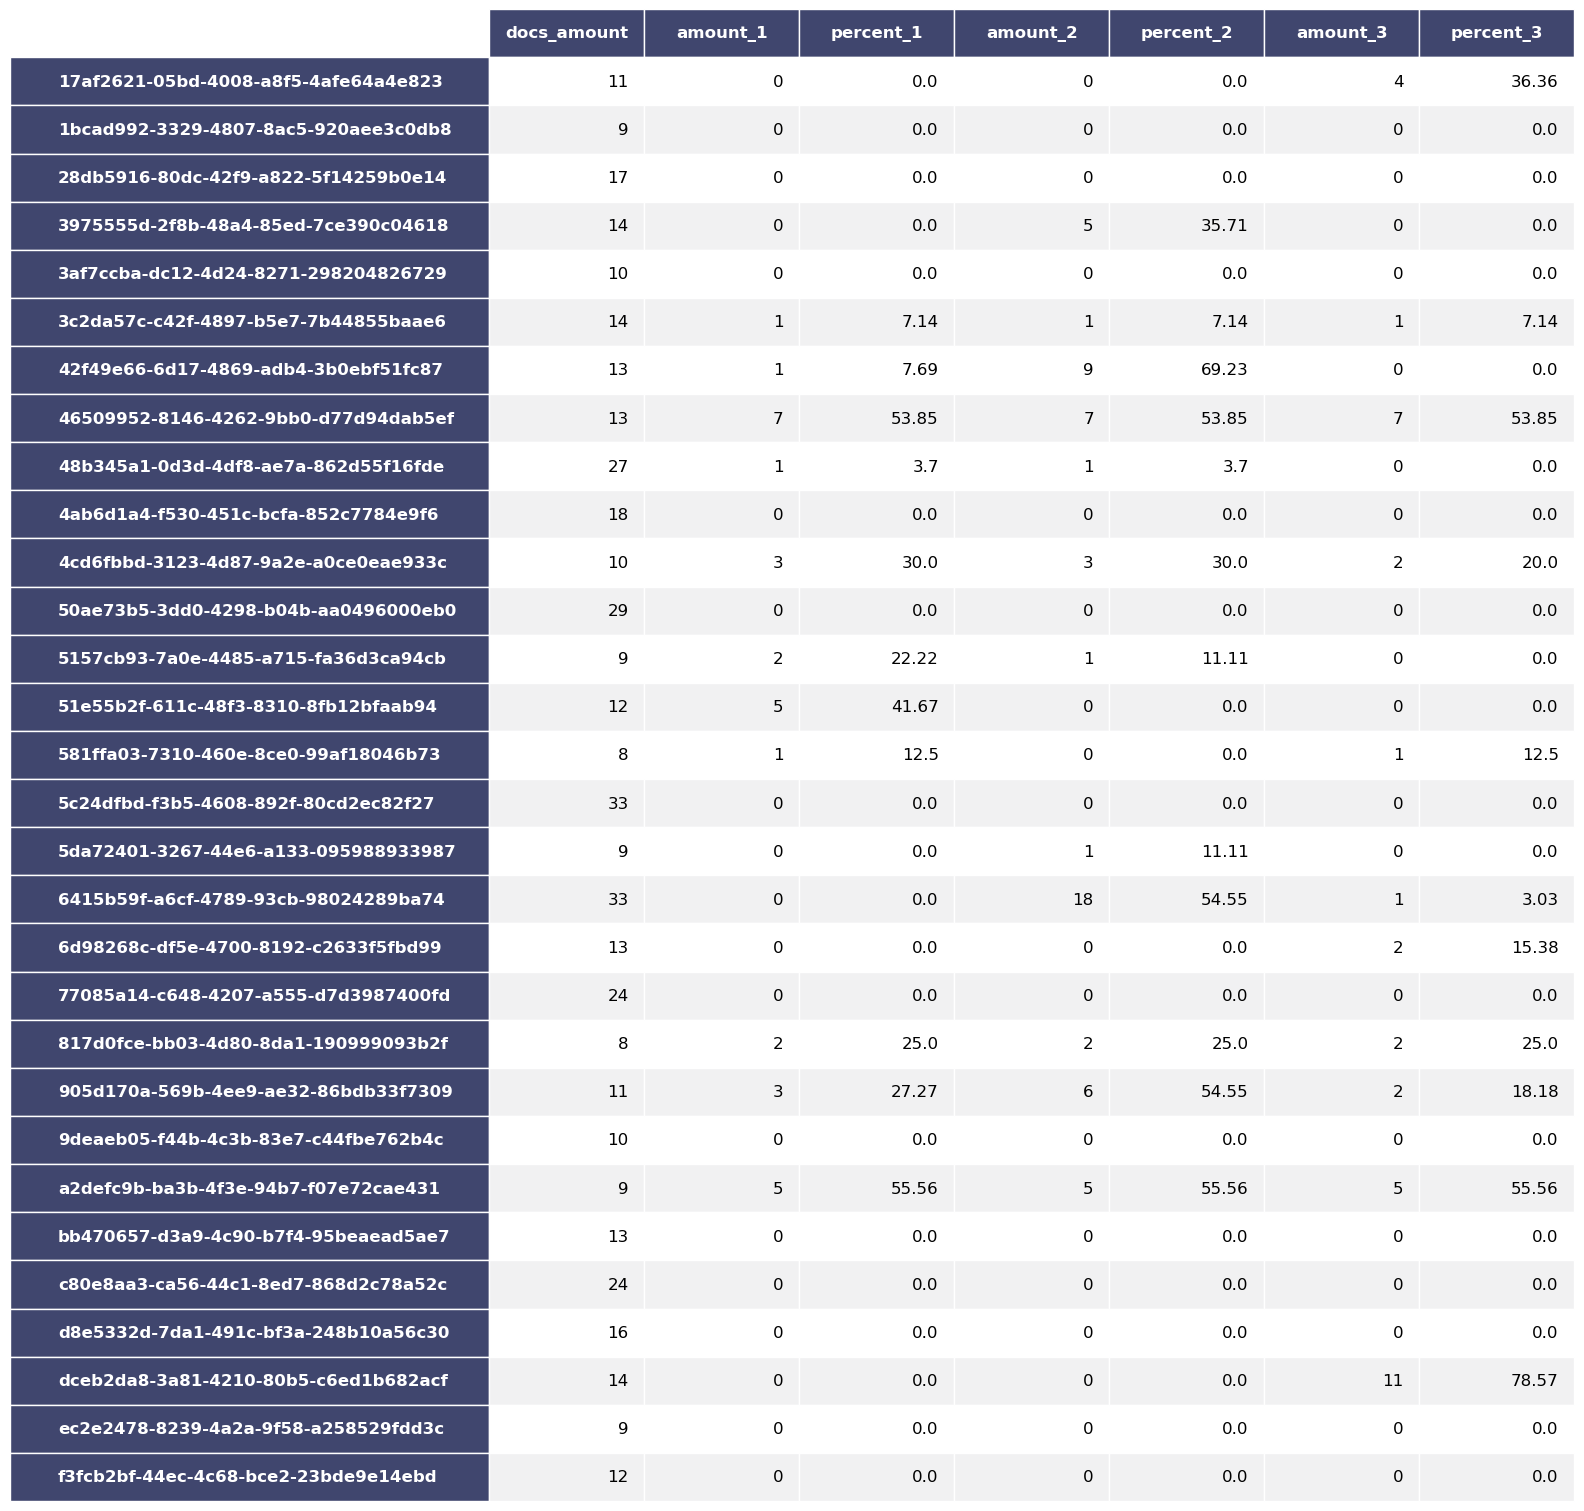

In [916]:
render_mpl_table(non_relevant_data, header_columns=0, col_width=2.0)

## Noise detection (OneCLassSVM)

In [190]:
def one_class_svm_for_corpus(data, all_data_labels, corpus_id, non_relevant_model):
    '''X_train, X_test, y_train, y_test = train_test_split(sent_tf_idf(data), all_data_labels, train_size=0.6, shuffle=True)
    y_train_1, y_train_2, y_train_3 = y_train[['label_1']].reset_index(drop=True), y_train[['label_2']].reset_index(drop=True), y_train[['label_3']].reset_index(drop=True)'''
    
    y = OneClassSVM(kernel='sigmoid', tol=1e-4).fit_predict(sent_tf_idf(data))
    #y = OneClassSVM(kernel='poly', degree=5, tol=1e-4, nu=0.08).fit_predict(sent_tf_idf(data))
    #print(y)
    count_non_relevant(list(y), corpus_id)
    returning_results = [M3(list(y), list(all_data_labels['label_1'])), M3(list(y), list(all_data_labels['label_2'])), M3(list(y), list(all_data_labels['label_3'])),
                         M3_precision_recall(list(y), list(all_data_labels['label_1'])), M3_precision_recall(list(y), list(all_data_labels['label_2'])),
                         M3_precision_recall(list(y), list(all_data_labels['label_3']))]
    return returning_results

In [704]:
def one_class_svm_spacy(data, test, corpus_id, non_relevant_model):
    docs = list(test['doc_id'])
    test_semantic = pd.DataFrame(columns=['doc1', 'doc2', 'similarity'])
            
    k = 0
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            test_semantic.at[k, 'doc1'] = docs[i]
            test_semantic.at[k, 'doc2'] = docs[j]
            k += 1
                    
    for i in range(test_semantic.shape[0]):
        doc1_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc1']].index[0]
        doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
            
        doc2_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc2']].index[0]
        doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
            
        test_semantic.at[i, 'similarity'] = doc1.similarity(doc2)
            
    sum_similarities = pd.DataFrame(columns=['sum_similarity'], index=docs)
    for doc_id in docs:
        part1 = test_semantic[test_semantic['doc1'] == doc_id]
        part2 = test_semantic[test_semantic['doc2'] == doc_id]
        curr_data = part1.append(part2, ignore_index=True)
        sum_similarities.at[doc_id, 'sum_similarity'] = curr_data['similarity'].sum()
            
    y = OneClassSVM(kernel='poly', degree=6, tol=1e-5).fit_predict((np.array(sum_similarities['sum_similarity']).reshape(-1, 1)))

    returning_results = [round(M3_relevant(list(y), list(test['label_1'])), 3), round(M3_relevant(list(y), list(test['label_2'])), 3), round(M3_relevant(list(y), list(test['label_3'])), 3),
                        M3_precision_recall(list(y), list(test['label_1'])), M3_precision_recall(list(y), list(test['label_2'])), 
                        M3_precision_recall(list(y), list(test['label_3']))]
    
    count_non_relevant(list(y), corpus_id)
    
    test_for_label_list = test.copy()
    test_for_label_list.insert(5, 'model_label', np.nan)
    test_for_label_list['model_label'] = list(y)
    all_corpus_labels_list.append(test_for_label_list)
    
    return returning_results

In [499]:
# смотрим семантическую близость попарно для всех документов в корпусе

def all_semantic_computing(corpus):
    docs = list(corpus['doc_id'])
    
    semantic = pd.DataFrame(columns=['doc1', 'doc2', 'similarity'])
            
    k = 0
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            semantic.at[k, 'doc1'] = docs[i]
            semantic.at[k, 'doc2'] = docs[j]
            k += 1
            
    for i in range(semantic.shape[0]):
        doc1_id = df_sovpad[df_sovpad['doc_id'] == semantic.at[i, 'doc1']].index[0]
        doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
            
        doc2_id = df_sovpad[df_sovpad['doc_id'] == semantic.at[i, 'doc2']].index[0]
        doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
            
        semantic.at[i, 'similarity'] = doc1.similarity(doc2)
        
    return semantic

In [678]:
# берем для каждого документа k_neigh соседей и считаем среднюю для них семантическую близость, это и есть семантическое расстояние для данного документа
# all_semantic_table = all_semantic_computing(corpus)

def k_semantic_neighbors(all_semantic_table, docs, k_neigh):  
    k_mean_similarities = pd.DataFrame(columns=['k_mean_similarity'], index=docs)
    
    k_neigh = len(docs) // 7
    
    for doc_id in docs:
        part1 = all_semantic_table[all_semantic_table['doc1'] == doc_id]
        part2 = all_semantic_table[all_semantic_table['doc2'] == doc_id]
        curr_data = part1.append(part2, ignore_index=True)
        curr_data = curr_data.sort_values(by=['similarity'], ascending=False)
        curr_data = curr_data.head(k_neigh)
        k_mean_similarities.at[doc_id, 'k_mean_similarity'] = curr_data['similarity'].mean()
        
    return k_mean_similarities

In [537]:
def half_cutting(k_similarities):
    original_index_order = list(k_similarities.index)
    k_similarities = k_similarities.sort_values(by=['k_mean_similarity'], ascending=False)
    half_size = k_similarities.shape[0] // 2 + k_similarities.shape[0] % 2
    
    upper_k_similarities = k_similarities.head(half_size)
    lower_k_similarities = k_similarities.tail(k_similarities.shape[0] - half_size)
    
    return upper_k_similarities, lower_k_similarities, original_index_order

In [1104]:
def modeling(k_mean_similarities):
    # return IsolationForest(n_estimators=1500).fit_predict((np.array(k_mean_similarities['k_mean_similarity']).reshape(-1, 1)))
    return OneClassSVM(kernel='poly', nu=0.1, degree=6, tol=1e-5).fit_predict((np.array(k_mean_similarities['k_mean_similarity']).reshape(-1, 1)))

In [569]:
def collecting_all_labels(lower_labels, lower_order, upper_k_similarities, original_index_order):
    all_labels = pd.DataFrame(columns=['label'], index=original_index_order)
    lower_pair = pd.DataFrame(columns=['label'], index=lower_order)
    for i in range(len(lower_order)):
        lower_pair.at[lower_order[i], 'label'] = lower_labels[i]
        
    for doc in original_index_order:
        if doc in list(upper_k_similarities.index):
            all_labels.at[doc, 'label'] = 1
        else:
            all_labels.at[doc, 'label'] = lower_pair.at[doc, 'label']
            
    return all_labels

In [558]:
def evaluating(y, test):
    return [round(M3_relevant(list(y), list(test['label_1'])), 3), round(M3_relevant(list(y), list(test['label_2'])), 3), round(M3_relevant(list(y), list(test['label_3'])), 3)]  

In [483]:
def one_class_svm_spacy_knn(data, test, corpus_id, k_neigh, non_relevant_model):
    docs = list(test['doc_id'])
    test_semantic = pd.DataFrame(columns=['doc1', 'doc2', 'similarity'])
            
    k = 0
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            test_semantic.at[k, 'doc1'] = docs[i]
            test_semantic.at[k, 'doc2'] = docs[j]
            k += 1
                    
    for i in range(test_semantic.shape[0]):
        doc1_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc1']].index[0]
        doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
            
        doc2_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc2']].index[0]
        doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
            
        test_semantic.at[i, 'similarity'] = doc1.similarity(doc2)
            
    k_mean_similarities = pd.DataFrame(columns=['k_mean_similarity'], index=docs)
    for doc_id in docs:
        part1 = test_semantic[test_semantic['doc1'] == doc_id]
        part2 = test_semantic[test_semantic['doc2'] == doc_id]
        curr_data = part1.append(part2, ignore_index=True)
        curr_data = curr_data.sort_values(by=['similarity'], ascending=False)
        curr_data = curr_data.head(k_neigh)
        k_mean_similarities.at[doc_id, 'k_mean_similarity'] = curr_data['similarity'].mean()
    y = OneClassSVM(kernel='poly', nu=0.1, degree=5, tol=1e-5).fit_predict((np.array(k_mean_similarities['k_mean_similarity']).reshape(-1, 1)))
    data_list.append(k_mean_similarities)
    '''    answers.append(y)
    gold1.append(list(test['label_1']))
    gold2.append(list(test['label_2']))
    gold3.append(list(test['label_3']))'''
    
    returning_results = [round(M3_relevant(list(y), list(test['label_1'])), 3), round(M3_relevant(list(y), list(test['label_2'])), 3), round(M3_relevant(list(y), list(test['label_3'])), 3),
                        M3_precision_recall(list(y), list(test['label_1'])), M3_precision_recall(list(y), list(test['label_2'])), 
                        M3_precision_recall(list(y), list(test['label_3']))]
    
    count_non_relevant(list(y), corpus_id)
    
    test_for_label_list = test.copy()
    test_for_label_list.insert(5, 'model_label', np.nan)
    test_for_label_list['model_label'] = list(y)
    all_corpus_labels_list.append(test_for_label_list)
    
    return returning_results

In [195]:
def count_non_relevant(model_answer, corpus_id):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
        
    non_relevant_model.at[corpus_id, 'amount_model'] = int(model_answer.count(-1))
    non_relevant_model.at[corpus_id, 'percent_model'] = round(model_answer.count(-1)/corpus.shape[0]*100, 2)

### Исследование разных измерений

In [ ]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    
    results = one_class_svm_spacy_knn(corpus, test, corpus_id, non_relevant_model)

In [118]:
all_corpus_labels_list = []

In [1105]:
M3_one_class = pd.DataFrame(columns=['1', '2', '3'], index=list(np.unique(data_doc_labels['corpus_id'])))
M3_one_class = M3_one_class[['1', '2', '3']]

In [205]:
asessors_comparing_M3 = pd.DataFrame(columns=['1_2', '2_1', '1_3', '3_1', '2_3', '3_2'], index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M3 = asessors_comparing_M3[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

In [701]:
non_relevant_model = non_relevant_data.copy()
non_relevant_model.insert(7, 'amount_model', np.nan)
non_relevant_model.insert(8, 'percent_model', np.nan)

In [229]:
test1 = []
test2 = []
test3 = []

In [230]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    test1.append(list(test['label_1']))
    test2.append(list(test['label_2']))
    test3.append(list(test['label_3']))

100%|██████████| 30/30 [00:00<00:00, 1074.68it/s]


In [500]:
all_semantic = []

In [501]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    all_semantic.append(all_semantic_computing(corpus))

100%|██████████| 30/30 [06:04<00:00, 12.16s/it]


In [517]:
min_ = 1
el = None
i_=0

for elem in all_semantic:
    for i in range(elem.shape[0]):
        if elem.at[i, 'similarity'] < min_:
            min_ = elem.at[i, 'similarity']
            el = elem
            i_ = i

In [518]:
min_

0.5716038013380591

In [583]:
M3_means_forest = []
M3_means_base_svm = []
M3_means_nu_svm = []
M3_means_nu01_svm = []

In [1106]:
non_relevant_docs = []
relevant_docs = []

In [1107]:
for elem, corpus_id in zip(all_semantic, corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    docs = list(corpus['doc_id'])
        
    k_mean_similarities = k_semantic_neighbors(elem, docs, 2)
    upper_k_similarities, lower_k_similarities, original_index_order = half_cutting(k_mean_similarities)
        
    lower_index_order = list(lower_k_similarities.index)
    lower_labels = modeling(lower_k_similarities)
        
    all_labels = collecting_all_labels(lower_labels, lower_index_order, upper_k_similarities, original_index_order)
    
    non_relevant_list = list(all_labels[all_labels['label'] == -1].index)
    non_relevant_docs.append(non_relevant_list)
    relevant_list = list(all_labels[all_labels['label'] != -1].index)
    relevant_docs.append(relevant_list)
        
    M3_one_class.at[corpus_id, '1'], M3_one_class.at[corpus_id, '2'], M3_one_class.at[corpus_id, '3'] = evaluating(all_labels['label'], test)
        
M3_mean = round((M3_one_class['1'].mean() + M3_one_class['2'].mean() + M3_one_class['3'].mean()) / 3, 3)
M3_means_base_svm_k.append(M3_mean)

In [586]:
M3_means_forest = [0.834, 0.85, 0.852, 0.856, 0.845, 0.847, 0.851, 0.845, 0.847, 0.847, 0.843, 0.846, 0.846, 0.844, 0.844, 0.843]

In [585]:
M3_means_base_svm = [0.803, 0.799, 0.807, 0.8, 0.798, 0.804, 0.792, 0.799, 0.79, 0.792, 0.794, 0.793, 0.792, 0.793, 0.793, 0.793]

In [587]:
M3_means_nu_svm = [0.901, 0.904, 0.908, 0.907, 0.909, 0.902, 0.898, 0.908, 0.909, 0.902, 0.904, 0.905, 0.905, 0.905, 0.903, 0.902]

In [604]:
M3_means_nu01_svm = [0.897, 0.899, 0.903, 0.907, 0.906, 0.899, 0.893, 0.904, 0.904, 0.898, 0.901, 0.901, 0.899, 0.902, 0.902, 0.898]

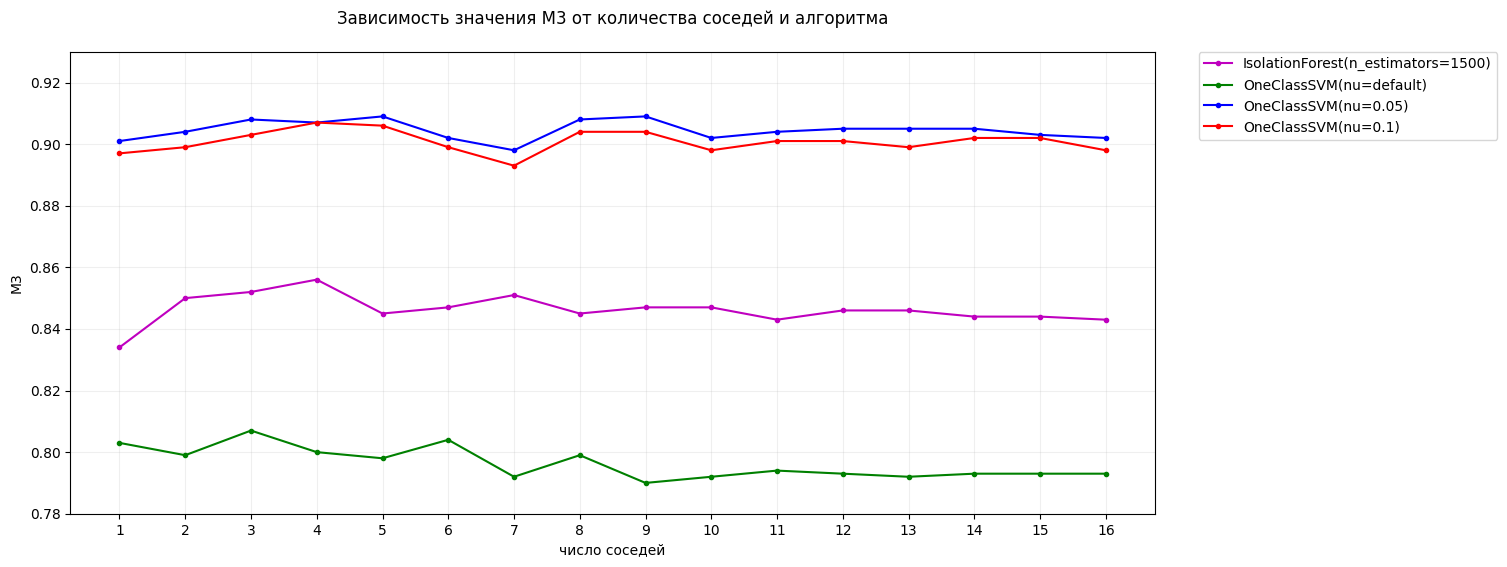

In [603]:
plt.figure(figsize=(14, 6))
plt.title('Зависимость значения M3 от количества соседей и алгоритма', pad=20)
plt.xlabel('число соседей')
plt.ylabel('М3')
plt.plot(k_s, M3_means_forest, 'm', marker='.', label='IsolationForest(n_estimators=1500)')
plt.plot(k_s, M3_means_base_svm, 'g', marker='.', label='OneClassSVM(nu=default)')
plt.plot(k_s, M3_means_nu_svm, 'b', marker='.', label='OneClassSVM(nu=0.05)')
plt.plot(k_s, M3_means_nu01_svm, 'r', marker='.', label='OneClassSVM(nu=0.1)')
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xticks(np.arange(1, 17))
plt.grid(linestyle="-", alpha=.2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.ylim((0.78, 0.93))
plt.show()

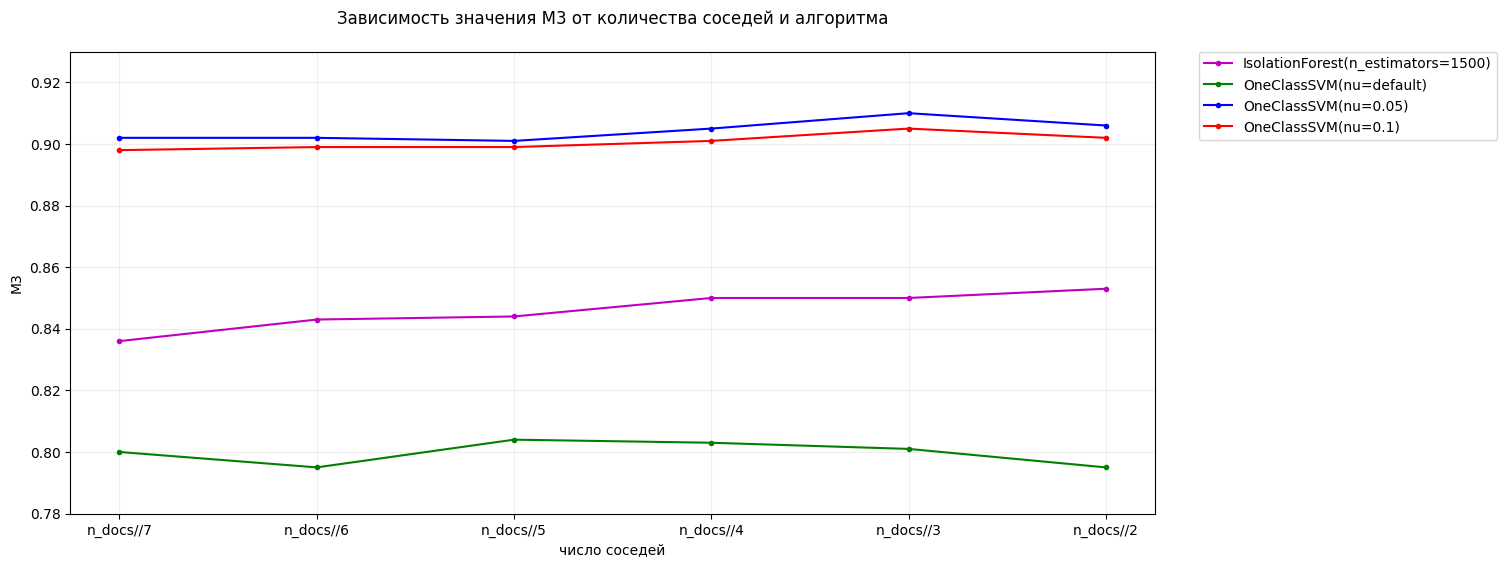

In [698]:
k_s = [1, 2, 3, 4, 5, 6]
plt.figure(figsize=(14, 6))
plt.title('Зависимость значения M3 от количества соседей и алгоритма', pad=20)
plt.xlabel('число соседей')
plt.ylabel('М3')
plt.plot(k_s, [0.836, 0.843, 0.844, 0.85, 0.85, 0.853], 'm', marker='.', label='IsolationForest(n_estimators=1500)')
plt.plot(k_s, [0.8, 0.795, 0.804, 0.803, 0.801, 0.795], 'g', marker='.', label='OneClassSVM(nu=default)')
plt.plot(k_s, [0.902, 0.902, 0.901, 0.905, 0.91, 0.906], 'b', marker='.', label='OneClassSVM(nu=0.05)')
plt.plot(k_s, [0.898, 0.899, 0.899, 0.901, 0.905, 0.902], 'r', marker='.', label='OneClassSVM(nu=0.1)')

plt.xticks(ticks=k_s, labels=['n_docs//7', 'n_docs//6', 'n_docs//5', 'n_docs//4', 'n_docs//3', 'n_docs//2'])
plt.grid(linestyle="-", alpha=.2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.ylim((0.78, 0.93))
plt.show()

In [705]:
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    
    #results = one_class_svm_for_corpus(corpus, test, corpus_id, non_relevant_model)
    results = one_class_svm_spacy(corpus, test, corpus_id, non_relevant_model)
    M3_one_class.at[corpus_id, '1'], M3_one_class.at[corpus_id, '2'], M3_one_class.at[corpus_id, '3'] = results[:3]
    
    '''precision_one_class.at[corpus_id, '1'] = results[3][0]
    precision_one_class.at[corpus_id, '2'] = results[4][0]
    precision_one_class.at[corpus_id, '3'] = results[5][0]
    
    recall_one_class.at[corpus_id, '1'] = results[3][1]
    recall_one_class.at[corpus_id, '2'] = results[4][1]
    recall_one_class.at[corpus_id, '3'] = results[5][1]'''
    
    '''asessors_comparing_M3.at[corpus_id, '1_2'] = round(M3_relevant(list(test['label_1']), list(test['label_2'])), 3)
    asessors_comparing_M3.at[corpus_id, '1_3'] = round(M3_relevant(list(test['label_1']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_3'] = round(M3_relevant(list(test['label_2']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_1'] = round(M3_relevant(list(test['label_2']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_1'] = round(M3_relevant(list(test['label_3']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_2'] = round(M3_relevant(list(test['label_3']), list(test['label_2'])), 3)'''
    # print('-----')

100%|██████████| 30/30 [05:46<00:00, 11.56s/it]


In [1160]:
total_results['M3_1'] = M3_one_class['1']
total_results['M3_2'] = M3_one_class['2']
total_results['M3_3'] = M3_one_class['3']

In [1161]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,0.952,0.952,0.824,0.947,0.000,0.750,0.625496,0.795181,0.652866,1.000000,0.333333,0.666667
1bcad992-3329-4807-8ac5-920aee3c0db8,0.941,0.941,0.941,0.000,0.222,0.286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,1.0,1.0,0.970,0.970,0.316,0.599746,0.594217,0.713677,0.666667,1.000000,1.000000
3975555d-2f8b-48a4-85ed-7ce390c04618,1.0,0.783,1.0,0.000,0.783,1.000,0.782609,0.525267,0.469108,0.333333,0.750000,0.600000
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,1.0,1.000,1.000,0.182,0.750826,0.644118,0.750826,1.000000,1.000000,1.000000
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.963,0.963,0.96,0.880,0.880,0.909,0.519708,0.557746,0.645833,0.600000,0.750000,0.750000
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.96,0.471,1.0,0.870,0.267,0.952,0.838384,0.668721,0.603104,1.000000,0.666667,1.000000
46509952-8146-4262-9bb0-d77d94dab5ef,0.667,0.667,0.667,0.800,0.800,0.800,0.603256,0.603256,0.609103,0.750000,0.750000,1.000000
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.941,0.939,0.958,0.529,0.500,0.552,0.666289,0.578348,0.714155,0.666667,0.750000,0.666667
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.971,0.971,0.966,0.000,0.970,1.000,0.872247,0.677589,0.691481,0.333333,0.750000,0.750000


In [1158]:
M3_one_class

,1,2,3
17af2621-05bd-4008-a8f5-4afe64a4e823,0.952,0.952,0.824
1bcad992-3329-4807-8ac5-920aee3c0db8,0.941,0.941,0.941
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,1.0,1.0
3975555d-2f8b-48a4-85ed-7ce390c04618,1.0,0.783,1.0
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,1.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.963,0.963,0.96
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.96,0.471,1.0
46509952-8146-4262-9bb0-d77d94dab5ef,0.667,0.667,0.667
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.941,0.939,0.958
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.971,0.971,0.966


In [1108]:
print('M3_1 mean: ', M3_one_class['1'].mean())
print('M3_2 mean: ', M3_one_class['2'].mean())
print('M3_2 mean: ', M3_one_class['3'].mean())
print('M3 mean: ', (M3_one_class['1'].mean() + M3_one_class['2'].mean() + M3_one_class['3'].mean()) / 3)

M3_1 mean:  0.9120333333333334
M3_2 mean:  0.8796333333333336
M3_2 mean:  0.9022999999999999
M3 mean:  0.897988888888889


In [459]:
nus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nu_comparing_statistics = pd.DataFrame(columns=list(nus), index=list(np.unique(data_doc_labels['corpus_id'])))

In [433]:
y_s = []

In [454]:
for nu in tqdm(nus):
    i=0
    for elem in data_list:
        y =  OneClassSVM(kernel='poly', degree=6, nu=nu).fit_predict((np.array(elem['k_mean_similarity']).reshape(-1, 1)))
        y_s.append(y)
        nu_comparing_statistics.at[corpus_ids_list[i], nu] = round((M3_relevant(list(y), test1[i]) + M3_relevant(list(y), test2[i]) + M3_relevant(list(y), test3[i]))/3, 3)
        i += 1

100%|██████████| 12/12 [00:00<00:00, 55.68it/s]


In [ ]:
for elem in data_list:
    elem = elem.sort_values(by=['k_mean_similarity'], ascending=True)

In [455]:
for column in nus:
    nu_comparing_statistics.at['Total', column] = round(nu_comparing_statistics[column].mean(), 3)

In [456]:
nu_comparing_statistics

,0.01,0.05,0.07,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90
17af2621-05bd-4008-a8f5-4afe64a4e823,0.87,0.87,0.87,0.87,0.828,0.804,0.804,0.727,0.639,0.537,0.353,0.194
1bcad992-3329-4807-8ac5-920aee3c0db8,1.0,1.0,1.0,1.0,0.875,0.875,0.714,0.615,0.5,0.5,0.2,NaN
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,1.0,0.969,0.969,0.901,0.78,0.734,0.684,0.507,0.436,0.305,0.113
3975555d-2f8b-48a4-85ed-7ce390c04618,0.928,0.928,0.928,0.896,0.879,0.86,0.778,0.71,0.663,0.58,0.3,0.3
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,1.0,1.0,0.947,0.889,0.75,0.667,0.667,0.462,0.462,0.182
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.921,0.921,0.921,0.921,0.884,0.834,0.812,0.712,0.643,0.48,0.383,0.147
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.81,0.81,0.81,0.79,0.774,0.75,0.693,0.663,0.631,0.476,0.331,NaN
46509952-8146-4262-9bb0-d77d94dab5ef,0.667,0.667,0.667,0.706,0.75,0.8,0.857,0.833,0.909,0.667,0.5,0.5
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.967,0.967,0.967,0.953,0.914,0.812,0.754,0.655,0.566,0.48,0.33,0.212
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,1.0,1.0,0.969,0.969,0.865,0.826,0.738,0.635,0.54,0.474,0.354,0.175


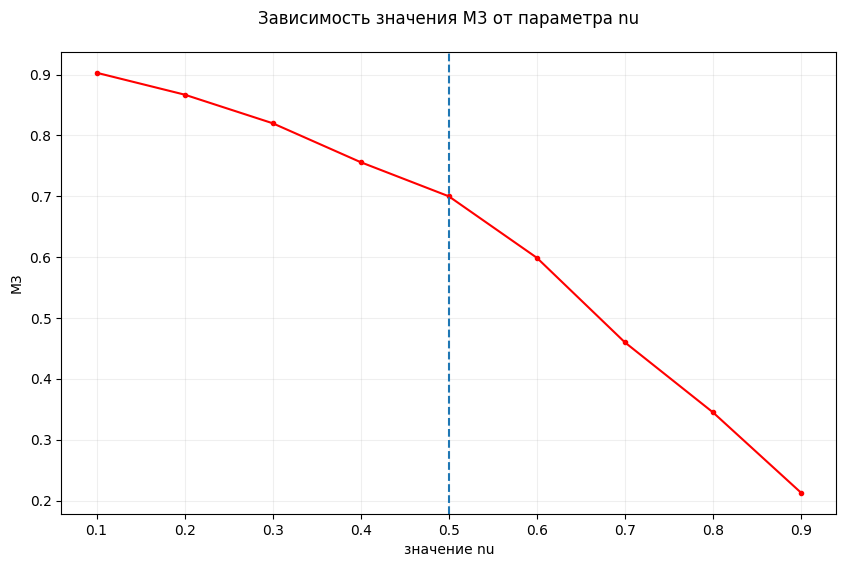

In [463]:
plt.figure(figsize=(10, 6))
plt.title('Зависимость значения M3 от параметра nu', pad=20)
plt.xlabel('значение nu')
plt.ylabel('М3')
plt.plot(nus, [0.903, 0.867, 0.82, 0.756, 0.7, 0.599, 0.46, 0.345, 0.213], 'r', marker='.')
plt.axvline(x=0.5, linestyle='--')
plt.grid(linestyle="-", alpha=.2)

plt.show()

In [217]:
non_relevant_model.insert(9, 'M3_1', np.nan)
non_relevant_model.insert(10, 'M3_2', np.nan)
non_relevant_model.insert(11, 'M3_3', np.nan)
non_relevant_model.insert(12, 'M3_mean', np.nan)

non_relevant_model['M3_1'] = M3_one_class['1']
non_relevant_model['M3_2'] = M3_one_class['2']
non_relevant_model['M3_3'] = M3_one_class['3']

In [218]:
cols = ['1', '2', '3']
non_relevant_model['M3_mean'] = round(M3_one_class[cols].sum(axis=1)/3, 3)

In [219]:
print('M3_1 mean: ', M3_one_class['1'].mean())
print('M3_2 mean: ', M3_one_class['2'].mean())
print('M3_2 mean: ', M3_one_class['3'].mean())
print('M3 mean: ', (M3_one_class['1'].mean() + M3_one_class['2'].mean() + M3_one_class['3'].mean()) / 3)

M3_1 mean:  0.7961666666666667
M3_2 mean:  0.7782999999999999
M3_2 mean:  0.7704666666666665
M3 mean:  0.7816444444444444


In [220]:
non_relevant_model

,docs_amount,amount_1,percent_1,amount_2,percent_2,amount_3,percent_3,amount_model,percent_model,M3_1,M3_2,M3_3,M3_mean
17af2621-05bd-4008-a8f5-4afe64a4e823,11,0,0.0,0,0.0,4,36.36,5.0,45.45,0.706,0.706,0.615,0.676
1bcad992-3329-4807-8ac5-920aee3c0db8,9,0,0.0,0,0.0,0,0.0,2.0,22.22,0.875,0.875,0.875,0.875
28db5916-80dc-42f9-a822-5f14259b0e14,17,0,0.0,0,0.0,0,0.0,4.0,23.53,0.867,0.867,0.857,0.864
3975555d-2f8b-48a4-85ed-7ce390c04618,14,0,0.0,5,35.71,0,0.0,7.0,50.00,0.667,0.75,0.588,0.668
3af7ccba-dc12-4d24-8271-298204826729,10,0,0.0,0,0.0,0,0.0,5.0,50.00,0.667,0.667,0.667,0.667
3c2da57c-c42f-4897-b5e7-7b44855baae6,14,1,7.14,1,7.14,1,7.14,6.0,42.86,0.667,0.667,0.632,0.655
42f49e66-6d17-4869-adb4-3b0ebf51fc87,13,1,7.69,9,69.23,0,0.0,5.0,38.46,0.8,0.667,0.706,0.724
46509952-8146-4262-9bb0-d77d94dab5ef,13,7,53.85,7,53.85,7,53.85,3.0,23.08,0.625,0.625,0.625,0.625
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27,1,3.7,1,3.7,0,0.0,8.0,29.63,0.844,0.837,0.837,0.839
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18,0,0.0,0,0.0,0,0.0,6.0,33.33,0.8,0.8,0.8,0.800


In [221]:
non_relevant_model['M3_mean'].mean()

0.7816666666666666

In [189]:
print('Средний процент нерелевантных:', non_relevant_model['percent_model'].mean())

Средний процент нерелевантных: 9.004


In [133]:
asessors_comparing_M3

,1_2,2_1,1_3,3_1,2_3,3_2
17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,1.0,0.778,0.778,0.778,0.778
1bcad992-3329-4807-8ac5-920aee3c0db8,1.0,1.0,1.0,1.0,1.0,1.0
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,1.0,1.0,1.0,1.0,1.0
3975555d-2f8b-48a4-85ed-7ce390c04618,0.783,0.783,1.0,1.0,0.737,0.737
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,1.0,1.0,1.0,1.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,1.0,1.0,0.917,0.917,0.917,0.917
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.5,0.5,0.952,0.952,0.308,0.308
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,1.0,1.0,1.0,1.0,1.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,0.98,0.98,1.0,1.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,1.0,1.0,1.0,1.0,1.0,1.0


In [165]:
print('1_2 mean: ', asessors_comparing_M3['1_2'].mean())
print('1_3 mean: ', asessors_comparing_M3['1_3'].mean())
print('2_3 mean: ', asessors_comparing_M3['2_3'].mean())
print('2_1 mean: ', asessors_comparing_M3['2_1'].mean())
print('3_1 mean: ', asessors_comparing_M3['3_1'].mean())
print('3_2 mean: ', asessors_comparing_M3['3_2'].mean())
print('M3 mean: ', (asessors_comparing_M3['1_2'].mean() + asessors_comparing_M3['1_3'].mean() + asessors_comparing_M3['2_3'].mean() +
                    asessors_comparing_M3['2_1'].mean() + asessors_comparing_M3['3_1'].mean() + asessors_comparing_M3['3_2'].mean()) / 6)

1_2 mean:  0.9362666666666667
1_3 mean:  0.9413999999999999
2_3 mean:  0.8994333333333332
2_1 mean:  0.9362666666666667
3_1 mean:  0.9413999999999999
3_2 mean:  0.8994333333333332
M3 mean:  0.9257


### Посмотрим на разные значения k

In [221]:
k_values = np.arange(1, 11)
k_comparing_statistics = pd.DataFrame(columns=list(k_values), index=list(np.unique(data_doc_labels['corpus_id'])))

In [222]:
for k in k_values:
    for corpus_id in tqdm(corpus_ids_list):
        corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
        test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
        
        results = one_class_svm_spacy_knn(corpus, test, corpus_id, k, non_relevant_model)
        M3_one_class.at[corpus_id, '1'], M3_one_class.at[corpus_id, '2'], M3_one_class.at[corpus_id, '3'] = results[:3]
        
    cols = ['1', '2', '3']
    k_comparing_statistics[k] = round(M3_one_class[cols].sum(axis=1)/3, 3)

100%|██████████| 30/30 [06:05<00:00, 12.19s/it]


In [233]:
for column in k_values:
    k_comparing_statistics.at['Total', column] = round(k_comparing_statistics[column].mean(), 3)

In [234]:
k_comparing_statistics

,1,2,3,4,5,6,7,8,9,10
17af2621-05bd-4008-a8f5-4afe64a4e823,0.850,0.870,0.808,0.808,0.850,0.870,0.850,0.850,0.870,0.870
1bcad992-3329-4807-8ac5-920aee3c0db8,0.941,0.941,0.941,0.941,0.941,1.000,0.941,0.941,0.941,0.941
28db5916-80dc-42f9-a822-5f14259b0e14,0.969,0.969,0.936,0.936,0.936,0.969,0.936,0.969,0.936,0.936
3975555d-2f8b-48a4-85ed-7ce390c04618,0.896,0.913,0.913,0.896,0.913,0.913,0.896,0.896,0.913,0.913
3af7ccba-dc12-4d24-8271-298204826729,0.947,0.947,1.000,0.947,0.947,0.947,1.000,1.000,0.947,0.947
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.930,0.930,0.921,0.921,0.921,0.921,0.877,0.921,0.877,0.877
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.797,0.790,0.790,0.790,0.768,0.768,0.790,0.790,0.790,0.797
46509952-8146-4262-9bb0-d77d94dab5ef,0.667,0.667,0.667,0.706,0.706,0.667,0.706,0.706,0.667,0.706
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.959,0.973,0.959,0.959,0.953,0.953,0.932,0.953,0.932,0.953
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.969,0.969,0.937,0.937,0.969,0.969,0.969,0.969,0.969,0.969


<AxesSubplot: >

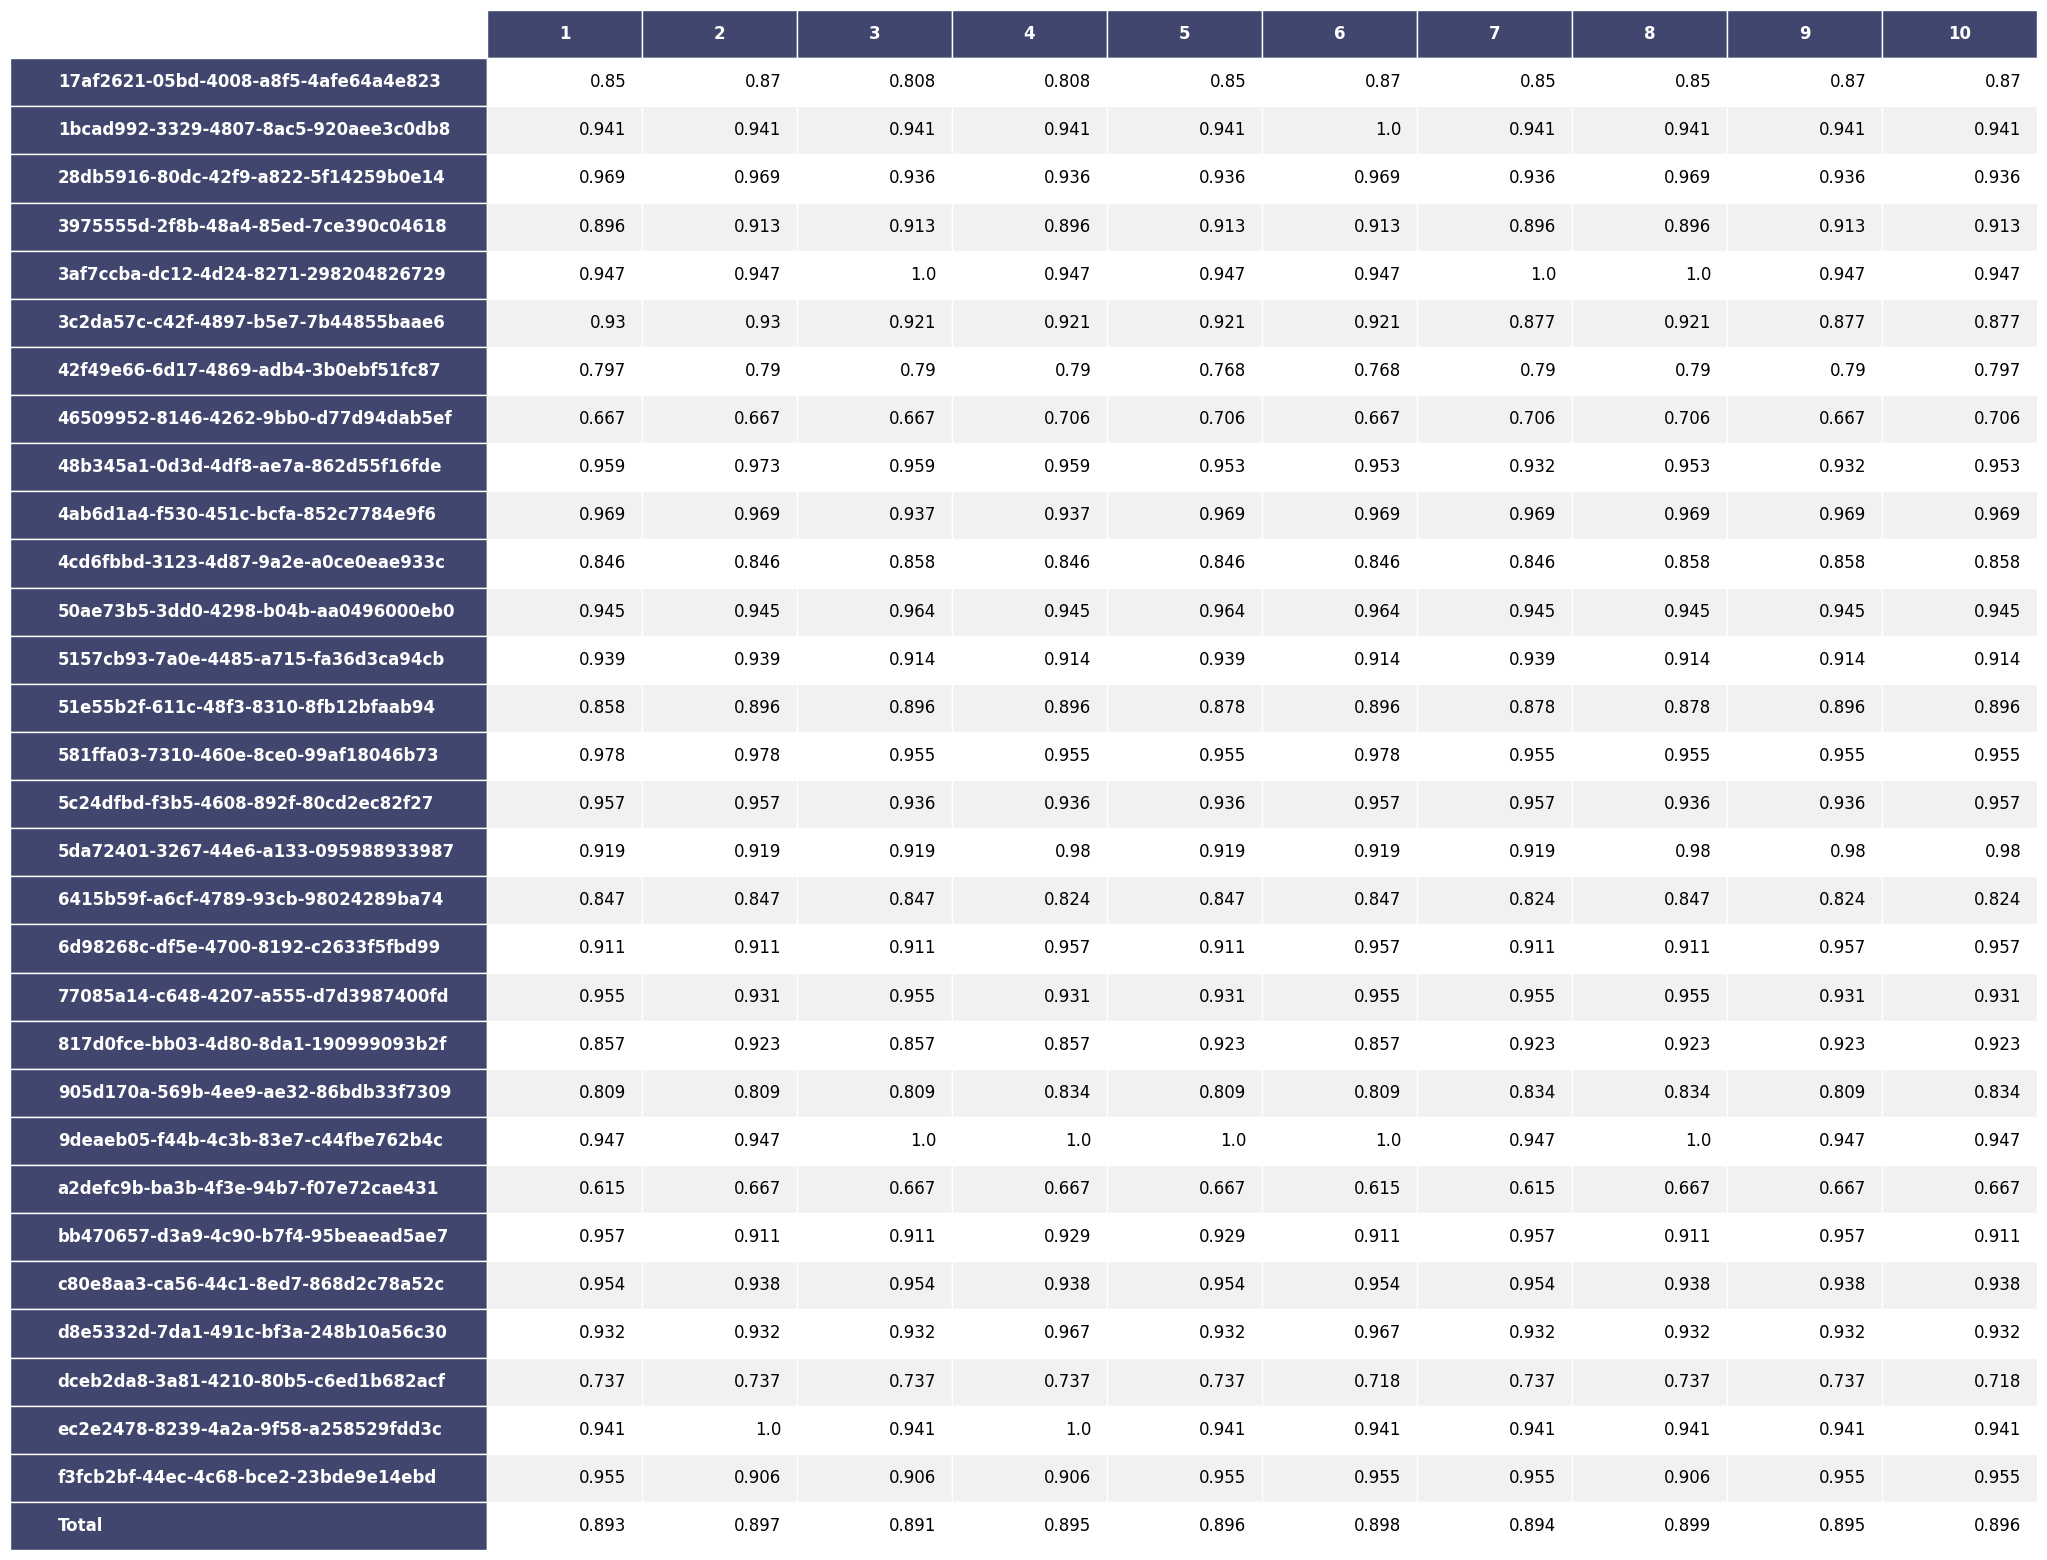

In [235]:
render_mpl_table(k_comparing_statistics, header_columns=0, col_width=2.0)

## Noise detection (Isolation Forest)

In [183]:
from sklearn.ensemble import IsolationForest

In [535]:
M3_one_class = pd.DataFrame(columns={'1', '2', '3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
M3_one_class = M3_one_class[['1', '2', '3']]

In [166]:
for corpus_id in (corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id].reset_index(drop=True)
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    
    y = IsolationForest(n_estimators=500).fit_predict(sent_tf_idf(corpus))
    
    M3_one_class.at[corpus_id, '1'] = M3(list(y), list(test['label_1']))
    M3_one_class.at[corpus_id, '2'] = M3(list(y), list(test['label_2']))
    M3_one_class.at[corpus_id, '3'] = M3(list(y), list(test['label_3']))
    

In [167]:
print('M3_1 mean: ', M3_one_class['1'].mean())
print('M3_2 mean: ', M3_one_class['2'].mean())
print('M3_2 mean: ', M3_one_class['3'].mean())
print('M3 mean: ', (M3_one_class['1'].mean() + M3_one_class['2'].mean() + M3_one_class['3'].mean()) / 3)

M3_1 mean:  0.10606060606060605
M3_2 mean:  0.1632395382395382
M3_2 mean:  0.13333333333333333
M3 mean:  0.1342111592111592


In [186]:
print('M3_1 mean: ', total_results['M3_1'].mean())
print('M3_2 mean: ', total_results['M3_2'].mean())
print('M3_2 mean: ', total_results['M3_3'].mean())
print('M3 mean: ', (total_results['M3_1'].mean() + total_results['M3_2'].mean() + total_results['M3_3'].mean()) / 3)

M3_1 mean:  1.1569610518284346
M3_2 mean:  1.1913659763993067
M3_2 mean:  1.1775988575761747
M3 mean:  1.1753086286013052


## Noise detection (spacy)

In [56]:
corpus_ids_list = list(np.unique(data_doc_labels['corpus_id'])) # список всех рассмтариваемых корпусов, всего 30 шт, айдишники взяты из исходного датасета(не из толоки)

In [57]:
import spacy
from sklearn.cluster import OPTICS
nlp = spacy.load("ru_core_news_sm")

### Тестируем на одном корпусе

In [48]:
test1 = data_doc_labels[data_doc_labels['corpus_id'] == corpus_ids_list[0]]
test1

,doc_id,corpus_id,label_1,label_2,label_3,workers
284,2558,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
312,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
314,2524,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
315,2525,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
316,2526,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
317,9104,17af2621-05bd-4008-a8f5-4afe64a4e823,0.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
318,9105,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
319,9106,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
320,9108,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
321,9109,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."


In [49]:
docs = list(test1['doc_id'])

In [50]:
test1_semantic = pd.DataFrame(columns={'doc1', 'doc2', 'similarity'})

In [51]:
k = 0
for i in range(len(docs)):
    for j in range(i+1, len(docs)):
        test1_semantic.at[k, 'doc1'] = docs[i]
        test1_semantic.at[k, 'doc2'] = docs[j]
        k += 1

In [52]:
for i in range(test1_semantic.shape[0]):
    doc1_id = df_sovpad[df_sovpad['doc_id'] == test1_semantic.at[i, 'doc1']].index[0]
    doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
    
    doc2_id = df_sovpad[df_sovpad['doc_id'] == test1_semantic.at[i, 'doc2']].index[0]
    doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
    
    test1_semantic.at[i, 'similarity'] = doc1.similarity(doc2)

In [53]:
test1_semantic = test1_semantic.sort_values(by=['similarity'])

In [54]:
test1_semantic.head(3)

,doc1,similarity,doc2
35,2526,0.822305,9105
48,9105,0.832726,9111
22,2524,0.854841,9105


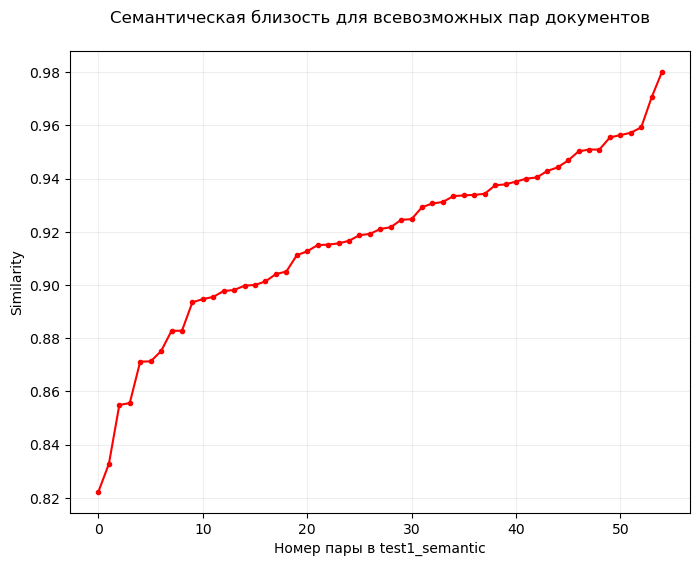

In [55]:
plt.figure(figsize=(8, 6))
plt.title('Семантическая близость для всевозможных пар документов', pad=20)
plt.xlabel('Номер пары в test1_semantic')
plt.ylabel('Similarity')
plt.plot(np.arange(test1_semantic.shape[0]), test1_semantic['similarity'], 'r', marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.show()

In [56]:
from sklearn.cluster import OPTICS

db = OPTICS(max_eps=0.5, min_samples=3)
db.fit(np.array(test1_semantic['similarity']).reshape(-1, 1))

OPTICS(max_eps=0.5, min_samples=3)

In [59]:
db.labels_

array([-1, -1, -1, -1,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,
        2, -1, -1, -1,  3,  3,  3,  3, -1,  4,  4,  4,  4, -1,  5,  5,  5,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,  9,
        9,  9,  9, -1])

In [57]:
test1_semantic.insert(3, 'label', 0)

In [58]:
test1_semantic['label'] = db.labels_

In [60]:
test1_semantic = test1_semantic.sort_index()

In [61]:
test1_semantic.head(5)

,doc1,similarity,doc2,label
0,2558,0.980231,2563,-1
1,2558,0.898084,2524,2
2,2558,0.950229,2525,8
3,2558,0.882782,2526,0
4,2558,0.905042,9104,-1


In [62]:
docs_labels = []

for doc in docs:
    doc_dict = {}
    for i in range(test1_semantic.shape[0]):
        if test1_semantic.at[i, 'doc1'] == doc or test1_semantic.at[i, 'doc2'] == doc:
            if test1_semantic.at[i, 'label'] not in doc_dict.keys():
                doc_dict[test1_semantic.at[i, 'label']] = 1
            else:
                doc_dict[test1_semantic.at[i, 'label']] += 1
    print(doc_dict)
    docs_labels.append(max(doc_dict, key=doc_dict.get))

{-1: 3, 2: 2, 8: 1, 0: 2, 4: 1, 1: 1}
{-1: 3, 8: 1, 6: 2, 2: 1, 7: 1, 3: 2}
{2: 2, -1: 2, 9: 1, 7: 2, 1: 1, 5: 1, 4: 1}
{8: 3, 9: 1, 7: 2, 3: 1, 0: 1, 4: 1, 6: 1}
{0: 1, -1: 2, 7: 3, 6: 1, 2: 2, 5: 1}
{-1: 2, 6: 2, 2: 1, 3: 2, 7: 1, 9: 1, 5: 1}
{0: 4, 2: 1, -1: 4, 1: 1}
{-1: 1, 6: 1, 1: 1, 4: 2, 2: 1, 7: 1, 0: 1, 9: 2}
{4: 1, 7: 4, 5: 1, 9: 3, 0: 1}
{1: 2, 3: 1, 4: 1, 6: 1, 2: 1, 5: 1, 9: 2, -1: 1}
{2: 1, 3: 2, 7: 2, 8: 1, 5: 1, -1: 2, 4: 1}


In [63]:
M3(docs_labels, list(test1['label_1']))

nan

In [64]:
M3(docs_labels, list(test1['label_2']))

nan

In [65]:
M3(docs_labels, list(test1['label_3']))

0.5714285714285715

### Тестируем на всем датасете

In [175]:
data_doc_labels

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
3,4013,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
4,9284,28db5916-80dc-42f9-a822-5f14259b0e14,9.0,3.0,0.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
...,...,...,...,...,...,...
447,1365,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
448,1071,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
449,6040,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,2.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
450,8353,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [1103]:
total_results = pd.DataFrame(columns=['M3_1', 'M3_2', 'M3_3'], index=list(np.unique(data_doc_labels['corpus_id'])))
total_results = total_results[['M3_1', 'M3_2', 'M3_3']]

In [311]:
asessors_comparing_M3 = pd.DataFrame(columns=['1_2', '1_3', '2_3'], index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M3 = asessors_comparing_M3[['1_2', '1_3', '2_3']]

In [177]:
non_relevant_model = pd.DataFrame(columns=['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3'], index=list(np.unique(data_doc_labels['corpus_id'])))
non_relevant_model = non_relevant_data[['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3']]

In [178]:
def find_most_popular_label(doc_labels_dict):
    most_popular_label = max(doc_labels_dict.values())
    max_values_dict = {key:value for key, value in doc_labels_dict.items() if value == most_popular_label}
    #print('most popular dict')
    #print(max_values_dict)
    if (-1) in max_values_dict.keys():
        return -1
    else:
        return max(doc_labels_dict, key=doc_labels_dict.get)

In [179]:
for corpus_id in tqdm(corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    docs = list(test['doc_id'])
    #print('Число док-ов в текущем корпусе: ', len(docs))
    test_semantic = pd.DataFrame(columns=['doc1', 'doc2', 'similarity'])
    
    k = 0
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            test_semantic.at[k, 'doc1'] = docs[i]
            test_semantic.at[k, 'doc2'] = docs[j]
            k += 1
            
    for i in range(test_semantic.shape[0]):
        doc1_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc1']].index[0]
        doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
    
        doc2_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc2']].index[0]
        doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
    
        test_semantic.at[i, 'similarity'] = doc1.similarity(doc2)
        
    #test_semantic = test_semantic.sort_values(by=['similarity'])

    optics = OPTICS(max_eps=1, min_samples=5)
    optics.fit(np.array(test_semantic['similarity']).reshape(-1, 1))
    
    test_semantic.insert(3, 'label', 0)
    test_semantic = test_semantic[['doc1', 'doc2', 'similarity', 'label']]
    test_semantic['label'] = optics.labels_
    test_semantic = test_semantic.sort_index()

    docs_labels = []

    for doc in docs:
        doc_dict = {}
        for i in range(test_semantic.shape[0]):
            if test_semantic.at[i, 'doc1'] == doc or test_semantic.at[i, 'doc2'] == doc:
                if test_semantic.at[i, 'label'] not in doc_dict.keys():
                    doc_dict[test_semantic.at[i, 'label']] = 1
                else:
                    doc_dict[test_semantic.at[i, 'label']] += 1
        #print(doc)
        #print(doc_dict)
        #print(find_most_popular_label(doc_dict))
        # break
        # docs_labels.append(max(doc_dict, key=doc_dict.get))
        docs_labels.append(find_most_popular_label(doc_dict))
        # print('-----')
    # print(docs_labels)
    
    count_non_relevant(docs_labels, corpus_id)
    
    '''total_results.at[corpus_id, 'M3_1'] = round(M3(docs_labels, list(test['label_1'])), 3)
    total_results.at[corpus_id, 'M3_2'] = round(M3(docs_labels, list(test['label_2'])), 3)
    total_results.at[corpus_id, 'M3_3'] = round(M3(docs_labels, list(test['label_3'])), 3)'''
    total_results.at[corpus_id, 'M3_1'] = M3_relevant(docs_labels, list(test['label_1']))
    total_results.at[corpus_id, 'M3_2'] = M3_relevant(docs_labels, list(test['label_2']))
    total_results.at[corpus_id, 'M3_3'] = M3_relevant(docs_labels, list(test['label_3']))
    
    '''asessors_comparing_M3.at[corpus_id, '1_2'] = round(M3(list(test['label_1']), list(test['label_2'])), 3)
    asessors_comparing_M3.at[corpus_id, '1_3'] = round(M3(list(test['label_1']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_3'] = round(M3(list(test['label_2']), list(test['label_3'])), 3)'''

100%|██████████| 30/30 [06:13<00:00, 12.46s/it]


In [182]:
optics.labels_

array([ 0,  2, -1,  6,  5,  0, -1,  6,  5,  3,  6,  3, -1,  0,  1,  2,  6,
       -1,  2,  2,  5,  1,  1, -1,  3,  6,  0,  2,  3,  4, -1,  2,  0, -1,
        0,  2, -1,  4, -1,  0,  4,  2,  2,  4,  4,  2,  5,  1,  3, -1,  5,
        6,  5,  1,  1,  0,  0, -1,  6,  6,  2,  4,  5,  1, -1, -1])

In [341]:
non_relevant_model = non_relevant_model[['docs_amount',	'amount_1',	'percent_1']]
non_relevant_model

,docs_amount,amount_1,percent_1
17af2621-05bd-4008-a8f5-4afe64a4e823,11,9,81.82
1bcad992-3329-4807-8ac5-920aee3c0db8,6,5,55.56
28db5916-80dc-42f9-a822-5f14259b0e14,17,13,76.47
3975555d-2f8b-48a4-85ed-7ce390c04618,14,4,28.57
3af7ccba-dc12-4d24-8271-298204826729,10,10,100.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,14,13,92.86
42f49e66-6d17-4869-adb4-3b0ebf51fc87,13,13,100.0
46509952-8146-4262-9bb0-d77d94dab5ef,13,8,61.54
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27,26,96.3
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18,14,77.78


In [342]:
print('Средний процент нерелевантных:', non_relevant_model['percent_1'].mean())

Средний процент нерелевантных: 69.17533333333333


In [75]:
# пример ПОЛНОГО ПРОТИВОРЕЧИЯ разметчиков

data_doc_labels[data_doc_labels['corpus_id'] == '17af2621-05bd-4008-a8f5-4afe64a4e823']

,doc_id,corpus_id,label_1,label_2,label_3,workers
284,2558,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
312,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
314,2524,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
315,2525,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
316,2526,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
317,9104,17af2621-05bd-4008-a8f5-4afe64a4e823,0.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
318,9105,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
319,9106,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
320,9108,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
321,9109,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."


#### Сравнение алгоритма и разметчиков

In [180]:
total_results

,M3_1,M3_2,M3_3
17af2621-05bd-4008-a8f5-4afe64a4e823,1.692308,1.692308,2.444444
1bcad992-3329-4807-8ac5-920aee3c0db8,1.384615,1.384615,1.384615
28db5916-80dc-42f9-a822-5f14259b0e14,1.619048,1.619048,1.684211
3975555d-2f8b-48a4-85ed-7ce390c04618,1.166667,1.473684,1.2
3af7ccba-dc12-4d24-8271-298204826729,0.0,0.0,0.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,2.0,2.0,2.0
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.0,0.0,0.0
46509952-8146-4262-9bb0-d77d94dab5ef,2.363636,2.363636,2.363636
48b345a1-0d3d-4df8-ae7a-862d55f16fde,2.0,2.0,0.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,1.636364,1.636364,1.666667


In [181]:
print('M3_1 mean: ', total_results['M3_1'].mean())
print('M3_2 mean: ', total_results['M3_2'].mean())
print('M3_2 mean: ', total_results['M3_3'].mean())

M3_1 mean:  1.4189346764346764
M3_2 mean:  1.4174381028328398
M3_2 mean:  1.4965264212861462


In [366]:
print('M3 mean: ', (total_results['M3_1'].mean() + total_results['M3_2'].mean() + total_results['M3_3'].mean()) / 3)

M3 mean:  -0.011811111111111118


#### Сравнение разметчиков друг с другом

In [79]:
asessors_comparing_M3

,1_2,1_3,2_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,0,0
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN
3975555d-2f8b-48a4-85ed-7ce390c04618,0,NaN,NaN
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN
3c2da57c-c42f-4897-b5e7-7b44855baae6,1.0,0,0
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.2,NaN,NaN
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,1.0,1.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,NaN,NaN
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN


In [80]:
print('1_2 mean: ', asessors_comparing_M3['1_2'].mean())
print('1_3 mean: ', asessors_comparing_M3['1_3'].mean())
print('2_3 mean: ', asessors_comparing_M3['2_3'].mean())

1_2 mean:  0.5722222222222223
1_3 mean:  0.509090909090909
2_3 mean:  0.40047846889952154


In [81]:
print('M3 mean: ', (asessors_comparing_M3['1_2'].mean() + asessors_comparing_M3['1_3'].mean() + asessors_comparing_M3['2_3'].mean()) / 3)

M3 mean:  0.4939305334042176


## Neutral (INFO)

Посмотрим количество нейтральных:

In [52]:
print('Количество нейтральных для первой разметки:', list(data_doc_labels['label_1']).count(0))
print('Количество нейтральных для второй разметки:', list(data_doc_labels['label_2']).count(0))
print('Количество нейтральных для третьей разметки:', list(data_doc_labels['label_3']).count(0))

Количество нейтральных для первой разметки: 110
Количество нейтральных для второй разметки: 55
Количество нейтральных для третьей разметки: 73


In [53]:
print('В процентах:', round(list(data_doc_labels['label_1']).count(0)/data_doc_labels.shape[0]*100, 2), ' %')
print('В процентах:', round(list(data_doc_labels['label_2']).count(0)/data_doc_labels.shape[0]*100, 2), ' %')
print('В процентах:', round(list(data_doc_labels['label_3']).count(0)/data_doc_labels.shape[0]*100, 2), ' %')

В процентах: 24.34  %
В процентах: 12.17  %
В процентах: 16.15  %


In [58]:
neutral_data = pd.DataFrame(columns=['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3'], index=list(np.unique(data_doc_labels['corpus_id'])))
neutral_data = neutral_data[['docs_amount', 'amount_1', 'percent_1', 'amount_2', 'percent_2', 'amount_3', 'percent_3']]

for corpus_id in (corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id].reset_index(drop=True)
    neutral_data.at[corpus_id, 'docs_amount'] = test.shape[0]
    
    neutral_data.at[corpus_id, 'amount_1'] = list(test['label_1']).count(0)
    neutral_data.at[corpus_id, 'amount_2'] = list(test['label_2']).count(0)
    neutral_data.at[corpus_id, 'amount_3'] = list(test['label_3']).count(0)
    
    neutral_data.at[corpus_id, 'percent_1'] = round(list(test['label_1']).count(0)/test.shape[0]*100, 2)
    neutral_data.at[corpus_id, 'percent_2'] = round(list(test['label_2']).count(0)/test.shape[0]*100, 2)
    neutral_data.at[corpus_id, 'percent_3'] = round(list(test['label_3']).count(0)/test.shape[0]*100, 2)

In [59]:
neutral_data

,docs_amount,amount_1,percent_1,amount_2,percent_2,amount_3,percent_3
17af2621-05bd-4008-a8f5-4afe64a4e823,11,1,9.09,11,100.0,0,0.0
1bcad992-3329-4807-8ac5-920aee3c0db8,9,9,100.0,0,0.0,2,22.22
28db5916-80dc-42f9-a822-5f14259b0e14,17,0,0.0,0,0.0,12,70.59
3975555d-2f8b-48a4-85ed-7ce390c04618,14,14,100.0,0,0.0,0,0.0
3af7ccba-dc12-4d24-8271-298204826729,10,0,0.0,0,0.0,9,90.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,14,0,0.0,0,0.0,1,7.14
42f49e66-6d17-4869-adb4-3b0ebf51fc87,13,0,0.0,0,0.0,0,0.0
46509952-8146-4262-9bb0-d77d94dab5ef,13,0,0.0,0,0.0,0,0.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,27,0,0.0,0,0.0,2,7.41
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,18,18,100.0,0,0.0,0,0.0


<AxesSubplot: >

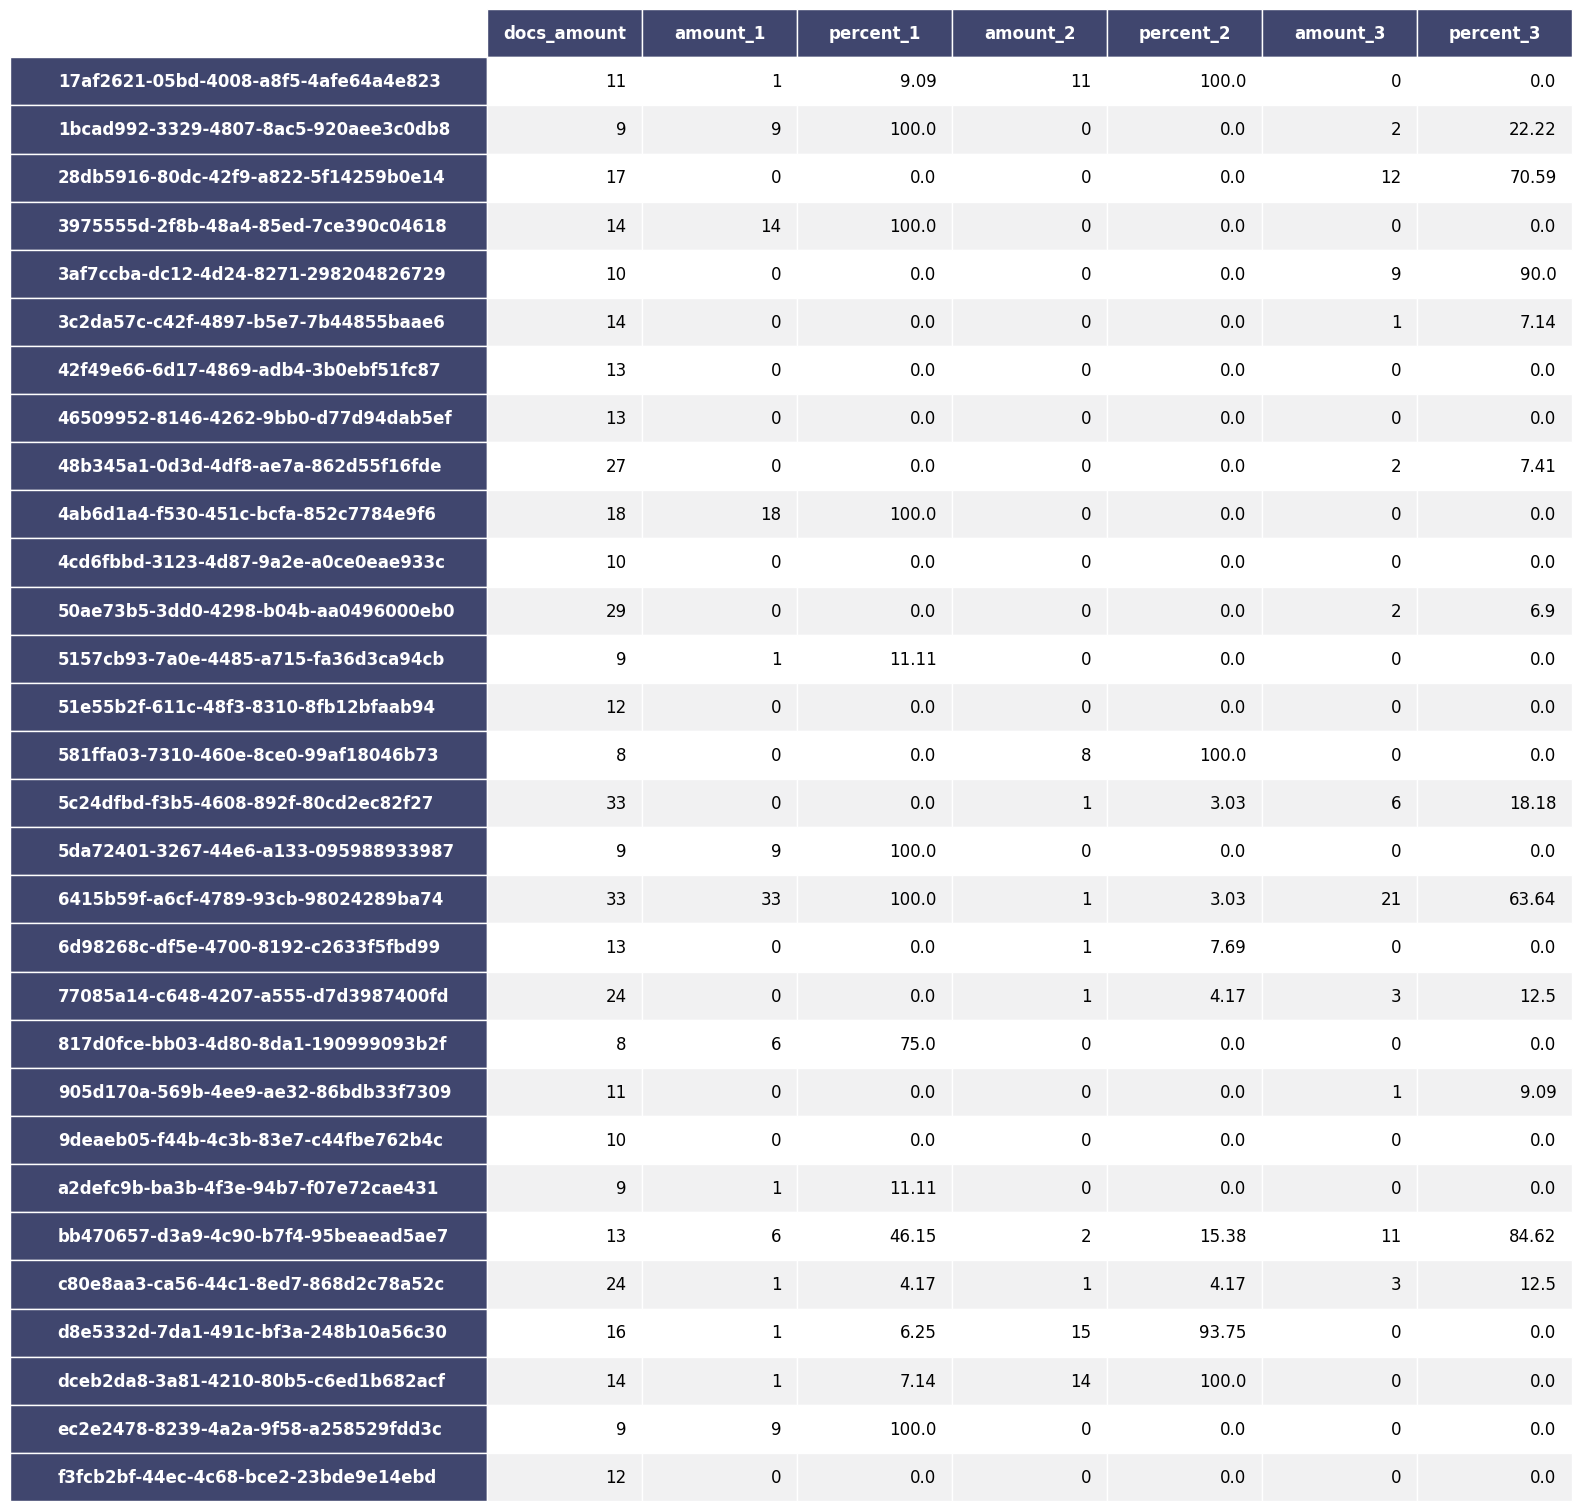

In [62]:
render_mpl_table(neutral_data, header_columns=0, col_width=2.0)

## Neutral detection

In [63]:
transform_to_dict(df_sovpad)

In [716]:
#проверка на нейтральность

def neutral_checking(data):
  doc_marks = [1] * data.shape[0]
  df_neutral_documents = data.iloc[0:0]
  df_not_neutral_documents = data.iloc[0:0]
  
  for i in range(data.shape[0]):
    if data.at[i, 'sentiment']['neg'] == {} and data.at[i, 'sentiment']['pos'] == {}:
      df_neutral_documents = pd.concat([df_neutral_documents, (data.loc[i]).to_frame().T])
      doc_marks[i] = 0
    else:
      df_not_neutral_documents = pd.concat([df_not_neutral_documents, (data.loc[i]).to_frame().T])
  return df_not_neutral_documents, df_neutral_documents, doc_marks

In [68]:
df_sovpad.iloc[62]

doc_id                                                         9307
text_group_id                  28db5916-80dc-42f9-a822-5f14259b0e14
domain                                                       ntv.ru
text              На юге Пакистана в районе города Готки сошел с...
sentiment         {'neg': {'Пакистана': 3, 'Готки': 2, 'Associat...
pub_date                                        2021-05-07 11:07:00
lemm_sentences    пассажирский поезд столкнуться юг пакистан дес...
sentences         ['Два пассажирских поезда столкнулись на юге П...
topics_info       {'topics': [{'lvl1': {'id': 'lvl1_проишествия'...
Name: 62, dtype: object

In [70]:
data_doc_labels[data_doc_labels['doc_id'] == 9307]

,doc_id,corpus_id,label_1,label_2,label_3,workers
16,9307,28db5916-80dc-42f9-a822-5f14259b0e14,1.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [711]:
def neutral_checking_separate_neg_pos(data):
    new_data = data[['doc_id','text_group_id']]
    new_data.insert(2, 'neg', '')
    new_data.insert(3, 'pos', '')
    for i in range(data.shape[0]):
        new_data.at[i, 'neg'] = data.at[i, 'sentiment']['neg']
        new_data.at[i, 'pos'] = data.at[i, 'sentiment']['pos']
    
    # new_data - датафрейм с разделенными neg и pos
    # Ниже смотрим, компенсирует ли суммарное количество негативных именованных сущностей суммарное количество положительных
    
    new_data.insert(4, 'label', 1)
    for i in range(new_data.shape[0]):
        if (new_data.at[i, 'neg'] == {} and new_data.at[i, 'pos'] == {}) or (sum(new_data.at[i, 'neg'].values()) == sum(new_data.at[i, 'pos'].values())):
            new_data.at[i, 'label'] = 0
        else:
            new_data.at[i, 'label'] = 1
    return new_data

In [1109]:
total_results.insert(3, 'M2_1', np.nan)
total_results.insert(4, 'M2_2', np.nan)
total_results.insert(5, 'M2_3', np.nan)

In [96]:
'''asessors_comparing_M2 = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M2 = asessors_comparing_M2[['1_2', '1_3', '2_3']]'''

In [269]:
asessors_comparing_M2 = pd.DataFrame(columns=['1_2', '2_1', '1_3', '3_1', '2_3', '3_2'], index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M2 = asessors_comparing_M2[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

In [1110]:
neutral_docs = []
not_neutral_docs = []

In [1111]:
for (corpus_id, i) in tqdm(zip(corpus_ids_list, np.arange(0, 30))):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    corpus = corpus[corpus['doc_id'].isin(relevant_docs[i])]
    
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    test = test[test['doc_id'].isin(relevant_docs[i])]
    
    #df_not_neutral_documents, df_neutral_documents, neutral_marks = neutral_checking(corpus.reset_index(drop=True))
    neutral_data = neutral_checking_separate_neg_pos(corpus.reset_index(drop=True))
    neutral_marks = list(neutral_data['label'])
    
    neutral_list = list(neutral_data[neutral_data['label'] == 0]['doc_id'])
    neutral_docs.append(neutral_list)

    not_neutral_list = list(neutral_data[neutral_data['label'] != 0]['doc_id'])
    not_neutral_docs.append(not_neutral_list)

    total_results.at[corpus_id, 'M2_1'] = round(M2_non_neutral(neutral_marks, list(test['label_1'])), 3)
    total_results.at[corpus_id, 'M2_2'] = round(M2_non_neutral(neutral_marks, list(test['label_2'])), 3)
    total_results.at[corpus_id, 'M2_3'] = round(M2_non_neutral(neutral_marks, list(test['label_3'])), 3)
    
    '''asessors_comparing_M2.at[corpus_id, '1_2'] = round(M2_non_neutral(list(test['label_1']), list(test['label_2'])), 3)
    asessors_comparing_M2.at[corpus_id, '1_3'] = round(M2_non_neutral(list(test['label_1']), list(test['label_3'])), 3)
    asessors_comparing_M2.at[corpus_id, '2_3'] = round(M2_non_neutral(list(test['label_2']), list(test['label_3'])), 3)
    asessors_comparing_M2.at[corpus_id, '2_1'] = round(M2_non_neutral(list(test['label_2']), list(test['label_1'])), 3)
    asessors_comparing_M2.at[corpus_id, '3_1'] = round(M2_non_neutral(list(test['label_3']), list(test['label_1'])), 3)
    asessors_comparing_M2.at[corpus_id, '3_2'] = round(M2_non_neutral(list(test['label_3']), list(test['label_2'])), 3)'''

30it [00:00, 154.23it/s]


### Сравнение алгоритма и разметчиков

In [1157]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,NaN,0.947,0.000,0.750,0.625496,0.795181,0.652866,1.000000,0.333333,0.666667
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,0.000,0.222,0.286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN,0.970,0.970,0.316,0.599746,0.594217,0.713677,0.666667,1.000000,1.000000
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,NaN,NaN,0.000,0.783,1.000,0.782609,0.525267,0.469108,0.333333,0.750000,0.600000
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN,1.000,1.000,0.182,0.750826,0.644118,0.750826,1.000000,1.000000,1.000000
3c2da57c-c42f-4897-b5e7-7b44855baae6,NaN,NaN,NaN,0.880,0.880,0.909,0.519708,0.557746,0.645833,0.600000,0.750000,0.750000
42f49e66-6d17-4869-adb4-3b0ebf51fc87,NaN,NaN,NaN,0.870,0.267,0.952,0.838384,0.668721,0.603104,1.000000,0.666667,1.000000
46509952-8146-4262-9bb0-d77d94dab5ef,NaN,NaN,NaN,0.800,0.800,0.800,0.603256,0.603256,0.609103,0.750000,0.750000,1.000000
48b345a1-0d3d-4df8-ae7a-862d55f16fde,NaN,NaN,NaN,0.529,0.500,0.552,0.666289,0.578348,0.714155,0.666667,0.750000,0.666667
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN,0.000,0.970,1.000,0.872247,0.677589,0.691481,0.333333,0.750000,0.750000


In [1113]:
print('M2_1 mean: ', total_results['M2_1'].mean())
print('M2_2 mean: ', total_results['M2_2'].mean())
print('M2_3 mean: ', total_results['M2_3'].mean())
print('M2 mean: ', (total_results['M2_1'].mean() + total_results['M2_2'].mean() + total_results['M2_3'].mean()) / 3)

M2_1 mean:  0.5966333333333333
M2_2 mean:  0.6502
M2_3 mean:  0.6885999999999999
M2 mean:  0.6451444444444444


### Сравнение разметчиков друг с другом

In [283]:
asessors_comparing_M2

,1_2,2_1,1_3,3_1,2_3,3_2
17af2621-05bd-4008-a8f5-4afe64a4e823,0,0,0.706,0.706,0,0
1bcad992-3329-4807-8ac5-920aee3c0db8,0,0,0,0,0.875,0.875
28db5916-80dc-42f9-a822-5f14259b0e14,1.0,1.0,0.4,0.4,0.4,0.4
3975555d-2f8b-48a4-85ed-7ce390c04618,0,0,0,0,0.737,0.737
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,0.182,0.182,0.182,0.182
3c2da57c-c42f-4897-b5e7-7b44855baae6,1.0,1.0,0.87,0.87,0.87,0.87
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.5,0.5,0.952,0.952,0.308,0.308
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,1.0,1.0,1.0,1.0,1.0
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,0.936,0.936,0.957,0.957
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0,0,0,0,1.0,1.0


In [284]:
print('1_2 mean: ', asessors_comparing_M2['1_2'].mean())
print('1_3 mean: ', asessors_comparing_M2['1_3'].mean())
print('2_3 mean: ', asessors_comparing_M2['2_3'].mean())
print('2_1 mean: ', asessors_comparing_M2['2_1'].mean())
print('3_1 mean: ', asessors_comparing_M2['3_1'].mean())
print('3_2 mean: ', asessors_comparing_M2['3_2'].mean())
print('M2 mean: ', (asessors_comparing_M2['1_2'].mean() + asessors_comparing_M2['1_3'].mean() + asessors_comparing_M2['2_3'].mean() +
                    asessors_comparing_M2['2_1'].mean() + asessors_comparing_M2['3_1'].mean() + asessors_comparing_M2['3_2'].mean()) / 6)

1_2 mean:  0.5707333333333333
1_3 mean:  0.5998999999999999
2_3 mean:  0.6938
2_1 mean:  0.5707333333333333
3_1 mean:  0.5998999999999999
3_2 mean:  0.6938
M2 mean:  0.6214777777777777


In [285]:
print('M2 mean: ', (asessors_comparing_M2['1_2'].mean() + asessors_comparing_M2['1_3'].mean() + asessors_comparing_M2['2_3'].mean()) / 3)

M2 mean:  0.6214777777777777


## Clustering clear data

In [106]:
df_sovpad.head(2)

,doc_id,text_group_id,domain,text,sentiment,pub_date,lemm_sentences,sentences,topics_info
0,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,kommersant.ru,"Президент США Джо Байден снова заявил, что Ваш...","{'neg': {}, 'pos': {'США': 1, 'Москвы': 1}}",2021-05-06 07:29:00,байден сша искать конфликт россия президент сш...,"['Байден: США не ищут конфликта с Россией.', '...","{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."
1,4908,77085a14-c648-4207-a555-d7d3987400fd,tsargrad.tv,Генсек НАТО испугался дружбы России и Белорусс...,"{'neg': {'НАТО': 2, 'России': 3, 'Белоруссии':...",2021-05-06 11:19:00,генсек нато испугаться дружба россия белорусси...,['Генсек НАТО испугался дружбы России и Белору...,"{'topics': [{'lvl1': {'id': 'lvl1_политика', '..."


In [95]:
data_doc_labels.head(2)

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [1114]:
total_results.insert(6, 'M1_1', np.nan)
total_results.insert(7, 'M1_2', np.nan)
total_results.insert(8, 'M1_3', np.nan)

total_results.insert(9, 'M4_1', np.nan)
total_results.insert(10, 'M4_2', np.nan)
total_results.insert(11, 'M4_3', np.nan)

In [108]:
'''asessors_comparing_M1 = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M1 = asessors_comparing_M1[['1_2', '1_3', '2_3']]

asessors_comparing_M4 = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M4 = asessors_comparing_M4[['1_2', '1_3', '2_3']]'''

In [ ]:
asessors_comparing_M1 = pd.DataFrame(columns={'1_2', '2_1', '1_3', '3_1', '2_3', '3_2'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M1 = asessors_comparing_M3[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

asessors_comparing_M4 = pd.DataFrame(columns={'1_2', '2_1', '1_3', '3_1', '2_3', '3_2'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M4 = asessors_comparing_M3[['1_2', '2_1', '1_3', '3_1', '2_3', '3_2']]

In [1123]:
opinion_labels = []

In [1124]:
for (corpus_id, i) in tqdm(zip(corpus_ids_list, np.arange(0, 30))):  
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    corpus = corpus[corpus['doc_id'].isin(not_neutral_docs[i])]
    
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    test = test[test['doc_id'].isin(not_neutral_docs[i])]
    
    if corpus.shape[0] == 0:
        labels_model = []
    elif corpus.shape[0] == 1:
        labels_model = [1]
    else:
        # tfidf = corpus_to_tf_idf(corpus.reset_index(drop=True))
        tfidf = sent_tf_idf(corpus.reset_index(drop=True))
        curr_kmeans_model = modeling_for_curr_corpus(tfidf)

        labels_model = curr_kmeans_model.fit_predict(tfidf)
    
    opinion_labels.append(labels_model)
    
    total_results.at[corpus_id, 'M1_1'] = M1(labels_model, list(test['label_1']))
    total_results.at[corpus_id, 'M1_2'] = M1(labels_model, list(test['label_2']))
    total_results.at[corpus_id, 'M1_3'] = M1(labels_model, list(test['label_3']))
    
    total_results.at[corpus_id, 'M4_1'] = M4(labels_model, list(test['label_1']))
    total_results.at[corpus_id, 'M4_2'] = M4(labels_model, list(test['label_2']))
    total_results.at[corpus_id, 'M4_3'] = M4(labels_model, list(test['label_3']))
    
    '''asessors_comparing_M1.at[corpus_id, '1_2'] = M1(list(test['label_1']), list(test['label_2']))
    asessors_comparing_M1.at[corpus_id, '1_3'] = M1(list(test['label_1']), list(test['label_3']))
    asessors_comparing_M1.at[corpus_id, '2_3'] = M1(list(test['label_2']), list(test['label_3']))
    
    asessors_comparing_M4.at[corpus_id, '1_2'] = M4(list(test['label_1']), list(test['label_2']))
    asessors_comparing_M4.at[corpus_id, '1_3'] = M4(list(test['label_1']), list(test['label_3']))
    asessors_comparing_M4.at[corpus_id, '2_3'] = M4(list(test['label_2']), list(test['label_3']))'''
    
    '''asessors_comparing_M3.at[corpus_id, '1_2'] = round(M3(list(test['label_1']), list(test['label_2'])), 3)
    asessors_comparing_M3.at[corpus_id, '1_3'] = round(M3(list(test['label_1']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_3'] = round(M3(list(test['label_2']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_1'] = round(M3(list(test['label_2']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_1'] = round(M3(list(test['label_3']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_2'] = round(M3(list(test['label_3']), list(test['label_2'])), 3)
    
    asessors_comparing_M3.at[corpus_id, '1_2'] = round(M3(list(test['label_1']), list(test['label_2'])), 3)
    asessors_comparing_M3.at[corpus_id, '1_3'] = round(M3(list(test['label_1']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_3'] = round(M3(list(test['label_2']), list(test['label_3'])), 3)
    asessors_comparing_M3.at[corpus_id, '2_1'] = round(M3(list(test['label_2']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_1'] = round(M3(list(test['label_3']), list(test['label_1'])), 3)
    asessors_comparing_M3.at[corpus_id, '3_2'] = round(M3(list(test['label_3']), list(test['label_2'])), 3)'''

30it [00:15,  1.93it/s]


In [1022]:
ids = random.sample(range(0, 30), 5)
ids

[24, 7, 9, 23, 5]

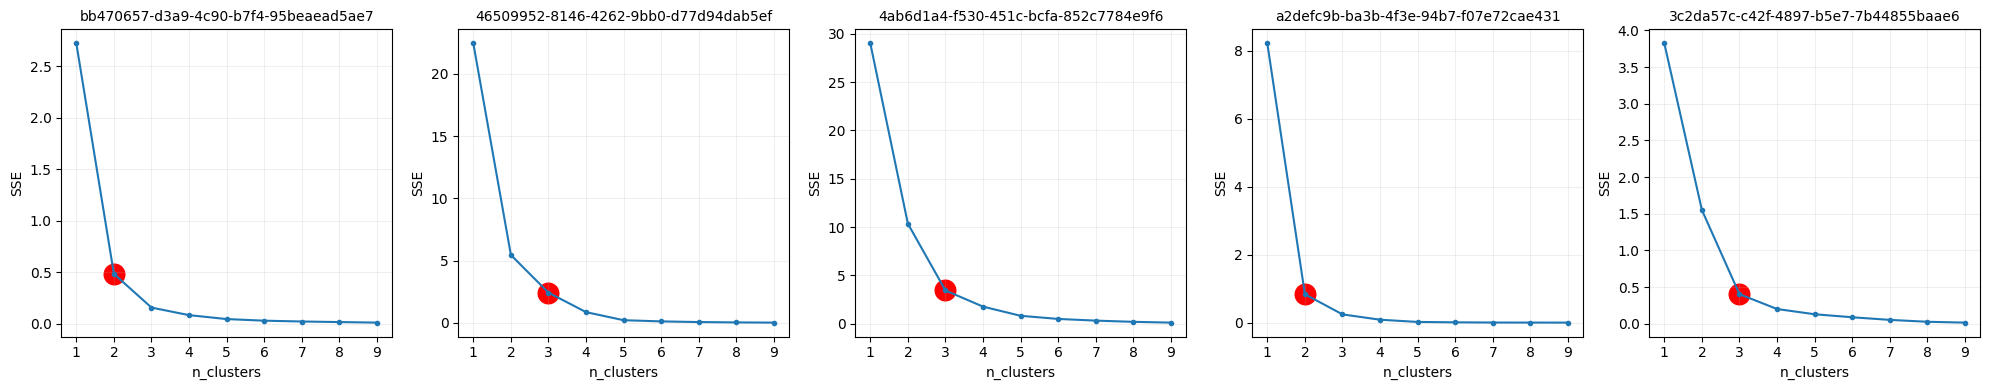

In [1023]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, j in zip(ids, [0, 1, 2, 3, 4]):
    ax[j].set_xlabel('n_clusters')
    ax[j].set_ylabel('SSE')
    ax[j].set_title(corpus_ids_list[i], fontsize=10)
    ax[j].plot(np.arange(1, 10, 1), inertias_plot[i], marker='.')
    ax[j].set_xticks(np.arange(1, 10))
    ax[j].scatter(n_cls[i], inertias_plot[i][n_cls[i]-1], marker='o', color='r', alpha=1, s=220)
    '''circle = plt.Circle((n_cls[i], inertias_plot[i][n_cls[i]-1]), radius=0.5, color='r')
    ax[j].add_artist( circle )'''
    ax[j].grid(linestyle="-", alpha=.2) 
plt.tight_layout()

### Сравнение алгоритма и разметчиков

In [754]:
total_results = round(total_results, 3)

In [1125]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,NaN,0.947,0.000,0.750,0.625496,0.795181,0.652866,1.000000,0.333333,0.666667
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,0.000,0.222,0.286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN,0.970,0.970,0.316,0.599746,0.594217,0.713677,0.666667,1.000000,1.000000
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,NaN,NaN,0.000,0.783,1.000,0.782609,0.525267,0.469108,0.333333,0.750000,0.600000
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN,1.000,1.000,0.182,0.750826,0.644118,0.750826,1.000000,1.000000,1.000000
3c2da57c-c42f-4897-b5e7-7b44855baae6,NaN,NaN,NaN,0.880,0.880,0.909,0.519708,0.557746,0.645833,0.600000,0.750000,0.750000
42f49e66-6d17-4869-adb4-3b0ebf51fc87,NaN,NaN,NaN,0.870,0.267,0.952,0.838384,0.668721,0.603104,1.000000,0.666667,1.000000
46509952-8146-4262-9bb0-d77d94dab5ef,NaN,NaN,NaN,0.800,0.800,0.800,0.603256,0.603256,0.609103,0.750000,0.750000,1.000000
48b345a1-0d3d-4df8-ae7a-862d55f16fde,NaN,NaN,NaN,0.529,0.500,0.552,0.666289,0.578348,0.714155,0.666667,0.750000,0.666667
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN,0.000,0.970,1.000,0.872247,0.677589,0.691481,0.333333,0.750000,0.750000


In [1121]:
print('M1_1 mean: ', total_results['M1_1'].mean())
print('M1_2 mean: ', total_results['M1_2'].mean())
print('M1_3 mean: ', total_results['M1_3'].mean())

print('M4_1 mean: ', total_results['M4_1'].mean())
print('M4_2 mean: ', total_results['M4_2'].mean())
print('M4_3 mean: ', total_results['M4_3'].mean())

M1_1 mean:  0.7161244585441441
M1_2 mean:  0.656289466532321
M1_3 mean:  0.6583895173856794
M4_1 mean:  0.7644444444444445
M4_2 mean:  0.7521428571428571
M4_3 mean:  0.8355555555555555


In [1126]:
print('M1 mean: ', (total_results['M1_1'].mean() + total_results['M1_2'].mean() + total_results['M1_3'].mean()) / 3)

print('M4 mean: ', (total_results['M4_1'].mean() + total_results['M4_2'].mean() + total_results['M4_3'].mean()) / 3)

M1 mean:  0.6755352640567045
M4 mean:  0.7840476190476191


In [1129]:
not_neutral_docs[4]

[7995, 7994, 7993, 7992, 7990, 7989, 7988, 7986, 7985, 7983]

In [1131]:
opinion_labels[4]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [1133]:
all_corpuses_model_labels = []

for (corpus_id, i) in tqdm(zip(corpus_ids_list, np.arange(0, 30))):
    corpus_labels = pd.DataFrame(columns=['doc_id', 'corpus_id', 'label'])
    
    # non relevant
    for nrv_doc in non_relevant_docs[i]:
        new_row = {'doc_id': nrv_doc, 'corpus_id': corpus_id, 'label': -1} 
        corpus_labels = corpus_labels.append(new_row, ignore_index=True)
        
    # neutral
    for neut_doc in neutral_docs[i]:
        new_row = {'doc_id': neut_doc, 'corpus_id': corpus_id, 'label': 0} 
        corpus_labels = corpus_labels.append(new_row, ignore_index=True)
        
    # opinion clusters
    for opin_id in range(len(not_neutral_docs[i])):
        opinion_labels
        new_row = {'doc_id': not_neutral_docs[i][opin_id], 'corpus_id': corpus_id, 'label': (opinion_labels[i][opin_id] + 1)} 
        corpus_labels = corpus_labels.append(new_row, ignore_index=True)

    all_corpuses_model_labels.append(corpus_labels)

30it [00:00, 58.88it/s]


In [1136]:
data_doc_labels[data_doc_labels['corpus_id'] == '17af2621-05bd-4008-a8f5-4afe64a4e823']

,doc_id,corpus_id,label_1,label_2,label_3,workers
284,2558,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
312,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
314,2524,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
315,2525,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
316,2526,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,-1.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
317,9104,17af2621-05bd-4008-a8f5-4afe64a4e823,0.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
318,9105,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
319,9106,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
320,9108,17af2621-05bd-4008-a8f5-4afe64a4e823,1.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."
321,9109,17af2621-05bd-4008-a8f5-4afe64a4e823,2.0,0.0,9.0,"[027b00cba0c5d7791dada81921a1ad70, be6dd5ed069..."


In [1137]:
cols = ['poles_model', 'neutral_model', 'non_relevant_model', 'poles_1', 'neutral_1', 'non_relevant_1', 'poles_2', 'neutral_2', 'non_relevant_2','poles_3', 'neutral_3', 'non_relevant_3']
poles_stat = pd.DataFrame(columns=cols, index=list(np.unique(data_doc_labels['corpus_id'])))
poles_stat = poles_stat[['poles_model', 'neutral_model', 'non_relevant_model', 'poles_1', 'neutral_1', 'non_relevant_1', 'poles_2', 'neutral_2', 'non_relevant_2','poles_3', 'neutral_3', 'non_relevant_3']]

In [1139]:
poles_number = []
neutral = []
non_relevant = []

for corpus_id in tqdm(corpus_ids_list):
    corpus = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    poles1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] > 0])))
    poles2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] > 0])))
    poles3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] > 0])))
    poles_number.append((poles1, poles2, poles3))
    
    neut1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] == 0])))
    neut2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] == 0])))
    neut3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] == 0])))
    neutral.append((neut1, neut2, neut3))
    
    nonr1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] < 0])))
    nonr2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] < 0])))
    nonr3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] < 0])))
    non_relevant.append((nonr1, nonr2, nonr3))

100%|██████████| 30/30 [00:00<00:00, 532.26it/s]


In [1150]:
all_corpuses_model_labels[1]

,doc_id,corpus_id,label
0,4095,1bcad992-3329-4807-8ac5-920aee3c0db8,-1
1,3273,1bcad992-3329-4807-8ac5-920aee3c0db8,0
2,4102,1bcad992-3329-4807-8ac5-920aee3c0db8,0
3,4097,1bcad992-3329-4807-8ac5-920aee3c0db8,0
4,4094,1bcad992-3329-4807-8ac5-920aee3c0db8,0
5,4092,1bcad992-3329-4807-8ac5-920aee3c0db8,0
6,3261,1bcad992-3329-4807-8ac5-920aee3c0db8,0
7,4087,1bcad992-3329-4807-8ac5-920aee3c0db8,0
8,4098,1bcad992-3329-4807-8ac5-920aee3c0db8,2


In [1151]:
model_poles = []
model_neutral = []
model_non_relev = []

for i in range(len(all_corpuses_model_labels)):
    corpus = all_corpuses_model_labels[i]
    
    p = len(list(np.unique(corpus['label'][corpus['label'] > 0])))
    if p > 0:
        poles_stat.at[corpus_ids_list[i], 'poles_model'] = p
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_model'] = '-'
    
    neut = len(list(np.unique(corpus['label'][corpus['label'] == 0])))
    if neut == 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_model'] = '-'
    else:
        poles_stat.at[corpus_ids_list[i], 'neutral_model'] = '+'
        
    nrv = len(list(np.unique(corpus['label'][corpus['label'] < 0])))
    if nrv == 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_model'] = '-'
    else:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_model'] = '+'

In [1146]:
for i in range(len(corpus_ids_list)):
    poles_stat.at
    
    
    if poles_number[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_1'] = poles_number[i][0]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_1'] = '-'
    if poles_number[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_2'] = poles_number[i][1]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_2'] = '-'
    if poles_number[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_3'] = poles_number[i][2]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_3'] = '-'
    
    if neutral[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_1'] = '+'  
    if neutral[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_2'] = '+'
    if neutral[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_3'] = '+'
        
    if non_relevant[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_1'] = '+'
    if non_relevant[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_2'] = '+'
    if non_relevant[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_3'] = '+'
        

<AxesSubplot: >

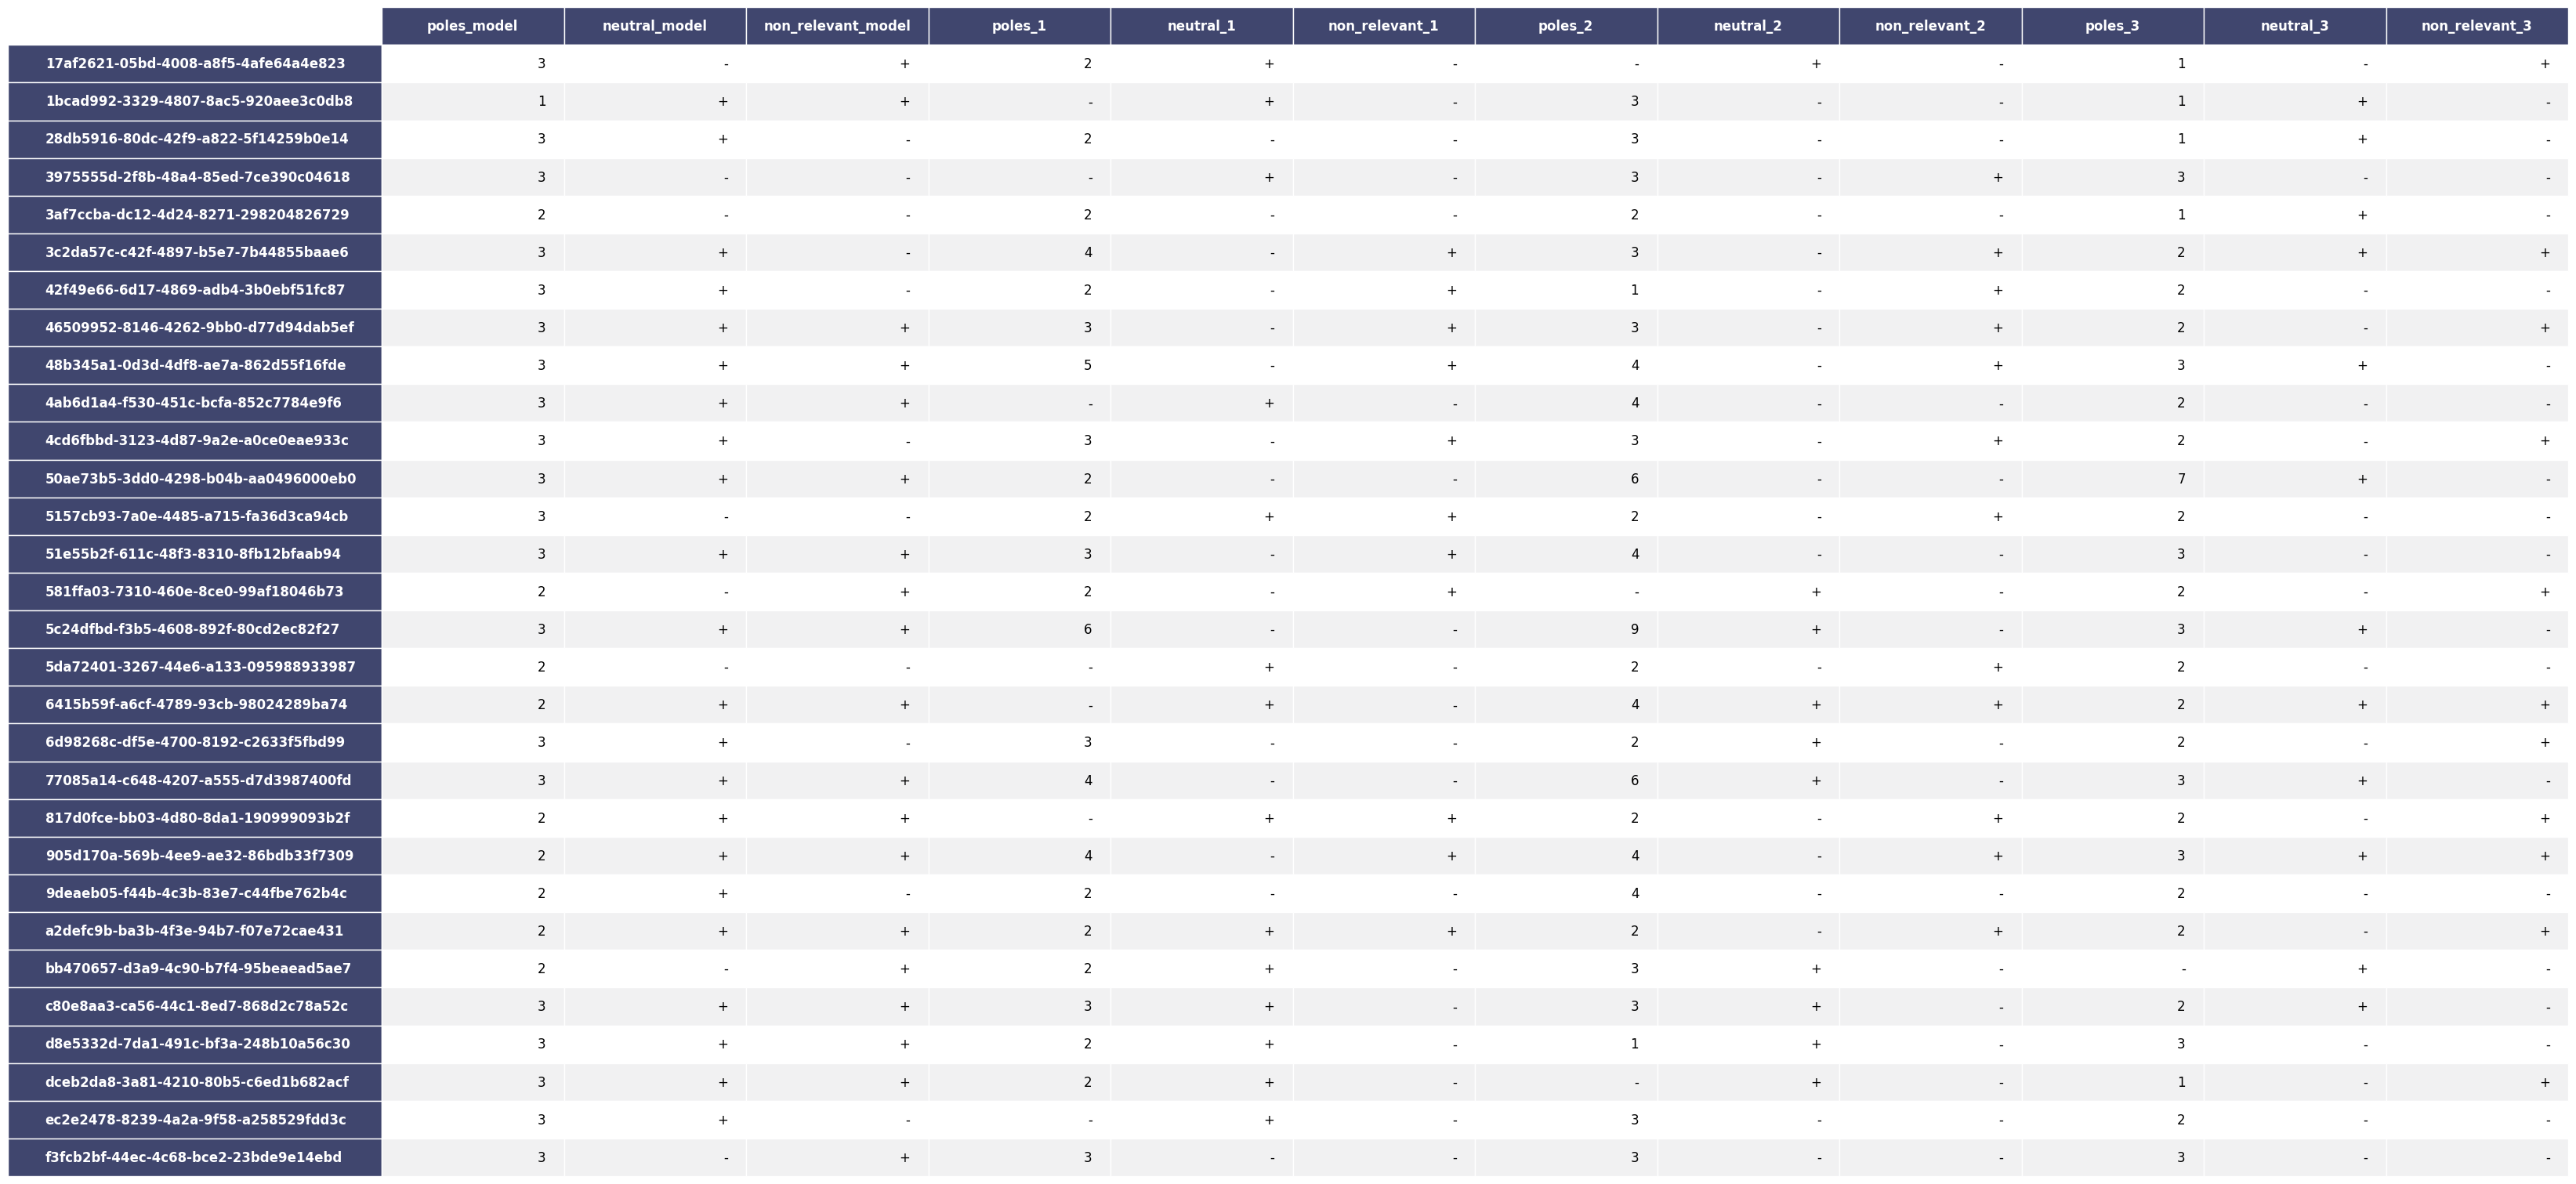

In [1155]:
poles_stat = poles_stat.fillna('-')
render_mpl_table(poles_stat, header_columns=0, col_width=3.0)

### Сравнение разметчиков друг с другом

In [114]:
asessors_comparing_M1

,1_2,1_3,2_3
17af2621-05bd-4008-a8f5-4afe64a4e823,0.726316,0.636364,0.698925
1bcad992-3329-4807-8ac5-920aee3c0db8,0.578947,0.791045,0.547009
28db5916-80dc-42f9-a822-5f14259b0e14,0.564012,0.572522,0.538177
3975555d-2f8b-48a4-85ed-7ce390c04618,0.503817,0.432,0.566757
3af7ccba-dc12-4d24-8271-298204826729,0.767619,1.0,0.767619
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.643654,0.561224,0.498034
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.644154,0.585799,0.600877
46509952-8146-4262-9bb0-d77d94dab5ef,0.871041,0.844406,0.828402
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.474339,0.596971,0.491446
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.768061,0.719368,0.618602


In [115]:
asessors_comparing_M4

,1_2,1_3,2_3
17af2621-05bd-4008-a8f5-4afe64a4e823,0.333333,0.666667,0.5
1bcad992-3329-4807-8ac5-920aee3c0db8,0.333333,0.5,0.666667
28db5916-80dc-42f9-a822-5f14259b0e14,0.666667,0.666667,1.0
3975555d-2f8b-48a4-85ed-7ce390c04618,0.25,0.2,0.8
3af7ccba-dc12-4d24-8271-298204826729,1.0,1.0,1.0
3c2da57c-c42f-4897-b5e7-7b44855baae6,0.8,1.0,0.8
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.666667,0.75,0.5
46509952-8146-4262-9bb0-d77d94dab5ef,1.0,0.75,0.75
48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,1.0,1.0
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,0.25,0.25,1.0


In [116]:
print('M1')
print('1_2 mean: ', asessors_comparing_M1['1_2'].mean())
print('1_3 mean: ', asessors_comparing_M1['1_3'].mean())
print('2_3 mean: ', asessors_comparing_M1['2_3'].mean())

print('M4')
print('1_2 mean: ', asessors_comparing_M4['1_2'].mean())
print('1_3 mean: ', asessors_comparing_M4['1_3'].mean())
print('2_3 mean: ', asessors_comparing_M4['2_3'].mean())

M1
1_2 mean:  0.6378412805933494
1_3 mean:  0.6661476152187846
2_3 mean:  0.6222575744661101
M4
1_2 mean:  0.6405555555555555
1_3 mean:  0.6961111111111111
2_3 mean:  0.7462698412698412


In [117]:
print('M1 mean: ', (asessors_comparing_M1['1_2'].mean() + asessors_comparing_M1['1_3'].mean() + asessors_comparing_M1['2_3'].mean()) / 3)
print('M4 mean: ', (asessors_comparing_M4['1_2'].mean() + asessors_comparing_M4['1_3'].mean() + asessors_comparing_M4['2_3'].mean()) / 3)

M1 mean:  0.6420821567594147
M4 mean:  0.6943121693121693


### Тест на корпусах при условии, что нейтральные и нерелвантные выделены идеально

In [107]:
data_doc_labels.head(3)

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [108]:
data_doc_labels["label_1"].isin([0, 45]).any()

True

In [109]:
corpuses_ids_without_neutral_and_nonrelevant = []

for corpus_id in tqdm(corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    if test['label_1'].isin([-1]).any() or test['label_2'].isin([-1]).any() or test['label_3'].isin([-1]).any():
        continue
    elif test['label_1'].isin([0]).any() or test['label_2'].isin([0]).any() or test['label_3'].isin([0]).any():
        continue
    else:
        corpuses_ids_without_neutral_and_nonrelevant.append(corpus_id)

100%|██████████| 30/30 [00:00<00:00, 1203.96it/s]


In [110]:
corpuses_ids_without_neutral_and_nonrelevant

['9deaeb05-f44b-4c3b-83e7-c44fbe762b4c',
 'f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd']

In [111]:
asessors_comparing_M1_small = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M1_small = asessors_comparing_M1[['1_2', '1_3', '2_3']]

asessors_comparing_M4_small = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M4_small = asessors_comparing_M4[['1_2', '1_3', '2_3']]

total_results_small = pd.DataFrame(columns={'M1_1', 'M1_2', 'M1_3', 'M4_1', 'M4_2', 'M4_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
total_results_small = total_results_small[['M1_1', 'M1_2', 'M1_3', 'M4_1', 'M4_2', 'M4_3']]

In [112]:
for corpus_id in tqdm(corpuses_ids_without_neutral_and_nonrelevant):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    tfidf = corpus_to_tf_idf(corpus.reset_index(drop=True))
    curr_kmeans_model = modeling_for_curr_corpus(tfidf)

    labels_model = curr_kmeans_model.fit_predict(tfidf)
    
    total_results_small.at[corpus_id, 'M1_1'] = M1(labels_model, list(test['label_1']))
    total_results_small.at[corpus_id, 'M1_2'] = M1(labels_model, list(test['label_2']))
    total_results_small.at[corpus_id, 'M1_3'] = M1(labels_model, list(test['label_3']))
    
    total_results_small.at[corpus_id, 'M4_1'] = M4(labels_model, list(test['label_1']))
    total_results_small.at[corpus_id, 'M4_2'] = M4(labels_model, list(test['label_2']))
    total_results_small.at[corpus_id, 'M4_3'] = M4(labels_model, list(test['label_3']))
    
    asessors_comparing_M1_small.at[corpus_id, '1_2'] = M1(list(test['label_1']), list(test['label_2']))
    asessors_comparing_M1_small.at[corpus_id, '1_3'] = M1(list(test['label_1']), list(test['label_3']))
    asessors_comparing_M1_small.at[corpus_id, '2_3'] = M1(list(test['label_2']), list(test['label_3']))
    
    asessors_comparing_M4_small.at[corpus_id, '1_2'] = M4(list(test['label_1']), list(test['label_2']))
    asessors_comparing_M4_small.at[corpus_id, '1_3'] = M4(list(test['label_1']), list(test['label_3']))
    asessors_comparing_M4_small.at[corpus_id, '2_3'] = M4(list(test['label_2']), list(test['label_3']))

100%|██████████| 2/2 [00:12<00:00,  6.42s/it]


In [113]:
print('M1_1 mean: ', total_results_small['M1_1'].mean())
print('M1_2 mean: ', total_results_small['M1_2'].mean())
print('M1_3 mean: ', total_results_small['M1_3'].mean())

print('M4_1 mean: ', total_results_small['M4_1'].mean())
print('M4_2 mean: ', total_results_small['M4_2'].mean())
print('M4_3 mean: ', total_results_small['M4_3'].mean())

M1_1 mean:  0.5835131894484412
M1_2 mean:  0.5110642098566045
M1_3 mean:  0.6035849056603773
M4_1 mean:  0.8333333333333333
M4_2 mean:  0.5833333333333333
M4_3 mean:  0.75


In [114]:
print('M1 mean: ', (total_results_small['M1_1'].mean() + total_results_small['M1_2'].mean() + total_results_small['M1_3'].mean()) / 3)

print('M4 mean: ', (total_results_small['M4_1'].mean() + total_results_small['M4_2'].mean() + total_results_small['M4_3'].mean()) / 3)

M1 mean:  0.5660541016551409
M4 mean:  0.7222222222222222


In [115]:
print('M1 mean: ', (asessors_comparing_M1_small['1_2'].mean() + asessors_comparing_M1_small['1_3'].mean() + asessors_comparing_M1_small['2_3'].mean()) / 3)
print('M4 mean: ', (asessors_comparing_M4_small['1_2'].mean() + asessors_comparing_M4_small['1_3'].mean() + asessors_comparing_M4_small['2_3'].mean()) / 3)

M1 mean:  0.6420821567594147
M4 mean:  0.6943121693121693


### Исследования зависимости качества от количества документов в корпусе

In [1156]:
total_results.head(2)

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,NaN,0.947,0.000,0.750,0.625496,0.795181,0.652866,1.0,0.333333,0.666667
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,0.000,0.222,0.286,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [1162]:
quality_amount_correlation = total_results[['M1_1',	'M1_2',	'M1_3',	'M4_1',	'M4_2',	'M4_3']]

In [1163]:
quality_amount_correlation.insert(6, 'M1', np.nan)
quality_amount_correlation.insert(7, 'M4', np.nan)
quality_amount_correlation.insert(8, 'n_docs', np.nan)

In [1164]:
for corpus_id in tqdm(corpus_ids_list):
    test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    docs = list(test['doc_id'])
    quality_amount_correlation.at[corpus_id, 'n_docs'] = len(docs)
    quality_amount_correlation.at[corpus_id, 'M1'] = (quality_amount_correlation.at[corpus_id, 'M1_1'] + 
                                                      quality_amount_correlation.at[corpus_id, 'M1_2'] + 
                                                      quality_amount_correlation.at[corpus_id, 'M1_3'])/3
    quality_amount_correlation.at[corpus_id, 'M4'] = (quality_amount_correlation.at[corpus_id, 'M4_1'] + 
                                                      quality_amount_correlation.at[corpus_id, 'M4_2'] + 
                                                      quality_amount_correlation.at[corpus_id, 'M4_3'])/3

100%|██████████| 30/30 [00:00<00:00, 1367.11it/s]


In [1165]:
quality_amount_correlation.head(2)

,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3,M1,M4,n_docs
17af2621-05bd-4008-a8f5-4afe64a4e823,0.625496,0.795181,0.652866,1.0,0.333333,0.666667,0.691181,0.666667,11.0
1bcad992-3329-4807-8ac5-920aee3c0db8,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,9.0


In [1166]:
quality_amount_correlation = quality_amount_correlation.sort_values(by=['n_docs'])

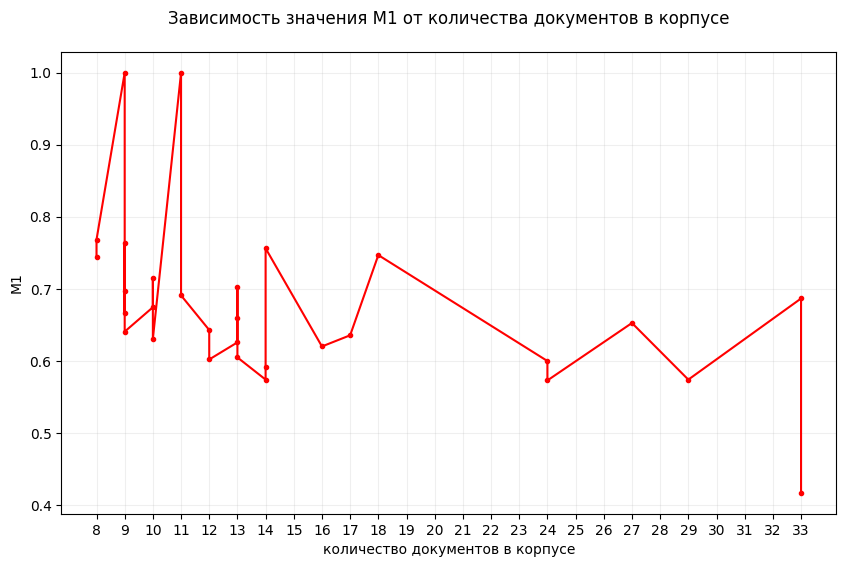

In [1167]:
plt.figure(figsize=(10, 6))
plt.title('Зависимость значения M1 от количества документов в корпусе', pad=20)
plt.xlabel('количество документов в корпусе')
plt.xticks(np.arange(8, 34, 1))
plt.ylabel('М1')
plt.plot(quality_amount_correlation['n_docs'], quality_amount_correlation['M1'], 'r', marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.show()

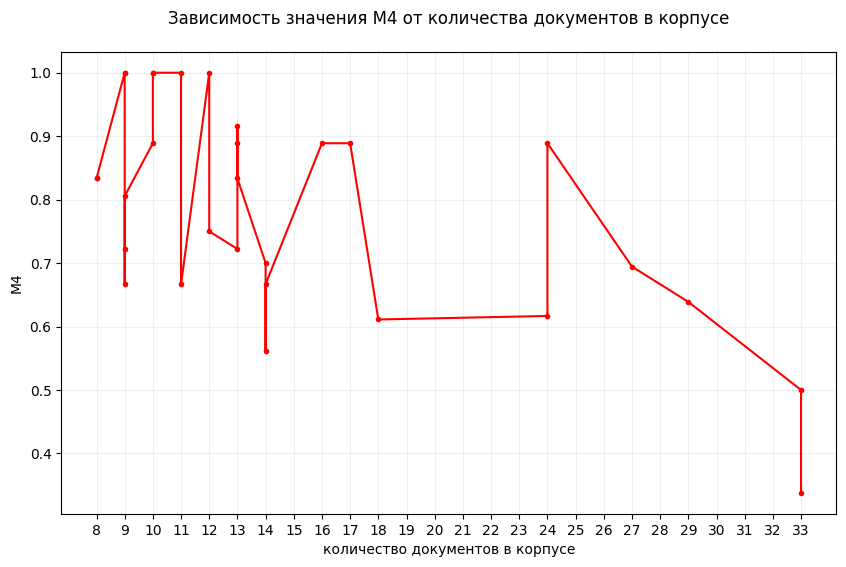

In [1168]:
plt.figure(figsize=(10, 6))
plt.title('Зависимость значения M4 от количества документов в корпусе', pad=20)
plt.xlabel('количество документов в корпусе')
plt.ylabel('М4')
plt.xticks(np.arange(8, 34, 1))
plt.plot(quality_amount_correlation['n_docs'], quality_amount_correlation['M4'], 'r', marker='.')
plt.grid(linestyle="-", alpha=.2)
plt.show()

# Результат (значения метрик)

In [237]:
total_results

,M3_1,M3_2,M3_3,M2_1,M2_2,M2_3,M1_1,M1_2,M1_3,M4_1,M4_2,M4_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,0.461538,0.000,0.000,NaN,0.726,1.000,0.699,0.333,1.000,0.500
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN,0.714,NaN,0.286,1.000,0.667,0.839,1.000,0.333,0.500
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN,NaN,NaN,0.000,0.680,0.604,0.716,0.500,0.333,0.333
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,0,NaN,0.000,NaN,NaN,1.000,0.504,0.432,1.000,0.250,0.200
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN,NaN,NaN,0.000,0.901,0.734,0.901,0.500,0.500,0.500
3c2da57c-c42f-4897-b5e7-7b44855baae6,0,0,0.142857,NaN,NaN,0.000,0.515,0.559,0.515,0.200,0.250,0.200
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.142857,0.818182,NaN,NaN,NaN,NaN,0.766,0.729,0.580,0.333,0.500,0.250
46509952-8146-4262-9bb0-d77d94dab5ef,0.533333,0.533333,0.533333,NaN,NaN,NaN,0.568,0.543,0.580,0.250,0.250,0.333
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.074074,0.074074,NaN,NaN,NaN,0.125,0.527,0.446,0.764,0.167,0.167,0.167
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN,0.105,NaN,NaN,1.000,0.768,0.719,1.000,0.250,0.250


In [238]:
print('M3_1 mean: ', total_results['M3_1'].mean())
print('M3_2 mean: ', total_results['M3_2'].mean())
print('M3_2 mean: ', total_results['M3_3'].mean())

print('M2_1 mean: ', total_results['M2_1'].mean())
print('M2_2 mean: ', total_results['M2_2'].mean())
print('M2_3 mean: ', total_results['M2_3'].mean())

print('M1_1 mean: ', total_results['M1_1'].mean())
print('M1_2 mean: ', total_results['M1_2'].mean())
print('M1_3 mean: ', total_results['M1_3'].mean())

print('M4_1 mean: ', total_results['M4_1'].mean())
print('M4_2 mean: ', total_results['M4_2'].mean())
print('M4_3 mean: ', total_results['M4_3'].mean())

M3_1 mean:  0.3640047662774935
M3_2 mean:  0.37744225636382495
M3_2 mean:  0.427316665354331
M2_1 mean:  0.17857142857142858
M2_2 mean:  0.06820000000000001
M2_3 mean:  0.12016666666666666
M1_1 mean:  0.7081
M1_2 mean:  0.6144999999999999
M1_3 mean:  0.6434
M4_1 mean:  0.45493333333333336
M4_2 mean:  0.35540000000000005
M4_3 mean:  0.313


In [240]:
print('M3 mean: ', (total_results['M3_1'].mean() + total_results['M3_2'].mean() + total_results['M3_3'].mean()) / 3)

print('M2 mean: ', (total_results['M2_1'].mean() + total_results['M2_2'].mean() + total_results['M2_3'].mean()) / 3)

print('M1 mean: ', (total_results['M1_1'].mean() + total_results['M1_2'].mean() + total_results['M1_3'].mean()) / 3)

print('M4 mean: ', (total_results['M4_1'].mean() + total_results['M4_2'].mean() + total_results['M4_3'].mean()) / 3)

M3 mean:  0.38958789599854987
M2 mean:  0.12231269841269841
M1 mean:  0.6553333333333333
M4 mean:  0.3744444444444444


In [ ]:
# dfi.export(total_results, "table.png")

In [94]:
df_sovpad['text_group_id'].value_counts()

5c24dfbd-f3b5-4608-892f-80cd2ec82f27    33
6415b59f-a6cf-4789-93cb-98024289ba74    33
50ae73b5-3dd0-4298-b04b-aa0496000eb0    29
48b345a1-0d3d-4df8-ae7a-862d55f16fde    27
77085a14-c648-4207-a555-d7d3987400fd    24
c80e8aa3-ca56-44c1-8ed7-868d2c78a52c    24
4ab6d1a4-f530-451c-bcfa-852c7784e9f6    18
28db5916-80dc-42f9-a822-5f14259b0e14    17
d8e5332d-7da1-491c-bf3a-248b10a56c30    16
3c2da57c-c42f-4897-b5e7-7b44855baae6    14
dceb2da8-3a81-4210-80b5-c6ed1b682acf    14
3975555d-2f8b-48a4-85ed-7ce390c04618    14
42f49e66-6d17-4869-adb4-3b0ebf51fc87    13
6d98268c-df5e-4700-8192-c2633f5fbd99    13
46509952-8146-4262-9bb0-d77d94dab5ef    13
bb470657-d3a9-4c90-b7f4-95beaead5ae7    13
f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd    12
51e55b2f-611c-48f3-8310-8fb12bfaab94    12
17af2621-05bd-4008-a8f5-4afe64a4e823    11
905d170a-569b-4ee9-ae32-86bdb33f7309    11
3af7ccba-dc12-4d24-8271-298204826729    10
9deaeb05-f44b-4c3b-83e7-c44fbe762b4c    10
4cd6fbbd-3123-4d87-9a2e-a0ce0eae933c    10
5da72401-32

### Общая информация

In [313]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i-0.3,y[i],y[i])

100%|██████████| 30/30 [00:00<00:00, 2735.12it/s]


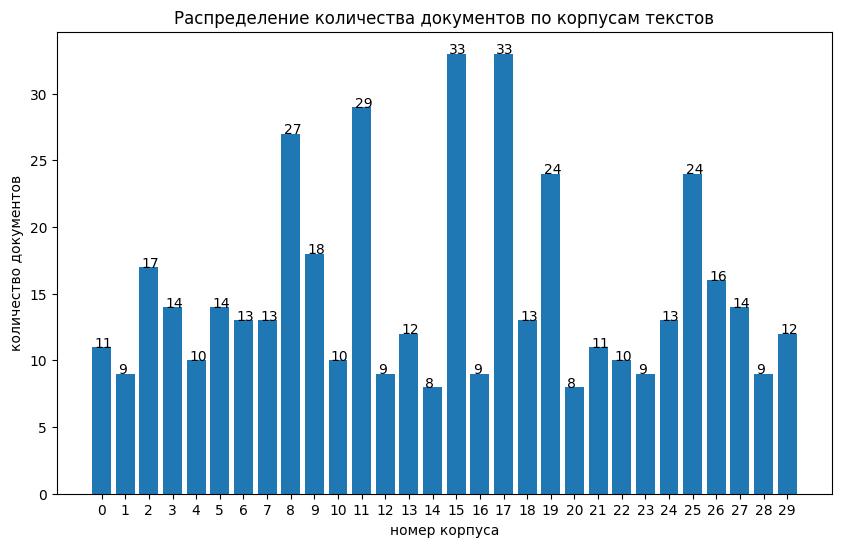

In [314]:
docs_amount = []
for corpus_id in tqdm(corpus_ids_list):
    corpus = df_sovpad[df_sovpad['text_group_id'] == corpus_id]
    docs_amount.append(corpus.shape[0])
    
plt.figure(figsize=(10, 6))
plt.title('Распределение количества документов по корпусам текстов')
plt.xlabel('номер корпуса')
plt.ylabel('количество документов')
plt.bar(np.arange(0, 30), docs_amount)
addlabels(corpus_ids_list, docs_amount)
plt.xticks(np.arange(0, 30))
plt.show()

In [338]:
corpus = data_doc_labels[data_doc_labels['corpus_id'] == '48b345a1-0d3d-4df8-ae7a-862d55f16fde']
corpus

,doc_id,corpus_id,label_1,label_2,label_3,workers
424,8355,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,NaN,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
425,10207,48b345a1-0d3d-4df8-ae7a-862d55f16fde,-1.0,-1.0,2.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
426,6028,48b345a1-0d3d-4df8-ae7a-862d55f16fde,2.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
427,6009,48b345a1-0d3d-4df8-ae7a-862d55f16fde,4.0,9.0,1.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
428,6011,48b345a1-0d3d-4df8-ae7a-862d55f16fde,2.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
429,1047,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
430,6014,48b345a1-0d3d-4df8-ae7a-862d55f16fde,2.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
431,6015,48b345a1-0d3d-4df8-ae7a-862d55f16fde,2.0,3.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
432,6018,48b345a1-0d3d-4df8-ae7a-862d55f16fde,1.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
433,6019,48b345a1-0d3d-4df8-ae7a-862d55f16fde,9.0,9.0,9.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [344]:
poles_number = []
neutral = []
non_relevant = []

for corpus_id in tqdm(corpus_ids_list):
    corpus = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
    
    poles1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] > 0])))
    poles2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] > 0])))
    poles3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] > 0])))
    poles_number.append((poles1, poles2, poles3))
    
    neut1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] == 0])))
    neut2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] == 0])))
    neut3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] == 0])))
    neutral.append((neut1, neut2, neut3))
    
    nonr1 = len(list(np.unique(corpus['label_1'][corpus['label_1'] < 0])))
    nonr2 = len(list(np.unique(corpus['label_2'][corpus['label_2'] < 0])))
    nonr3 = len(list(np.unique(corpus['label_3'][corpus['label_3'] < 0])))
    non_relevant.append((nonr1, nonr2, nonr3))

100%|██████████| 30/30 [00:00<00:00, 532.72it/s]


In [360]:
cols = ['poles_1', 'neutral_1', 'non_relevant_1', 'poles_2', 'neutral_2', 'non_relevant_2','poles_3', 'neutral_3', 'non_relevant_3']
poles_stat = pd.DataFrame(columns=cols, index=list(np.unique(data_doc_labels['corpus_id'])))
poles_stat = poles_stat[['poles_1', 'neutral_1', 'non_relevant_1', 'poles_2', 'neutral_2', 'non_relevant_2','poles_3', 'neutral_3', 'non_relevant_3']]

In [361]:
for i in range(len(corpus_ids_list)):
    if poles_number[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_1'] = poles_number[i][0]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_1'] = '-'
    if poles_number[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_2'] = poles_number[i][1]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_2'] = '-'
    if poles_number[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'poles_3'] = poles_number[i][2]
    else:
        poles_stat.at[corpus_ids_list[i], 'poles_3'] = '-'
    
    if neutral[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_1'] = '+'  
    if neutral[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_2'] = '+'
    if neutral[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'neutral_3'] = '+'
        
    if non_relevant[i][0] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_1'] = '+'
    if non_relevant[i][1] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_2'] = '+'
    if non_relevant[i][2] != 0:
        poles_stat.at[corpus_ids_list[i], 'non_relevant_3'] = '+'
        
poles_stat = poles_stat.fillna('-')

<AxesSubplot: >

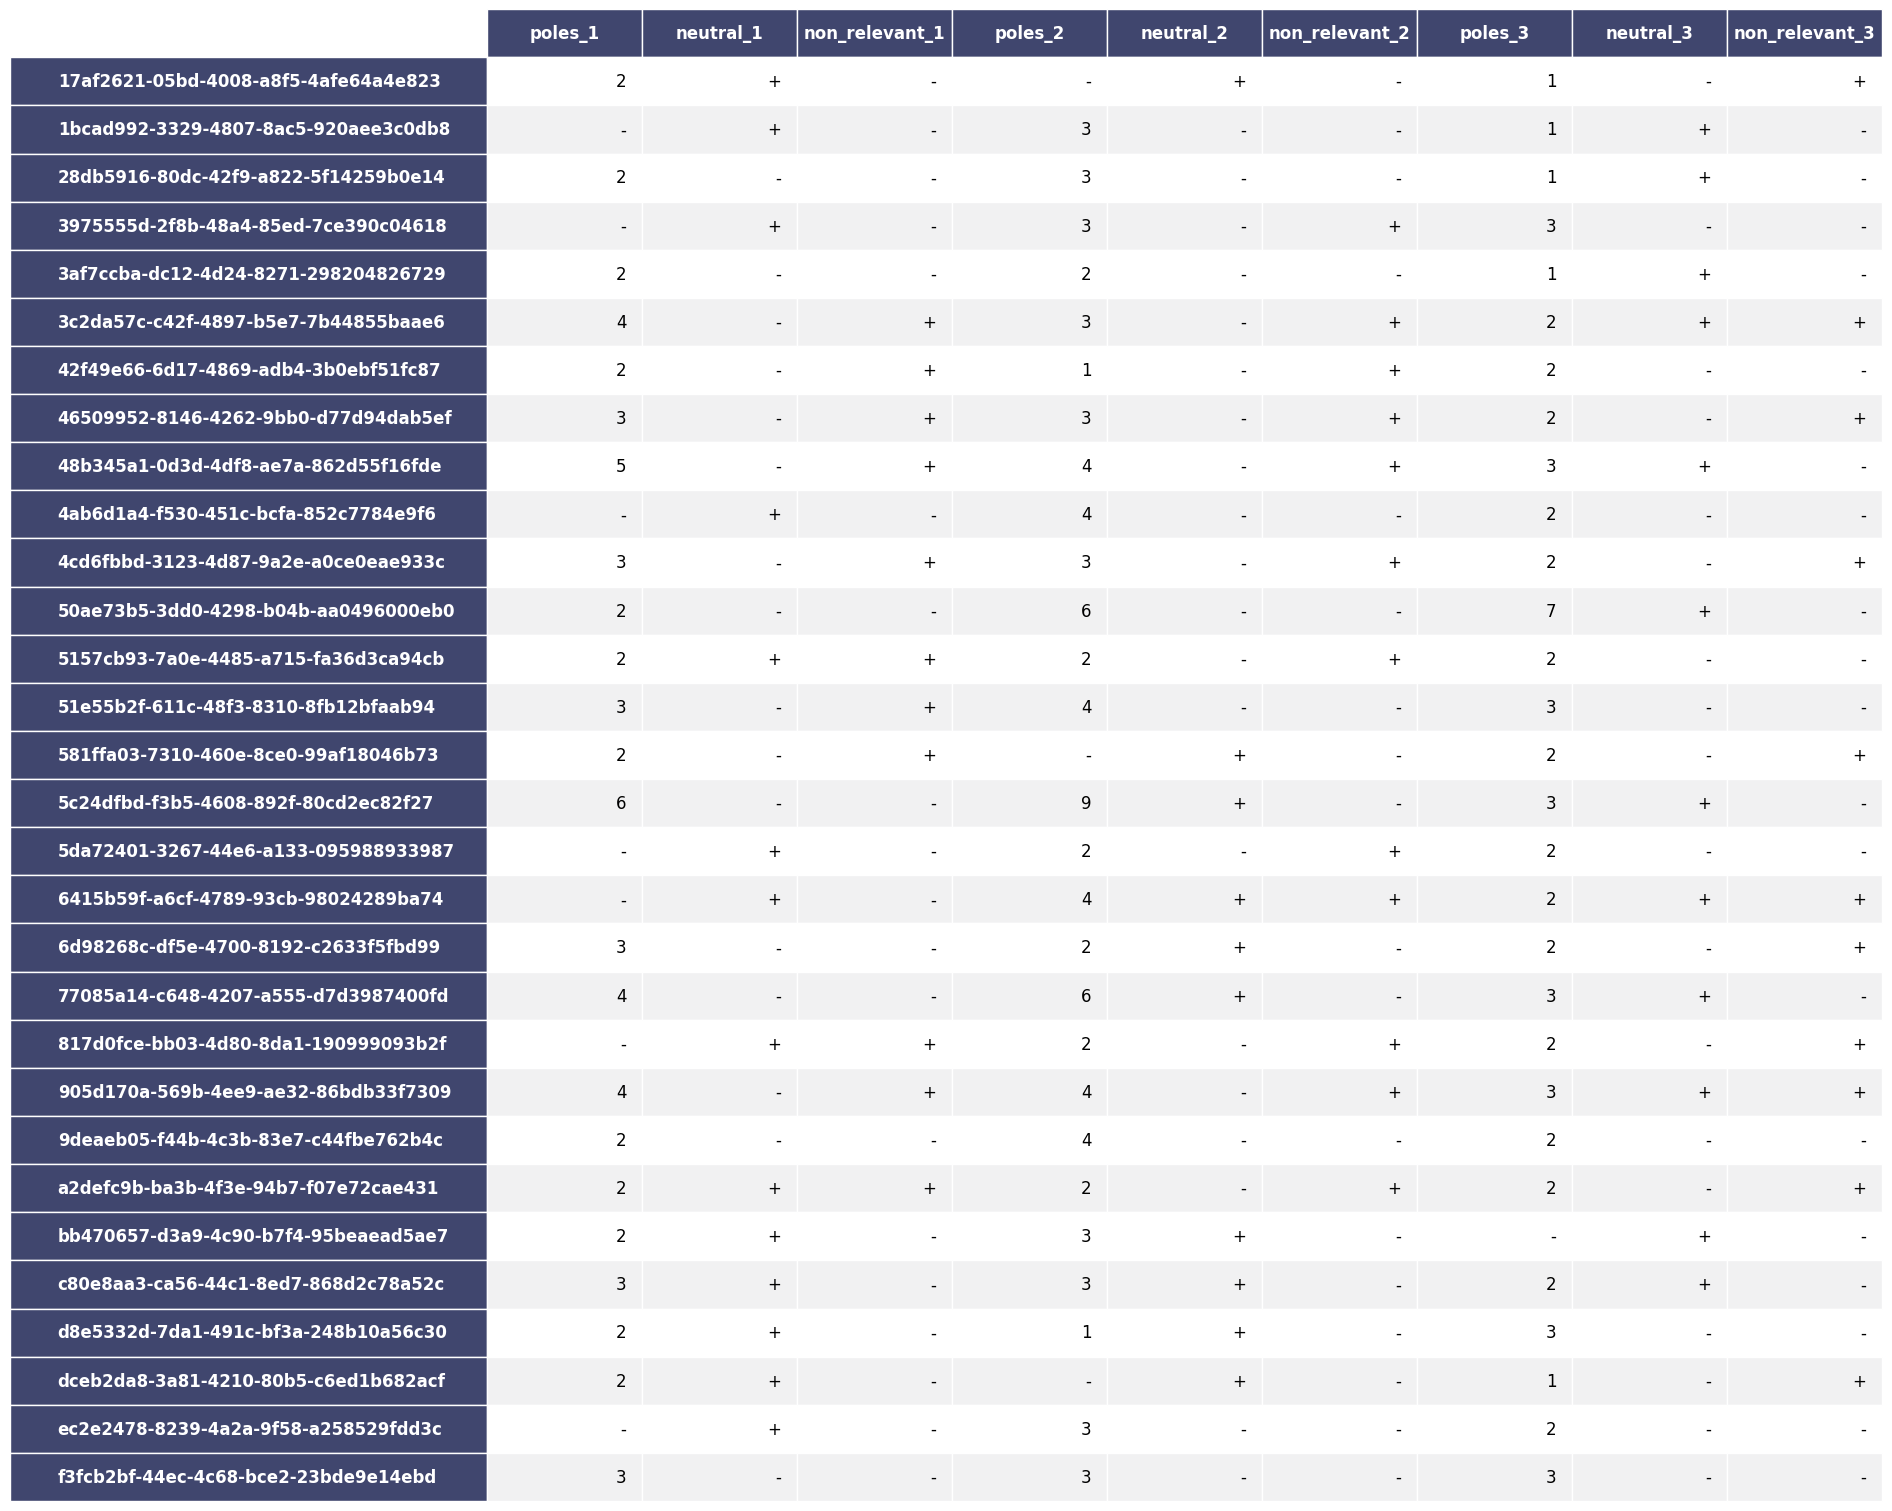

In [363]:
render_mpl_table(poles_stat, header_columns=0, col_width=2.0)

### Красивый экспорт датафрейма в виде изображения

In [61]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=list(data.index), **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax

<AxesSubplot:>

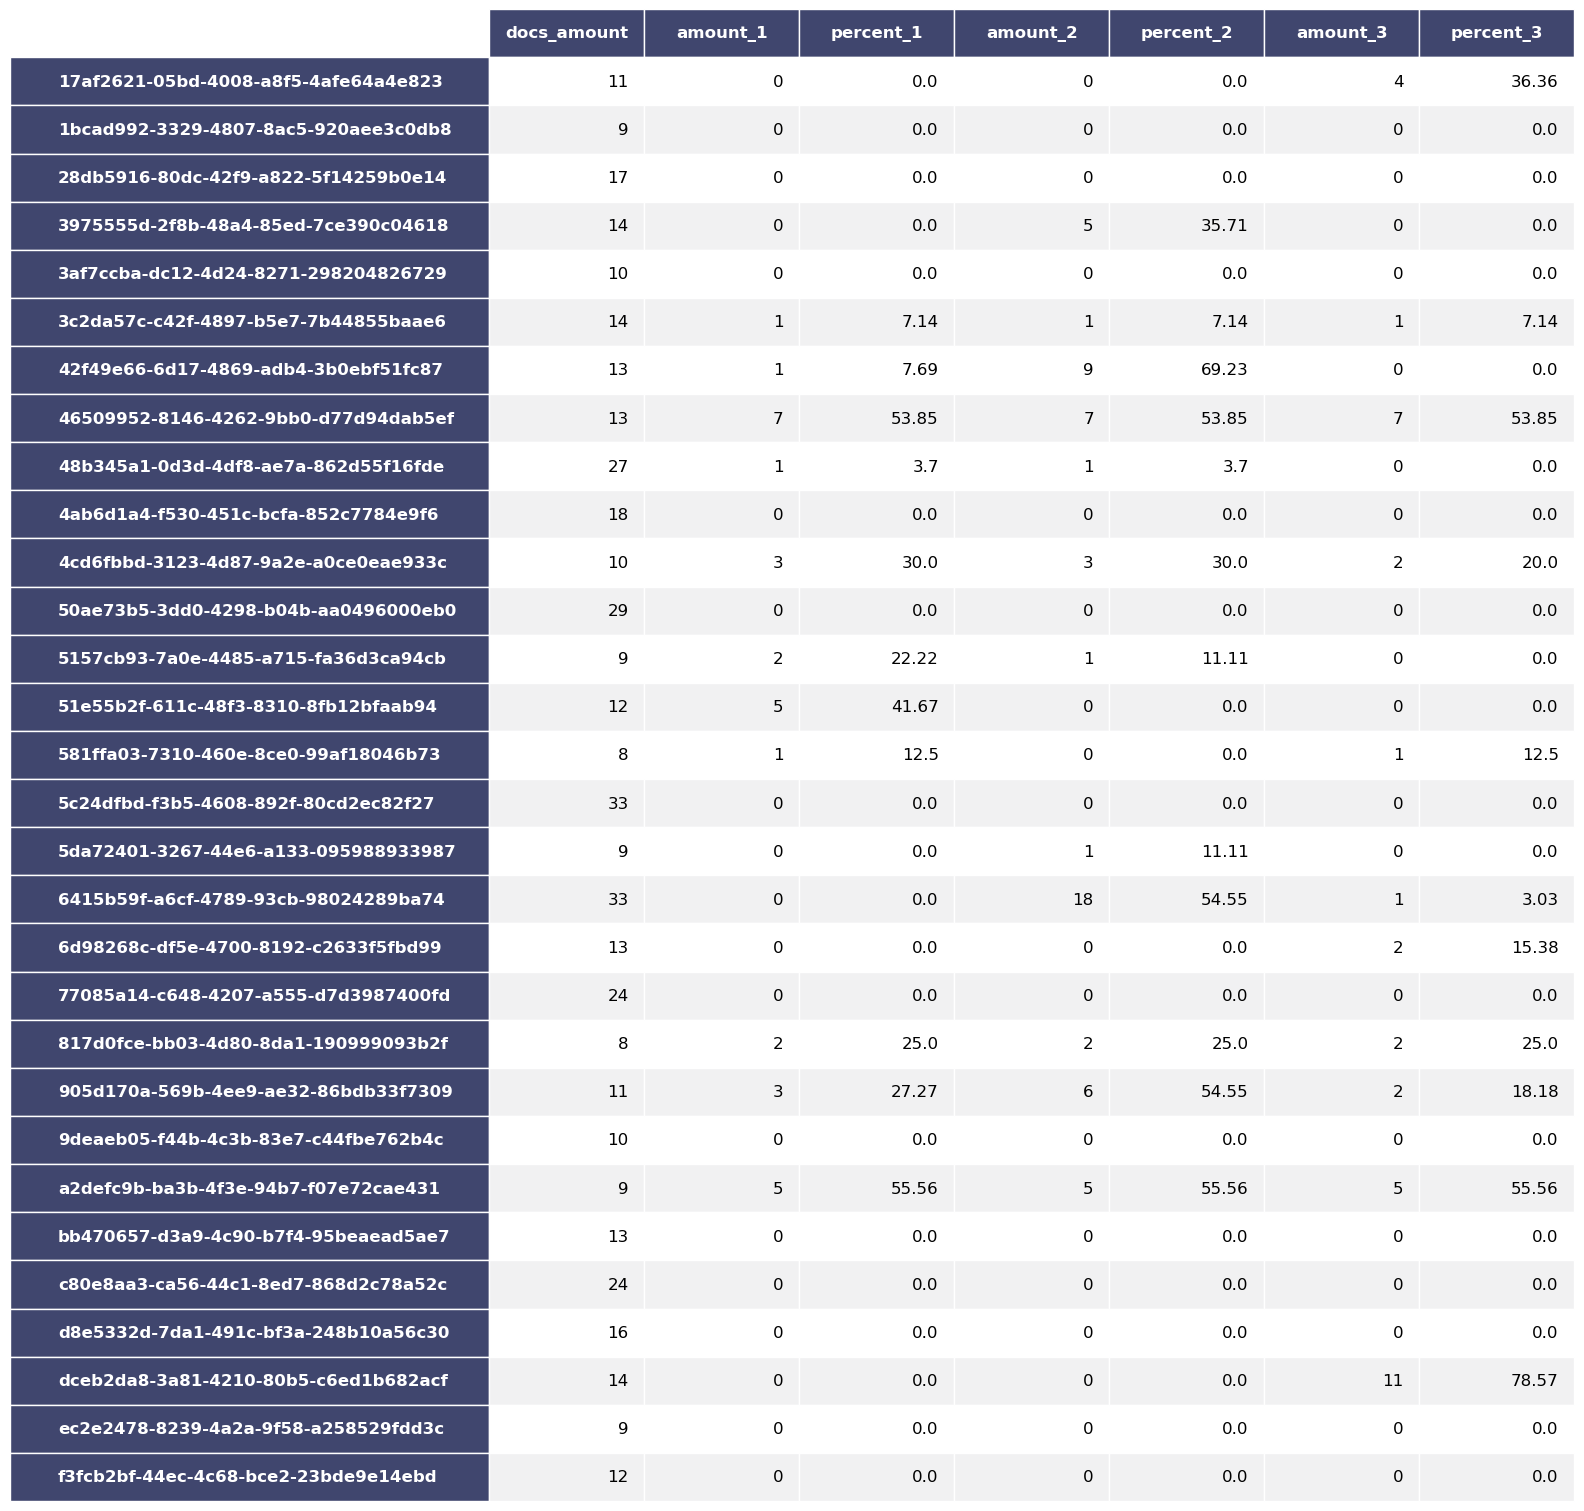

In [915]:
render_mpl_table(non_relevant_data, header_columns=0, col_width=2.0)

# Применяем алгоритм последовательно

Все предыдущие значения метрик получены при условии независимого применения каждого шага модели (к примеру, после применения отсева нерелевантных они не исключаются из датасета)

In [130]:
data_doc_labels.head(3)

,doc_id,corpus_id,label_1,label_2,label_3,workers
0,1020,5157cb93-7a0e-4485-a715-fa36d3ca94cb,-1.0,9.0,9.0,"[07947fa51c6a1d996956f30fef7efa68, be6dd5ed069..."
1,591,50ae73b5-3dd0-4298-b04b-aa0496000eb0,1.0,1.0,5.0,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."
2,4009,42f49e66-6d17-4869-adb4-3b0ebf51fc87,1.0,1.0,NaN,"[be6dd5ed06926c811c121ff0b99d0459, 57ff7fa2bd8..."


In [193]:
total_results_posled = pd.DataFrame(columns={'M3_1', 'M3_2', 'M3_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
total_results_posled = total_results_posled[['M3_1', 'M3_2', 'M3_3']]

asessors_comparing_M3_posled = pd.DataFrame(columns={'1_2', '1_3', '2_3'}, index=list(np.unique(data_doc_labels['corpus_id'])))
asessors_comparing_M3_posled = asessors_comparing_M3[['1_2', '1_3', '2_3']]

In [194]:
total_doc_corpus_labels = pd.DataFrame(columns={'doc_id', 'corpus_id', 'label'})
total_doc_corpus_labels = total_doc_corpus_labels[['doc_id', 'corpus_id', 'label']]

In [195]:
def non_relevant_extraction(corpus_ids_list, data_doc_labels, df_sovpad, total_results_posled, asessors_comparing_M3_posled, total_doc_corpus_labels):
    
    for corpus_id in tqdm(corpus_ids_list):
        test = data_doc_labels[data_doc_labels['corpus_id'] == corpus_id]
        docs = list(test['doc_id'])

        test_semantic = pd.DataFrame(columns={'doc1', 'doc2', 'similarity'})
        
        k = 0
        for i in range(len(docs)):
            for j in range(i+1, len(docs)):
                test_semantic.at[k, 'doc1'] = docs[i]
                test_semantic.at[k, 'doc2'] = docs[j]
                k += 1
                
        for i in range(test_semantic.shape[0]):
            doc1_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc1']].index[0]
            doc1 = nlp(df_sovpad.at[doc1_id, 'lemm_sentences'])
        
            doc2_id = df_sovpad[df_sovpad['doc_id'] == test_semantic.at[i, 'doc2']].index[0]
            doc2 = nlp(df_sovpad.at[doc2_id, 'lemm_sentences'])
        
            test_semantic.at[i, 'similarity'] = doc1.similarity(doc2)
            
        #test_semantic = test_semantic.sort_values(by=['similarity'])

        optics = OPTICS(max_eps=1, min_samples=5)
        optics.fit(np.array(test_semantic['similarity']).reshape(-1, 1))
        
        test_semantic.insert(3, 'label', 0)
        test_semantic = test_semantic[['doc1', 'doc2', 'similarity', 'label']]
        test_semantic['label'] = optics.labels_
        test_semantic = test_semantic.sort_index()

        docs_labels = []

        for doc in docs:
            doc_dict = {}
            for i in range(test_semantic.shape[0]):
                if test_semantic.at[i, 'doc1'] == doc or test_semantic.at[i, 'doc2'] == doc:
                    if test_semantic.at[i, 'label'] not in doc_dict.keys():
                        doc_dict[test_semantic.at[i, 'label']] = 1
                    else:
                        doc_dict[test_semantic.at[i, 'label']] += 1
            #print(doc)
            #print(doc_dict)
            #print(find_most_popular_label(doc_dict))
            # break
            # docs_labels.append(max(doc_dict, key=doc_dict.get))
            docs_labels.append(find_most_popular_label(doc_dict))
            # print('-----')
        # print(docs_labels)
        
        total_results_posled.at[corpus_id, 'M3_1'] = round(M3(docs_labels, list(test['label_1'])), 3)
        total_results_posled.at[corpus_id, 'M3_2'] = round(M3(docs_labels, list(test['label_2'])), 3)
        total_results_posled.at[corpus_id, 'M3_3'] = round(M3(docs_labels, list(test['label_3'])), 3)
        
        asessors_comparing_M3_posled.at[corpus_id, '1_2'] = round(M3(list(test['label_1']), list(test['label_2'])), 3)
        asessors_comparing_M3_posled.at[corpus_id, '1_3'] = round(M3(list(test['label_1']), list(test['label_3'])), 3)
        asessors_comparing_M3_posled.at[corpus_id, '2_3'] = round(M3(list(test['label_2']), list(test['label_3'])), 3)
        
        # возвращаем лейблы нерелевантных документов
        for i in range(len(docs_labels)):
            index_ = total_doc_corpus_labels.shape[0]
            total_doc_corpus_labels.at[index_, 'doc_id'] = docs[i]
            total_doc_corpus_labels.at[index_, 'corpus_id'] = corpus_id
            if docs_labels[i] == -1:
                total_doc_corpus_labels.at[index_, 'label'] = -1
    return total_doc_corpus_labels

In [196]:
total_doc_corpus_labels = non_relevant_extraction(corpus_ids_list, data_doc_labels, df_sovpad, total_results_posled, asessors_comparing_M3_posled, total_doc_corpus_labels)

100%|██████████| 30/30 [06:12<00:00, 12.41s/it]


In [200]:
total_doc_corpus_labels

,doc_id,corpus_id,label
0,2558,17af2621-05bd-4008-a8f5-4afe64a4e823,-1
1,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,NaN
2,2524,17af2621-05bd-4008-a8f5-4afe64a4e823,-1
3,2525,17af2621-05bd-4008-a8f5-4afe64a4e823,-1
4,2526,17af2621-05bd-4008-a8f5-4afe64a4e823,-1
...,...,...,...
447,9959,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
448,9960,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
449,9961,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
450,9962,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,-1


In [201]:
total_doc_corpus_labels_relevant = total_doc_corpus_labels[total_doc_corpus_labels['label'] != -1]
total_doc_corpus_labels_relevant

,doc_id,corpus_id,label
1,2563,17af2621-05bd-4008-a8f5-4afe64a4e823,NaN
5,9104,17af2621-05bd-4008-a8f5-4afe64a4e823,NaN
13,4095,1bcad992-3329-4807-8ac5-920aee3c0db8,NaN
14,4094,1bcad992-3329-4807-8ac5-920aee3c0db8,NaN
15,4097,1bcad992-3329-4807-8ac5-920aee3c0db8,NaN
...,...,...,...
446,9965,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
447,9959,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
448,9960,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN
449,9961,f3fcb2bf-44ec-4c68-bce2-23bde9e14ebd,NaN


In [202]:
total_results_posled

,M3_1,M3_2,M3_3
17af2621-05bd-4008-a8f5-4afe64a4e823,NaN,NaN,0.462
1bcad992-3329-4807-8ac5-920aee3c0db8,NaN,NaN,NaN
28db5916-80dc-42f9-a822-5f14259b0e14,NaN,NaN,NaN
3975555d-2f8b-48a4-85ed-7ce390c04618,NaN,0,NaN
3af7ccba-dc12-4d24-8271-298204826729,NaN,NaN,NaN
3c2da57c-c42f-4897-b5e7-7b44855baae6,0,0,0.143
42f49e66-6d17-4869-adb4-3b0ebf51fc87,0.143,0.818,NaN
46509952-8146-4262-9bb0-d77d94dab5ef,0.533,0.533,0.533
48b345a1-0d3d-4df8-ae7a-862d55f16fde,0.074,0.074,NaN
4ab6d1a4-f530-451c-bcfa-852c7784e9f6,NaN,NaN,NaN


In [203]:
print('M3_1 mean: ', total_results_posled['M3_1'].mean())
print('M3_2 mean: ', total_results_posled['M3_2'].mean())
print('M3_2 mean: ', total_results_posled['M3_3'].mean())

M3_1 mean:  0.3639090909090909
M3_2 mean:  0.3774166666666667
M3_2 mean:  0.42736363636363633


In [204]:
print('M3 mean: ', (total_results_posled['M3_1'].mean() + total_results_posled['M3_2'].mean() + total_results_posled['M3_3'].mean()) / 3)

M3 mean:  0.3895631313131313
